# Import Packages and Define Basic functions

In [1]:
%pylab notebook

import numpy as np 
import scipy.stats as stats
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib import colors as mcolors
from matplotlib.lines import Line2D
import os
import time
from scipy.optimize import curve_fit
from IPython.core.display import display, HTML
from matplotlib.backends.backend_pdf import PdfPages
display(HTML("<style>.container { width:95% !important; }</style>"))
from operator import itemgetter
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# from __future__ import division, print_function
from scipy.spatial.distance import pdist, squareform

mpl.rcParams['figure.figsize'] = [8.0, 6.0]
mpl.rcParams['figure.dpi'] = 100
mpl.rcParams['savefig.dpi'] = 100
mpl.rcParams['figure.max_open_warning'] = False 
rcParams.update({'figure.autolayout': True})


    
# ----- Common Parameters in Plotting -----
w = 12           # width of figure
h = 4.5          # height of figure
Norm = True      # Normalize Data
timebin = 10000  # Timebin size
minFit = 3       # First data point to fit from
maxFit = 50      # Last data point to fit from

Populating the interactive namespace from numpy and matplotlib


In [2]:
# ----- Helper Functions -----
def running_mean(x, N):
    cumsum = numpy.cumsum(numpy.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)

def func_powerlaw(x, m, c):
    return x**m * c

def func_logNonlinPowLaw(s,a,m,sig,eps):
    powerlaw = a - m * s - eps * exp(sig*s)
    return powerlaw

def rec_plot(s, eps, steps=1):
    d = pdist(s[:,None])
    d = np.floor(d/eps)
    d[d>steps] = steps
    Z = 1 - squareform(d)
    return Z

def logbinning(inputDurations,sizebin,divisor,maxim):
    """ Input: inputSizes - Array to logbin
               sizebin - number of bins 
    """
    ss = 0
    frequenciesDurationsUnormed = inputDurations[0].astype(float)
    for qwer in range(len(frequenciesDurationsUnormed[:,0])):
        frequenciesDurationsUnormed[qwer,0] = frequenciesDurationsUnormed[qwer,0]/divisor
    y_max = np.max(frequenciesDurationsUnormed[:,0])+1
    y_max = maxim
    rawLogBinEdges = np.logspace(0,np.log10(y_max)+1,sizebin)
    logBinEdges = np.array(list(set([int(i) for i in rawLogBinEdges])))
    logBinEdges = np.sort(logBinEdges)
    # print(y_max,logBinEdges)
    dbins = logBinEdges[1:]-logBinEdges[:-1]
    dbins = np.array([dbins[i] if dbins[i] != 0 else 1 for i in range(len(dbins))])
    frequenciesDurationsUnbinnedList = [[dbins[ss],0]]
    for j in range(len(frequenciesDurationsUnormed[:,0])):
        if int(frequenciesDurationsUnormed[j,0]) <= dbins[ss]:
            frequenciesDurationsUnbinnedList[-1][1] += frequenciesDurationsUnormed[j,1]/dbins[ss]
        else:
            ss += 1
            frequenciesDurationsUnbinnedList += [[dbins[ss],frequenciesDurationsUnormed[j,1]/dbins[ss]]]
    frequenciesDurationsUnbinned = np.asarray(frequenciesDurationsUnbinnedList)
    return frequenciesDurationsUnbinned

## doStuffSizes
**Input**: 
- filename of data

**Return**: 
- data: (type:List)
- parts: List of parameters and values

In [3]:
def doStuffSizes(filename):
    """
    Input: 
        - filename of data

    Return: 
        - data: (type:List)
        - parts: List of parameters and values
    """
    text_file = open("Data/" + filename, "r")
    lines = []
    for line in open("Data/" + filename, "r"):
        lines += [line]
    lines = text_file.read().split('\n')
    eventList = lines[3:]
    
    neuralAvalancheStr = []
    neuralAvalancheData = []
    
    # Make lists from all the data
    for i in range(len(eventList)):
        tempstr = eventList[i]
        neuralAvalancheStr += [tempstr.split(' ')]
        while '' in neuralAvalancheStr[-1]:
            neuralAvalancheStr[-1].remove('')
        for j in range(len(neuralAvalancheStr[-1])):
            neuralAvalancheData.append(int(neuralAvalancheStr[-1][j]))

    neuroSizes = np.asarray(neuralAvalancheData).reshape(len(neuralAvalancheData)//2,2)
    for j in range(len(neuroSizes[:,1])-1,0,-1):
        if neuroSizes[j,1] == 0:
            neuroSizes = np.delete(neuroSizes, j, 0)

    # Create a list of the parameters
    parts = lines[2].split(' ')
    while '' in parts:
        parts.remove('')
        
    return neuroSizes, parts

## plotBoth
Plots the distribution of Sizes and Durations. It is expected that at the critical point, the scaling will be:

$$ N(s) \propto s^{-\tau},\quad N(t) \propto t^{-\alpha}$$

where $\tau = 3/2$ and $\alpha = 2$. 

**Inputs**: 
- inputSizes, inputDurations: HistogramList-type distributions for sizes and durations
- width, length: of plots
- timebin: Timebin size for durations. Usually $=N$
- sizebin: Number of bins for binning Sizes. Bins are logarithmic.
- minFit, maxFit: range for fitting. (Currently not being used)
- Normalize(Boolean): normalize the distributions?
- filename, save(Boolean): to save plots

In [4]:
def plotBoth(inputSizes,inputDurations,width,length,sizebin,filename,save,show):
    fig = plt.figure(figsize=(width,length)); grid = gridspec.GridSpec(1,2,wspace=0.3,hspace=0.3)
    axSize = fig.add_subplot(grid[0,0]); axDuration = fig.add_subplot(grid[0,1])
    
    unNormedParts = inputDurations[1]  # Setup list of parameters 
    parts = [int(unNormedParts[0])]
    for i in range(len(unNormedParts)-1):
        parts += [str(round(float(unNormedParts[i+1]),8))]
        
    # -------------------- Preparing Data  -------------------- #    
    frequenciesDurations = logbinning(inputDurations,sizebin,1,1e6) # Logbin data 
    frequenciesSizes = logbinning(inputSizes,sizebin,1,1e9)
    
    frequenciesDurations[:,1] /= np.sum(frequenciesDurations[:,1]) # Normalize histograms
    frequenciesSizes[:,1] /= np.sum(frequenciesSizes[:,1])
        
    
    # -------------------- Fitting  -------------------- #    
    initGuess = np.asarray([0,1.5,0.5,float(parts[1])])
    paramBounds = ( (-1,1.45,0.3, 0.99*float(parts[1])), (1,1.55,0.7, 1.01*float(parts[1]))  )
    xDataSiz = np.log(np.asarray(frequenciesSizes[2:,0]))
    yDataSiz = np.log(np.asarray(frequenciesSizes[2:,1]))
    poptSiz,pcovSiz = curve_fit(func_logNonlinPowLaw,xDataSiz,yDataSiz,p0=initGuess,bounds=paramBounds)
    
    initGuess = np.asarray([0,2,0.8,float(parts[1])])
    paramBounds = ( (-1,1.975,0, 0.99*float(parts[1])), (1,2.025,1.6, 1.01*float(parts[1]))  )
    xDataDur = np.log(np.asarray(frequenciesDurations[2:,0]))
    yDataDur = np.log(np.asarray(frequenciesDurations[2:,1]))
    poptDur,pcovDur = curve_fit(func_logNonlinPowLaw,xDataDur,yDataDur,p0=initGuess,bounds=paramBounds)
    

    # -------------------- Plotting -------------------- #
    axDuration.plot(frequenciesDurations[:,0], frequenciesDurations[:,1],linewidth=0,marker='.',color='red',label=r'$\epsilon=$'+str("%10.1e"% float(parts[1]))+r'; $ \tau \simeq $'+str(round(poptDur[1],2)) + ', $\sigma \simeq $' + str(round(poptDur[2],2))),
    axDuration.plot(np.exp(xDataDur),np.exp(func_logNonlinPowLaw(xDataDur,*poptDur)),color='red')
    axDuration.set_xscale('log', nonposx='clip'); axDuration.set_yscale('log', nonposy='clip')
    axDuration.set_xlabel(r't - Duration',fontweight='bold',fontsize='large'); axDuration.set_ylabel(r'N(t)',fontweight='bold',fontsize='large')
    axDuration.set_xlim(left=1,right=10**6); axDuration.set_ylim(bottom=10**(-11),top=1)

    axSize.plot(frequenciesSizes[:,0],frequenciesSizes[:,1],linewidth=0,marker='.',color='red',label=r'$\epsilon=$'+str("%10.1e"% float(parts[1]))+r'; $ \tau = $'+str(round(poptSiz[1],3)) + ', $\sigma = $' + str(round(poptSiz[2],3)))
    axSize.plot(np.exp(xDataSiz),np.exp(func_logNonlinPowLaw(xDataSiz,*poptSiz)),color='red')
    axSize.set_xscale('log', nonposx='clip'); axSize.set_yscale('log', nonposy='clip')
    axSize.set_xlabel(r's - Size',fontweight='bold',fontsize='large'); axSize.set_ylabel(r'N(s)',fontweight='bold',fontsize='large')
    axSize.set_xlim(left=1,right=10**9); #axSize.set_ylim(bottom=10**(-7),top=1)
        
    x = np.logspace(0,8,1000)
    axDuration.plot(x,x**(-2), linestyle='--',color='grey',label=('slope: m = -2'))
    axSize.plot(x,x**(-1.5), linestyle='--',color='grey',label=('slope: m = -1.5'))
    
    axDuration.legend(loc=1); axSize.legend(loc=1)
    fig.suptitle('$N = $'+str(parts[0])+'$; \epsilon=$'+str(parts[1])+'; $\lambda=$'+str(parts[2])+'; $\mu=$'+str(parts[3]+'; $\kappa=$'+str(parts[4])),fontweight='bold',fontsize='large')
    if show==True:
        plt.show(fig)
    if save==True:
        fig.savefig(filename,dpi=300)
        plt.close(fig)
    print("N = "+ str(parts[0]) + "; eps = "+ str(round(float(parts[1]),3))
          + "; tau = " +str(round(poptSiz[1],3)) + '; sigma =' + str(round(poptSiz[2],3))
          + "; tau_t = " +str(round(poptDur[1],3)) + '; sigma_t =' + str(round(poptDur[2],3))
          + "; G = "+ str(int(parts[0])*float(parts[1])**(3/2)))
    return fig

In [5]:
def addPlotBoth(inputSizes,inputDurations,axSize,axDuration,timebin,sizebin,kk,color):
    ''' Add a plot to one of the figures separately, without needing to display a figure yet'''
    Normalize = True
    
    unNormedParts = inputDurations[1]
    parts = [int(unNormedParts[0])]
    for i in range(len(unNormedParts)-1):
        parts += [str(round(float(unNormedParts[i+1]),8))]
    
    frequenciesDurations = logbinning(inputDurations,sizebin,1,1e7)
    frequenciesSizes = logbinning(inputSizes,sizebin,1,1e9)
    
    frequenciesDurations[:,1] /= np.sum(frequenciesDurations[:,1])
    frequenciesSizes[:,1] /= np.sum(frequenciesSizes[:,1])

    initGuess = np.asarray([0,1.5,0.5,float(parts[1])])
    paramBounds = ( (-1,1.475,0.3, 0.99*float(parts[1])), (1,1.525,0.7, 1.01*float(parts[1]))  )
    xDataSiz = np.log(np.asarray(frequenciesSizes[2:,0]))
    yDataSiz = np.log(np.asarray(frequenciesSizes[2:,1]))
    poptSiz,pcovSiz = curve_fit(func_logNonlinPowLaw,xDataSiz,yDataSiz,p0=initGuess,bounds=paramBounds)
    
    initGuess = np.asarray([0,2,0.8,float(parts[1])])
    paramBounds = ( (-1,1.975,0, 0.99*float(parts[1])), (1,2.025,1.6, 1.01*float(parts[1]))  )
    xDataDur = np.log(np.asarray(frequenciesDurations[2:,0]))
    yDataDur = np.log(np.asarray(frequenciesDurations[2:,1]))
    poptDur,pcovDur = curve_fit(func_logNonlinPowLaw,xDataDur,yDataDur,p0=initGuess,bounds=paramBounds)
    
    return [axSize.plot(frequenciesSizes[:,0],(10**kk) * frequenciesSizes[:,1],linewidth=0,marker='.',color=color,label=r'$\epsilon=$'+str("%10.1e"% float(parts[1]))+r'; $ \tau \simeq $'+str(round(poptSiz[1],2)) + ', $\sigma \simeq $' + str(round(poptSiz[2],2))),
            axSize.plot(np.exp(xDataSiz),np.exp(func_logNonlinPowLaw(xDataSiz,*poptSiz)),color=color),
            axDuration.plot(frequenciesDurations[:,0], frequenciesDurations[:,1],linewidth=0,marker='.',color=color,label=r'$\epsilon=$'+str("%10.1e"% float(parts[1]))+r'; $ \tau \simeq $'+str(round(poptDur[1],2)) + ', $\sigma \simeq $' + str(round(poptDur[2],2))),
            axDuration.plot(np.exp(xDataDur),np.exp(func_logNonlinPowLaw(xDataDur,*poptDur)),color=color)]

## chiN
**Inputs**:
- inputSize: HistogramList of Sizes (as list)
- inputDuration: HistogramList of Durations (as list)
- wdith, length: of output Plot
- timebin: timebin of durations 
- minFit,maxFit: range of fitting

**Returns**: 
- Lists of Response function, $\chi$ for Sizes and Durations, where

$$ \chi_s = \frac{\sum_s s^2 n(s)}{\sum_s s n(s)} \propto s^{-\gamma}$$

In [6]:
def chiN(inputSizes,inputDurations):
    """
    Inputs:
        - inputSize: HistogramList of Sizes (as list)
        - inputDuration: HistogramList of Durations (as list)
        - wdith, length: of output Plot
        - timebin: timebin of durations 
        - minFit,maxFit: range of fitting

    Returns: 
        - Lists of Response function, $\chi$ for Sizes and Durations, where
    """
    unNormedParts = inputDurations[1]
    parts = [int(unNormedParts[0])]
    for i in range(len(unNormedParts)-1):
        parts += [unNormedParts[i+1]]
    x = np.linspace(1,parts[0])
    
    frequenciesDurations = inputDurations[0].astype(float)
    frequenciesSizes = inputSizes[0].astype(float)
    
    frequenciesDurations[:,1] /= frequenciesDurations[0,1]
    frequenciesSizes[:,1] /= frequenciesSizes[0,1]
        
    # ---------- Compute the response functions (Durations) ----------
    z = 0
    for j in range(len(frequenciesDurations[:,1])):
        z += frequenciesDurations[j,1] * frequenciesDurations[j,0]
    chi_n_Dur = 0
    for j in range(len(frequenciesDurations[:,1])):
        chi_n_Dur += frequenciesDurations[j,1] * ( frequenciesDurations[j,0])**2 / z
    
    # ---------- Compute the response functions (Sizes) ----------
    z = 0 #(Durations)
    for j in range(len(frequenciesSizes[:,1])):
        z += frequenciesSizes[j,1] * frequenciesSizes[j,0]
    chi_n_Siz = 0
    for j in range(len(frequenciesSizes[:,1])):
        chi_n_Siz += frequenciesSizes[j,1] * ( frequenciesSizes[j,0])**2 / z
        
    return [parts[1], float(chi_n_Siz),float(chi_n_Dur)]

## activityDensity
**Inputs**: 
- filename: of the brainXXXX_timeData.txt
- width, length: end plot
- show (Boolean): show plot iff True
   
**Returns**:
- Fluctuations in activity density, $\sigma(\rho)$
- (if show==True) Plot of density of activity as a function of time:
$$ \rho(t) \equiv \frac{1}{N} \sum_n A_k$$


In [7]:
def activityDensityPlots(filename, width, length, bins, save, savename):
    """
    Inputs: 
        - filename: of the brainXXXX_timeData.txt
        - width, length: end plot
        - show (Boolean): save plot iff True
        - savename: path to save file to
   
    Returns:
        - Fluctuations in activity density, $\sigma(\rho)$
        - (if show==True) Plot of density of activity as a function of time:
        - $$ \rho(t) \equiv \frac{1}{N} \sum_n A_k$$
    """
    # ---------- Open and read in timeData file ----------
    text_file = open("Data/" + filename, "r")
    lines = []
    while len(lines) <= 2e5:
        for line in open("Data/" + filename, "r"):
            lines += [line]
    lines = text_file.read().split('\n')
    eventList = lines[3:]
    
    neuralAvalancheStr = []
    neuralAvalancheData = []
    
    # ---------- Make lists from all the data ----------
    for i in range(len(eventList)):
        tempstr = eventList[i]
        neuralAvalancheStr += [tempstr.split(' ')]
        while '' in neuralAvalancheStr[-1]:
            neuralAvalancheStr[-1].remove('')
        for j in range(len(neuralAvalancheStr[-1])):
            neuralAvalancheData.append(int(neuralAvalancheStr[-1][j]))
    activityDensity = np.asarray(neuralAvalancheData).reshape(len(neuralAvalancheData)//3,3)

    # ---------- Create a list of the parameters ----------
    unNormedParts = lines[2].split(' ')    # Get rid of spaces in strings
    while '' in unNormedParts:
        unNormedParts.remove('')
    parts = [int(unNormedParts[0])]        # Make the parameters look pretty
    for i in range(len(unNormedParts)-1):
        parts += [str(round(float(unNormedParts[i+1]),8))]
    activityDensity = activityDensity.astype(float)
    activityDensity[:,1] /= parts[0]
    
    # ---------- Make plots (Main - Histogram; Side - Activity time series) ----------
    fig = plt.figure(figsize=(width,length)); grid = gridspec.GridSpec(2,16,wspace=0.5,hspace=0.3)
    ax2 = fig.add_subplot(grid[0,:])
    ax3 = fig.add_subplot(grid[1,:])

    ax2.plot(activityDensity[:,0],activityDensity[:,1],label=r'$\rho$',linewidth=0.5,color='red')
    ax2.set_xlabel(r'time - $t$',fontsize='large'); ax2.set_ylabel(r'$\rho$',fontsize='large')
    ax2.set_xlim(left=0,right=None)
    ax2.yaxis.tick_right(); ax2.yaxis.set_label_position("right")

    ax3.plot(activityDensity[:,0],activityDensity[:,2],label=r'$\rho$',linewidth=0.5,color='red')
    ax3.set_xlabel(r'time - $t$',fontsize='large'); ax3.set_ylabel(r'$u$',fontsize='x-large')
    ax3.set_xlim(left=0,right=None) 
    ax3.yaxis.tick_right(); ax3.yaxis.set_label_position("right")

    ax2.tick_params('both')
    fig.suptitle('$N = $'+str(parts[0])+'$; \epsilon=$'+str(parts[1])+'; $\lambda=$'+str(parts[2])+'; $\mu=$'+str(parts[3]+'; $\kappa=$'+str(parts[4])),fontweight='bold',fontsize='large')
    if save == True:
        fig.savefig(savename,dpi=300)
        plt.close(fig)
    else:
        plt.show(fig)
         
    # ---------- Compute Std. Dev. ----------
    mean = np.mean(np.asarray(activityDensity[:,1]))
    meanUnique = np.mean(np.asarray(activityDensity[:,2]))
    var = np.var(np.asarray(activityDensity[:,2]))
    return [parts[1],mean,meanUnique,var]

In [8]:
def rec_plot(s, eps, steps=1):
    d = pdist(s[:,None])
    d = np.floor(d/eps)
    d[d>steps] = steps
    Z = 1 - squareform(d)
    return Z

def actRecPlots(filename, startT, endT, cutoffPerc, save, savename):
    text_file = open("Data/" + filename, "r")
    lines = []
    while len(lines) <= 2e5:
        for line in open("Data/" + filename, "r"):
            lines += [line]
    lines = text_file.read().split('\n')
    eventList = lines[3:]

    neuralAvalancheStr = []
    neuralAvalancheData = []


    # ---------- Make lists from all the data ----------
    for i in range(len(eventList)):
        tempstr = eventList[i]
        neuralAvalancheStr += [tempstr.split(' ')]
        while '' in neuralAvalancheStr[-1]:
            neuralAvalancheStr[-1].remove('')
        for j in range(len(neuralAvalancheStr[-1])):
            neuralAvalancheData.append(int(neuralAvalancheStr[-1][j]))
    activityDensity = np.asarray(neuralAvalancheData).reshape(len(neuralAvalancheData)//3,3)

    # ---------- Create a list of the parameters ----------
    unNormedParts = lines[2].split(' ')    # Get rid of spaces in strings
    while '' in unNormedParts:
        unNormedParts.remove('')
    parts = [int(unNormedParts[0])]        # Make the parameters look pretty
    for i in range(len(unNormedParts)-1):
        parts += [str(round(float(unNormedParts[i+1]),8))]
    activityDensity = activityDensity.astype(float)
    
    eps = cutoffPerc * int(parts[0]) #Threshold Value, such that rho > 0.1 is cut off? 
    steps = 1
    
    # Plot unifrom dist filtered with moving average
    data = activityDensity[startT:endT,1]
    
    fig = plt.figure(figsize=(5,7))
    grid = gridspec.GridSpec(8,7,wspace=0.1,hspace=0.1)
    ax1 = fig.add_subplot(grid[:1,:])
    ax2 = fig.add_subplot(grid[1:,:])

    ax1.plot(activityDensity[startT:endT,0],activityDensity[startT:endT,1],color='red',linewidth=0.25)
    ax2.imshow(rec_plot(data, eps=eps, steps=steps),cmap='binary',origin='lower')
    
    ax1.ticklabel_format(axis='y', style='sci', scilimits=None, useOffset=False, useLocale=None, useMathText=True)
    
    ax1.set_title('$N = $'+str(parts[0])+'$; \epsilon=$'+str(parts[1])+'; $\lambda=\mu=$'+str(parts[3]),fontweight='bold',fontsize='large')
    if save == True:
        fig.savefig(savename,dpi=360)
        plt.close(fig)
    else:
        plt.show(fig)
        

# Basic Plots of Data

For loop over every possible seed number (last two digits, rest implied):

    filename - to save file to plots to
    sizeString - filename to open Sizes
    durationString - filename to open Durations
    timeString - filename to open timeData
    
    plot("plotThese") - open filename and create $N(s)$ and $N(t)$ plots
    
    chi += compute the $\chi(\epsilon)$ and add to the growing list
    
    stdActivity += compute the $\sigma(\rho)$ and add to growing list

In [ ]:
i = 30 #The first testrun of random walkers 
filename = 'Data/distr_brain1' + "{:0>2d}".format(i) + ".png"
sizeString = 'brain1' + "{:0>2d}".format(i) + "_Sizes.txt"
durationString = 'brain1' + "{:0>2d}".format(i) + "_Durations.txt"
timeString = 'brain1' + "{:0>2d}".format(i) + "_timeData.txt"
savename = 'Plots/timeAct_brain1' + "{:0>2d}".format(i) + ".png"

# plotThese = doStuffSizes(sizeString),doStuffSizes(durationString)
# fig30 = plotBoth(plotThese[0],plotThese[1],10,4,42,filename,save=False,show=True)
# activityDensityPlots(timeString, 10, 3, 100, False, savename)
# actRecPlots(timeString, 30000, 40000, 0.1, False, savename)

In [ ]:
i = 0
filename = 'Plots/brain4xx/brain4' + "{:0>2d}".format(i) + "_distr.png"
sizeString = 'brain_4xx/brain4' + "{:0>2d}".format(i) + "_Sizes.txt"
durationString = 'brain_4xx/brain4' + "{:0>2d}".format(i) + "_Durations.txt"
timeString = 'brain_4xx/brain4' + "{:0>2d}".format(i) + "_timeData.txt"
savename = 'Plots/brain4xx/brain4' + "{:0>2d}".format(i) + "_timeAct.png"
savenameRec = 'Plots/brain4xx/brain4' + "{:0>2d}".format(i) + "_timeRec.png"

plotThese = doStuffSizes(sizeString),doStuffSizes(durationString)
fig30 = plotBoth(plotThese[0],plotThese[1],10,4,42,filename,save=False,show=True)
activityDensityPlots(timeString, 10, 3, 100, False, savename)
# chiList_N += chiN(plotThese[0],plotThese[1])
# actRecPlots(timeString, 60000, 65000, 0.01, False, savenameRec)

filename = 'brain_4xx/brain4' + "{:0>2d}".format(i) + "_prop.txt"
text_file = open("Data/" + filename, "r")
lines = []
while len(lines) <= 2e5:
    for line in open("Data/" + filename, "r"):
        lines += [line]
lines = text_file.read().split('\n')
eventList = lines[:]

neuralAvalancheStr = [];neuralAvalancheData = []

# ---------- Make lists from all the data ----------
for i in range(len(eventList)):
    tempstr = eventList[i]
    neuralAvalancheStr += [tempstr.split(' ')]
    while '' in neuralAvalancheStr[-1]:
        neuralAvalancheStr[-1].remove('')
    for j in range(len(neuralAvalancheStr[-1])):
        neuralAvalancheData.append(float(neuralAvalancheStr[-1][j]))
activityDensity = np.asarray(neuralAvalancheData).reshape(len(neuralAvalancheData)//2,2)


# ---------- Make plots (Main - Histogram; Side - Activity time series) ----------
fig = plt.figure(figsize=(10,3)); grid = gridspec.GridSpec(1,1,wspace=0.5,hspace=0.3)
ax3 = fig.add_subplot(grid[0,0])

ax3.plot(activityDensity[:1100,0],activityDensity[:1100,1],label=r'$\rho$',linewidth=0.5,color='red')
ax3.set_xlabel(r'time - $t$',fontsize='large'); ax3.set_ylabel(r'$u$',fontsize='x-large')
ax3.set_xlim(left=0,right=None) 
ax3.yaxis.tick_right(); ax3.yaxis.set_label_position("right")

plt.show(fig)
print('finished')

# Plotting constant N runs 
(to replicate results of fully simulated model)

    seed 660-668

In [ ]:
i = 60
actStats_N = []
chiList_N = []
for i in range(60,69):
    filename = 'Plots/brain6xx/brain6' + "{:0>2d}".format(i) + "_distr.png"
    sizeString = 'brain_6xx/brain6' + "{:0>2d}".format(i)  + "_Sizes.txt"
    durationString = 'brain_6xx/brain6' + "{:0>2d}".format(i) + "_Durations.txt"
    timeString = 'brain_6xx/brain6' + "{:0>2d}".format(i) + "_timeData.txt"
    savename = 'Plots/brain6xx/brain6' + "{:0>2d}".format(i) + "_timeAct.png"
    savenameRec = 'Plots/brain6xx/brain6' + "{:0>2d}".format(i) + "_timeRec.png"

    plotThese = doStuffSizes(sizeString),doStuffSizes(durationString)
    fig30 = plotBoth(plotThese[0],plotThese[1],10,4,35,filename,save=True,show=False)
    chiList_N += chiN(plotThese[0],plotThese[1])
    actStats_N += activityDensityPlots(timeString, 10, 3, 100, True, savename)
#     actRecPlots(timeString, 60000, 65000, 0.01, False, savenameRec)

## Plotting N runs overlayed for comparison

In [ ]:
#%% ===================== Overlayed figure for certian epsilon values and N. =====================
timeIndex = 0; cc = 0
fig = plt.figure(figsize=(12,4)); grid = gridspec.GridSpec(1,2,wspace=0.3,hspace=0.2)
axSize = fig.add_subplot(grid[0,0]); axDuration = fig.add_subplot(grid[0,1])
color_list = ['red','coral','gold','lime','darkolivegreen','cadetblue','dodgerblue','darkviolet','magenta']

for i in range(60,69):
    sizeString = 'brain_6xx/brain6' + "{:0>2d}".format(i) + "_Sizes.txt"
    durationString = 'brain_6xx/brain6' + "{:0>2d}".format(i) + "_Durations.txt"
    plotThese = doStuffSizes(sizeString),doStuffSizes(durationString)
    addPlotBoth(plotThese[0],plotThese[1],axSize,axDuration,1,35,0,color=color_list[cc])
    cc+=1

# ------------------------------ Add universal plot elements ------------------------------ #
x = np.logspace(0,8,1000)
axSize.plot(x,x**(-1.5), linestyle='--',color='grey',label=('slope: m = -1.5'))
axDuration.plot(x,10*x**(-2), linestyle='--',color='grey',label=('slope: m = -2'))

axSize.set_yscale('log', nonposy='clip'); axSize.set_xscale('log', nonposx='clip')
axSize.set_xlabel(r's - Size',fontweight='bold',fontsize='large')
axSize.set_ylabel(r'N(s)',fontweight='bold',fontsize='large')
axSize.set_xlim(left=1,right=1e9); #axSize.set_ylim(bottom=1e-6,top=1)

axDuration.set_yscale('log', nonposy='clip'); axDuration.set_xscale('log', nonposx='clip')
axDuration.set_xlabel(r't - Duration',fontweight='bold',fontsize='large')
axDuration.set_ylabel(r'N(t)',fontweight='bold',fontsize='large')
axDuration.set_xlim(left=1,right=1e6); #axDuration.set_ylim(bottom=1e-12,top=1)

unNormedParts = plotThese[0][1]
parts = [int(unNormedParts[0])]
for i in range(len(unNormedParts)-1):
    parts += [str(round(float(unNormedParts[i+1]),8))]

fig.suptitle('$N = $'+str(parts[0])+'; $\lambda=$'+str(parts[2])+'; $\mu=$'+str(parts[3]+'; $\kappa=$'+str(parts[4])),
             fontweight='bold',fontsize='xx-large')
axDuration.legend(fontsize=7)
axSize.legend(fontsize=6)
plt.savefig('Plots/brain6xx/epsilon_overlayed_N.png', format='png', dpi=360)
# plt.tight_layout(); 
plt.show(fig)

## Plotting const. N activity statistics 
Average activity vs. driving rate: $\ \langle \rho \rangle \sim \epsilon^\beta$

Average number of unique clusters vs. driving rate: $\ u(\epsilon)$

Activity fluctuations vs. driving rate: $\ \delta \rho(\epsilon)$

In [ ]:
fig = plt.figure(figsize=(12,3)); grid = gridspec.GridSpec(1,3,wspace=0.4,hspace=0.3)
axActM = fig.add_subplot(grid[0,0]); axActUM = fig.add_subplot(grid[0,1]); axActF = fig.add_subplot(grid[0,2])
activityStats = np.asarray(actStats_N).astype(float).reshape(len(actStats_N)//4,4)


# =================================== Fitting ================================================
def func_powerlaw(x, m, c):
    return x**m * c
def func_logpowlaw(x,m,c):
    return m*x + c

ll=0; # print(activityStats[ll:-4,0])

popt1,pcov1 = curve_fit(func_logpowlaw,np.log10(activityStats[ll:,0]),np.log10(activityStats[ll:,1]))
xEps = np.linspace(-2,-6,100)
axActM.plot(10**xEps,10**func_logpowlaw(xEps,*popt1),
            color='blue',label=r'$\beta$='+ str(round(popt1[0],3)))

popt2,pcov2 = curve_fit(func_logpowlaw,np.log10(activityStats[ll:,0]),np.log10(activityStats[ll:,2]))
xEps = np.linspace(-2,-6,100)
axActUM.plot(10**xEps,10**func_logpowlaw(xEps,*popt2),
            color='blue',label=r'$\beta$='+ str(round(popt2[0],3)))

popt3,pcov3 = curve_fit(func_logpowlaw,np.log10(activityStats[ll:,0]),np.log10(activityStats[ll:,1]/activityStats[ll:,2]))
xEps = np.linspace(-2,-6,100)
axActF.plot(10**xEps,10**func_logpowlaw(xEps,*popt3),
            color='blue',label=r'$\beta$='+ str(round(popt3[0],3)))

# ============================================================================================

axActM.plot(activityStats[:,0],activityStats[:,1],color='r',marker='.',linestyle='-.')
axActUM.plot(activityStats[:,0],activityStats[:,2],color='r',marker='.',linestyle='-.')
axActF.plot(activityStats[:,0],activityStats[:,1]/activityStats[:,2],color='r',marker='.',linestyle='-.')

# x = np.logspace(-6,-4,100)
# axActM.plot(x,1e8*x, linestyle='--',color='grey',label=(r'$\beta = 1$'))
# axActUM.plot(x,10*x, linestyle='--',color='grey',label=(r'$\tilde{\beta} = 1$'))
# y = np.logspace(-4, 2,100)
# axActF.plot(y,10**(-0.5)*y**(-2), linestyle='--',color='grey',label=(r'$\gamma = 2$'))


axActM.set_yscale('log', nonposy='clip'); axActM.set_xscale('log', nonposx='clip')
axActUM.set_yscale('log', nonposy='clip'); axActUM.set_xscale('log', nonposx='clip')
axActF.set_yscale('log', nonposy='clip'); axActF.set_xscale('log', nonposx='clip')

axActM.set_xlabel(r'$\epsilon$',fontweight='bold',fontsize='large')
axActUM.set_xlabel(r'$\epsilon$',fontweight='bold',fontsize='large')
axActF.set_xlabel(r'$\epsilon$',fontweight='bold',fontsize='large')
axActM.set_ylabel(r'$\langle \rho \rangle$ - activity',fontweight='bold')
axActUM.set_ylabel(r'$\langle u \rangle$ - unique clusters',fontweight='bold')
axActF.set_ylabel(r'$\delta \rho$ - activity fluctuations',fontweight='bold')

axActM.legend(); axActUM.legend(); axActF.legend()
fig.suptitle('$N = 10000$'+'; $\lambda=$'+str(parts[2])+'; $\mu=$'+str(parts[3]+'; $\kappa=$'+str(parts[4])),
         fontweight='bold',fontsize='large')
plt.savefig('Plots/brain6xx/epsilon_activityStats_RW.png', format='png', dpi=360)

plt.show(fig)

In [ ]:
fig = plt.figure(figsize=(8,3)); grid = gridspec.GridSpec(1,2,wspace=0.3,hspace=0.3)
axChiS = fig.add_subplot(grid[0,0]); axChiD = fig.add_subplot(grid[0,1])

chiArray = np.asarray(chiList_N).astype(float).reshape(len(chiList_N)//3,3)

# =================================== Fitting ================================================
def func_powerlaw(x, m, c):
    return x**m * c
def func_logpowlaw(x,m,c):
    return m*x + c

ll=0; print(activityStats[ll:-4,0])

popt1,pcov1 = curve_fit(func_logpowlaw,np.log10(chiArray[ll:-4,0]),np.log10(chiArray[ll:-4,1]))
xEps = np.linspace(-2,-4,100)
axChiS.plot(10**xEps,10**func_logpowlaw(xEps,*popt1),
            color='blue',label=r'$\beta$='+ str(round(popt1[0],3)))

popt2,pcov2 = curve_fit(func_logpowlaw,np.log10(chiArray[ll:-4,0]),np.log10(chiArray[ll:-4,2]))
xEps = np.linspace(-2,-4,100)
axChiD.plot(10**xEps,10**func_logpowlaw(xEps,*popt2),
            color='blue',label=r'$\beta$='+ str(round(popt2[0],3)))

# ============================================================================================


axChiS.plot(chiArray[:,0],chiArray[:,1],color='r',marker='.',linestyle='-.')
axChiD.plot(chiArray[:,0],chiArray[:,2],color='r',marker='.',linestyle='-.')

x = np.logspace(-4,-2,100)
axChiS.plot(x,1*(x**-2), linestyle='--',color='grey',label=(r'$\gamma = 2$'))
axChiD.plot(x,10**(0.5)*x**(-3/4), linestyle='--',color='grey',label=(r'exp $= -3/4$'))

axChiS.set_yscale('log', nonposy='clip'); axChiS.set_xscale('log', nonposx='clip')
axChiD.set_yscale('log', nonposy='clip'); axChiD.set_xscale('log', nonposx='clip')

axChiS.set_xlabel(r'$\epsilon$',fontweight='bold',fontsize='large')
axChiD.set_xlabel(r'$\epsilon$',fontweight='bold',fontsize='large')
axChiS.set_ylabel(r'$\chi_s$ - mean cluster size',fontweight='bold')
axChiD.set_ylabel(r'$\chi_t$',fontweight='bold')

axChiS.legend(); axChiD.legend()
fig.suptitle('$N = 10000$'+'; $\lambda=$'+str(parts[2])+'; $\mu=$'+str(parts[3]+'; $\kappa=$'+str(parts[4])),
             fontweight='bold',fontsize='large')
# plt.savefig('Plots/brain6xx/epsilon_response_RW.png', format='png', dpi=360)
plt.show(fig)

# Constant G runs

From previous results, we assume that 
\begin{equation}
    G = N \epsilon^{3}
\end{equation}
we send runs for $G=1$ and a range $\epsilon \in [10^{-3},10^{-1}]$ and the corresponding $N$ values. 

In [ ]:
actStats_G = []
chiList_G = []
for i in range(0,19):
    filename = 'Plots/brain5xx/brain5' + "{:0>2d}".format(i) + "_distr.png"
    sizeString = 'brain_5xx/brain5' + "{:0>2d}".format(i) + "_Sizes.txt"
    durationString = 'brain_5xx/brain5' + "{:0>2d}".format(i) + "_Durations.txt"
    timeString = 'brain_5xx/brain5' + "{:0>2d}".format(i) + "_timeData.txt"
    savename = 'Plots/brain5xx/brain5' + "{:0>2d}".format(i) + "_timeAct.png"

    plotThese = doStuffSizes(sizeString),doStuffSizes(durationString)
    fig30 = plotBoth(plotThese[0],plotThese[1],10,4,42,filename,save=True,show=False)
    chiList_G += chiN(plotThese[0],plotThese[1])
    actStats_G += activityDensityPlots(timeString, 10, 3, 100, True, savename)

## Plotting G runs overlayed for comparison

In [ ]:
#%% ===================== Overlayed figure for certian epsilon values and N. =====================
timeIndex = 0; cc = 0
fig = plt.figure(figsize=(12,4)); grid = gridspec.GridSpec(1,2,wspace=0.3,hspace=0.2)
axSize = fig.add_subplot(grid[0,0]); axDuration = fig.add_subplot(grid[0,1])
color_list = ['red','coral','gold','lime','darkolivegreen','cadetblue','dodgerblue','darkviolet','magenta','grey']

for i in range(0,19,2):
    sizeString = 'brain_5xx/brain5' + "{:0>2d}".format(i) + "_Sizes.txt"
    durationString = 'brain_5xx/brain5' + "{:0>2d}".format(i) + "_Durations.txt"
    plotThese = doStuffSizes(sizeString),doStuffSizes(durationString)
    addPlotBoth(plotThese[0],plotThese[1],axSize,axDuration,1,35,0,color=color_list[cc])
    cc+=1

# ------------------------------ Add universal plot elements ------------------------------ #
x = np.logspace(0,8,1000)
axSize.plot(x,x**(-1.5), linestyle='--',color='grey',label=('slope: m = -1.5'))
axDuration.plot(x,10*x**(-2), linestyle='--',color='grey',label=('slope: m = -2'))

axSize.set_yscale('log', nonposy='clip'); axSize.set_xscale('log', nonposx='clip')
axSize.set_xlabel(r's - Size',fontweight='bold',fontsize='large')
axSize.set_ylabel(r'N(s)',fontweight='bold',fontsize='large')
axSize.set_xlim(left=1,right=1e9); #axSize.set_ylim(bottom=1e-6,top=1)

axDuration.set_yscale('log', nonposy='clip'); axDuration.set_xscale('log', nonposx='clip')
axDuration.set_xlabel(r't - Duration',fontweight='bold',fontsize='large')
axDuration.set_ylabel(r'N(t)',fontweight='bold',fontsize='large')
axDuration.set_xlim(left=1,right=1e6); #axDuration.set_ylim(bottom=1e-12,top=1)

unNormedParts = plotThese[0][1]
parts = [int(unNormedParts[0])]
for i in range(len(unNormedParts)-1):
    parts += [str(round(float(unNormedParts[i+1]),8))]

fig.suptitle('$G = 1 $'+'; $\lambda=$'+str(parts[2])+'; $\mu=$'+str(parts[3]+'; $\kappa=$'+str(parts[4])),
         fontweight='bold',fontsize='large')
axDuration.legend(fontsize=7)
axSize.legend(fontsize=6)
plt.savefig('Plots/brain5xx/epsilon_overlayed_G.png', format='png', dpi=360)
# plt.tight_layout(); 
plt.show(fig)

## Plotting const. G activity statistics 
Average activity vs. driving rate: $\ \langle \rho \rangle \sim \epsilon^\beta$

Average number of unique clusters vs. driving rate: $\ u(\epsilon)$

Activity fluctuations vs. driving rate: $\ \delta \rho(\epsilon)$

In [ ]:
fig = plt.figure(figsize=(12,3)); grid = gridspec.GridSpec(1,3,wspace=0.4,hspace=0.3)
axActM = fig.add_subplot(grid[0,0]); axActUM = fig.add_subplot(grid[0,1]); axActF = fig.add_subplot(grid[0,2])
activityStats = np.asarray(actStats_G).astype(float).reshape(len(actStats_G)//4,4)

# =================================== Fitting ================================================
def func_powerlaw(x, m, c):
    return x**m * c

def func_logpowlaw(x,m,c):
    return m*x + c

ll=0; print(activityStats[ll:-7,0])

popt1,pcov1 = curve_fit(func_logpowlaw,np.log10(activityStats[ll:,0]),np.log10(activityStats[ll:,1]))
xEps = np.linspace(-1,-3,100)
axActM.plot(10**xEps,10**func_logpowlaw(xEps,*popt1),
            color='green',label=r'$\beta$='+ str(round(popt1[0],3)))

popt2,pcov2 = curve_fit(func_logpowlaw,np.log10(activityStats[ll:-4,0]),np.log10(activityStats[ll:-4,2]))
xEps = np.linspace(-1,-3,100)
axActUM.plot(10**xEps,10**func_logpowlaw(xEps,*popt2),
            color='green',label=r'$\beta$='+ str(round(popt2[0],3)))

popt3,pcov3 = curve_fit(func_logpowlaw,np.log10(activityStats[ll:-7,0]),np.log10(activityStats[ll:-7,3]))
xEps = np.linspace(-1,-3,100)
axActF.plot(10**xEps,10**func_logpowlaw(xEps,*popt3),
            color='green',label=r'$\beta$='+ str(round(popt3[0],3)))

# ============================================================================================

axActM.plot(activityStats[:,0],activityStats[:,1],color='r',marker='.',linestyle='-.')
axActUM.plot(activityStats[:,0],activityStats[:,2],color='r',marker='.',linestyle='-.')
axActF.plot(activityStats[:,0],activityStats[:,3],color='r',marker='.',linestyle='-.')

axActM.set_yscale('log', nonposy='clip'); axActM.set_xscale('log', nonposx='clip')
axActUM.set_yscale('log', nonposy='clip'); axActUM.set_xscale('log', nonposx='clip')
axActF.set_yscale('log', nonposy='clip'); axActF.set_xscale('log', nonposx='clip')

axActM.set_xlabel(r'$\epsilon$',fontweight='bold',fontsize='large')
axActUM.set_xlabel(r'$\epsilon$',fontweight='bold',fontsize='large')
axActF.set_xlabel(r'$\epsilon$',fontweight='bold',fontsize='large')
axActM.set_ylabel(r'$\langle \rho \rangle$ - activity',fontweight='bold')
axActUM.set_ylabel(r'$\langle u \rangle$ - unique clusters',fontweight='bold')
axActF.set_ylabel(r'$\delta \rho$ - activity fluctuations',fontweight='bold')

axActM.legend(); 
axActUM.legend(); axActF.legend()
fig.suptitle('$G = 1 $'+'; $\lambda=$'+str(parts[2])+'; $\mu=$'+str(parts[3]+'; $\kappa=$'+str(parts[4])),
         fontweight='bold',fontsize='large')
plt.savefig('Plots/brain5xx/epsilon_activityStats_G.png', format='png', dpi=360)

plt.show(fig)

In [ ]:
fig = plt.figure(figsize=(8,3)); grid = gridspec.GridSpec(1,2,wspace=0.3,hspace=0.3)
axChiS = fig.add_subplot(grid[0,0]); axChiD = fig.add_subplot(grid[0,1])

chiArray = np.asarray(chiList_G).astype(float).reshape(len(chiList_G)//3,3)

# =================================== Fitting ================================================
def func_powerlaw(x, m, c):
    return x**m * c
def func_logpowlaw(x,m,c):
    return m*x + c

ll=10; print(activityStats[ll:,0])

popt1,pcov1 = curve_fit(func_logpowlaw,np.log10(chiArray[ll:,0]),np.log10(chiArray[ll:,1]))
xEps = np.linspace(-1,-3,100)
axChiS.plot(10**xEps,10**func_logpowlaw(xEps,*popt1),
            color='green',label=r'$\beta$='+ str(round(popt1[0],3)))

popt2,pcov2 = curve_fit(func_logpowlaw,np.log10(chiArray[ll:,0]),np.log10(chiArray[ll:,2]))
xEps = np.linspace(-1,-3,100)
axChiD.plot(10**xEps,10**func_logpowlaw(xEps,*popt2),
            color='green',label=r'$\beta$='+ str(round(popt2[0],3)))

# ============================================================================================

axChiS.plot(chiArray[:,0],chiArray[:,1],color='r',marker='.')
axChiD.plot(chiArray[:,0],chiArray[:,2],color='r',marker='.')

x = np.logspace(-3,-1,100)
axChiS.plot(x,1*(x**-2), linestyle='--',color='grey',label=(r'$\gamma = -2$'))
axChiD.plot(x,10**(0.5)*x**(-3/4), linestyle='--',color='grey',label=(r'exp $= -3/4$'))

axChiS.set_yscale('log', nonposy='clip'); axChiS.set_xscale('log', nonposx='clip')
axChiD.set_yscale('log', nonposy='clip'); axChiD.set_xscale('log', nonposx='clip')

axChiS.set_xlabel(r'$\epsilon$',fontweight='bold',fontsize='large')
axChiD.set_xlabel(r'$\epsilon$',fontweight='bold',fontsize='large')
axChiS.set_ylabel(r'$\chi_s$ - mean cluster size',fontweight='bold')
axChiD.set_ylabel(r'$\chi_t$',fontweight='bold')

axChiS.legend(); axChiD.legend()
fig.suptitle('$G = 1 $'+'; $\lambda=$'+str(parts[2])+'; $\mu=$'+str(parts[3]+'; $\kappa=$'+str(parts[4])),
             fontweight='bold',fontsize='large')
plt.savefig('Plots/brain5xx/epsilon_response_G.png', format='png', dpi=360)
plt.show(fig)



In [ ]:
fig = plt.figure(figsize=(4,3)); grid = gridspec.GridSpec(1,1,wspace=0.4,hspace=0.3)
axActM = fig.add_subplot(grid[0,0]); 
activityStats = np.asarray(actStats_G).astype(float).reshape(len(actStats_G)//4,4)

# =================================== Fitting ================================================
def func_powerlaw(x, m, c):
    return x**m * c

def func_logpowlaw(x,m,c):
    return m*x + c

ll=0; print(activityStats[ll:-7,0])

popt1,pcov1 = curve_fit(func_logpowlaw,np.log10(activityStats[ll:,0]),np.log10(activityStats[ll:,1]/activityStats[:,2]))
xEps = np.linspace(-1,-3,100)
axActM.plot(10**xEps,10**func_logpowlaw(xEps,*popt1),
            color='green',label=r'$\beta$='+ str(round(popt1[0],3)))


# ============================================================================================

axActM.plot(activityStats[:,0],activityStats[:,1]/activityStats[:,2],color='r',marker='.',linestyle='-.')

axActM.set_yscale('log', nonposy='clip'); axActM.set_xscale('log', nonposx='clip')
axActM.set_xlabel(r'$\epsilon$',fontweight='bold',fontsize='large')
axActM.set_ylabel(r'$\langle \rho \rangle / U$ - average sites per cluster',fontweight='bold')

axActM.legend(); 
fig.suptitle('$G = 1 $'+'; $\lambda=$'+str(parts[2])+'; $\mu=$'+str(parts[3]+'; $\kappa=$'+str(parts[4])),
         fontweight='bold',fontsize='large')
plt.savefig('Plots/brain5xx/epsilon_activityStats_G.png', format='png', dpi=360)

plt.show(fig)

## G Runs - Relaxation Time Investigastion



In [ ]:
def activityDensityPlots(filename, width, length, bins, save, savename):
    """
    Inputs: 
        - filename: of the brainXXXX_timeData.txt
        - width, length: end plot
        - show (Boolean): save plot iff True
        - savename: path to save file to
   
    Returns:
        - Fluctuations in activity density, $\sigma(\rho)$
        - (if show==True) Plot of density of activity as a function of time:
        - $$ \rho(t) \equiv \frac{1}{N} \sum_n A_k$$
    """
    # ---------- Open and read in timeData file ----------
    text_file = open("Data/" + filename, "r")
    lines = []
    for line in open("Data/" + filename, "r"):
        lines += [line]
    lines = text_file.read().split('\n')
    eventList = lines[3:]
    
    neuralAvalancheStr = []
    neuralAvalancheData = []
    
    # ---------- Make lists from all the data ----------
    for i in range(len(eventList)):
        tempstr = eventList[i]
        neuralAvalancheStr += [tempstr.split(' ')]
        while '' in neuralAvalancheStr[-1]:
            neuralAvalancheStr[-1].remove('')
        for j in range(len(neuralAvalancheStr[-1])):
            neuralAvalancheData.append(int(neuralAvalancheStr[-1][j]))
    activityDensity = np.asarray(neuralAvalancheData).reshape(len(neuralAvalancheData)//3,3)

    # ---------- Create a list of the parameters ----------
    unNormedParts = lines[2].split(' ')    # Get rid of spaces in strings
    while '' in unNormedParts:
        unNormedParts.remove('')
    parts = [int(unNormedParts[0])]        # Make the parameters look pretty
    for i in range(len(unNormedParts)-1):
        parts += [str(round(float(unNormedParts[i+1]),8))]
    activityDensity = activityDensity.astype(float)
    activityDensity[:,1] /= parts[0]
    
    # ---------- Make plots (Main - Histogram; Side - Activity time series) ----------
    fig = plt.figure(figsize=(width,length)); grid = gridspec.GridSpec(2,16,wspace=0.5,hspace=0.3)
    ax2 = fig.add_subplot(grid[0,:])
    ax3 = fig.add_subplot(grid[1,:])

    ax2.plot(activityDensity[:,0],activityDensity[:,1],label=r'$\rho$',linewidth=0.5,color='red')
    ax2.set_xlabel(r'time - $t$',fontsize='large'); ax2.set_ylabel(r'$\rho$',fontsize='large')
    ax2.yaxis.tick_right(); ax2.yaxis.set_label_position("right")

    ax3.plot(activityDensity[:,0],activityDensity[:,2],label=r'$\rho$',linewidth=0.5,color='red')
    ax3.set_xlabel(r'time - $t$',fontsize='large'); ax3.set_ylabel(r'$u$',fontsize='x-large')
    ax3.yaxis.tick_right(); ax3.yaxis.set_label_position("right")
    
    endtime = activityDensity[-1,0]
    ax2.set_xlim(left=activityDensity[0,0],right=endtime//1000)
    ax3.set_xlim(left=activityDensity[0,0],right=endtime//1000)
    
    ax2.tick_params('both')
    fig.suptitle('$N = $'+str(parts[0])+'$; \epsilon=$'+str(parts[1])+'; $\lambda=$'+str(parts[2])+'; $\mu=$'+str(parts[3]+'; $\kappa=$'+str(parts[4])),fontweight='bold',fontsize='large')
    if save == True:
        fig.savefig(savename,dpi=300)
        plt.close(fig)
    else:
        plt.show(fig)

In [ ]:
for i in range(0,19):
    timeString = 'brain_5xx/brain5' + "{:0>2d}".format(i) + "_timeData.txt"
    savename = 'Plots/brain5xx/brain5' + "{:0>2d}".format(i) + "_timeActRange.png"
    activityDensityPlots(timeString, 10, 3, 100, True, savename)

# New G Runs 

(from derived in py747 class) We now assume 
\begin{equation}
    G = N \epsilon^{3/2}
\end{equation}
We run simulations for the range of $\epsilon$ starting at $\epsilon = 10^{-4}$ and increasing in multiples of $10^{1/4} \approx 1.58$. We keep $G = 1$. 

    Seed [301,312]

### Adjust activity density plots
because new G runs used the lambd. code

In [ ]:
def activityDensityPlots(filename, width, length, bins, save, savename):
    """
    Inputs: 
        - filename: of the brainXXXX_timeData.txt
        - width, length: end plot
        - show (Boolean): save plot iff True
        - savename: path to save file to
   
    Returns:
        - Fluctuations in activity density, $\sigma(\rho)$
        - (if show==True) Plot of density of activity as a function of time:
        - $$ \rho(t) \equiv \frac{1}{N} \sum_n A_k$$
    """
    # ---------- Open and read in timeData file ----------
    text_file = open("Data/" + filename, "r")
    lines = []
    for line in open("Data/" + filename, "r"):
        lines += [line]
    lines = text_file.read().split('\n')
    eventList = lines[3:]
    
    neuralAvalancheStr = []
    neuralAvalancheData = []
#     f= open("testingBig.txt","w+")                                ### Testing for the bad characters
    # ---------- Make lists from all the data ----------
    for i in range(len(eventList)):
        tempstr = eventList[i]
        neuralAvalancheStr += [tempstr.split(' ')]
        while '' in neuralAvalancheStr[-1]:
            neuralAvalancheStr[-1].remove('')
        for j in range(len(neuralAvalancheStr[-1])):
#             f.write(neuralAvalancheStr[-1][j])                    ### Testing for the bad characters
#             f.write('\n')                                         ### Testing for the bad characters
            neuralAvalancheData.append(int(neuralAvalancheStr[-1][j]))
    activityDensity = np.asarray(neuralAvalancheData).reshape(len(neuralAvalancheData)//4,4)

    # ---------- Create a list of the parameters ----------
    unNormedParts = lines[2].split(' ')    # Get rid of spaces in strings
    while '' in unNormedParts:
        unNormedParts.remove('')
    parts = [int(unNormedParts[0])]        # Make the parameters look pretty
    for i in range(len(unNormedParts)-1):
        parts += [str(round(float(unNormedParts[i+1]),8))]
    activityDensity = activityDensity.astype(float)
    activityDensity[:,1] /= parts[0]
    
    # ---------- Make plots (Main - Histogram; Side - Activity time series) ----------
    if save == True:
        fig = plt.figure(figsize=(width,length)); grid = gridspec.GridSpec(2,16,wspace=0.5,hspace=0.3)
        ax2 = fig.add_subplot(grid[0,:])
        ax3 = fig.add_subplot(grid[1,:])

        ax2.plot(activityDensity[:,0],activityDensity[:,1],label=r'$\rho$',linewidth=0.5,color='red')
        ax2.set_xlabel(r'time - $t$',fontsize='large'); ax2.set_ylabel(r'$\rho$',fontsize='large')
        ax2.set_xlim(left=0,right=None)
        ax2.yaxis.tick_right(); ax2.yaxis.set_label_position("right")

        ax3.plot(activityDensity[:,0],activityDensity[:,2],label=r'$\rho$',linewidth=0.5,color='red')
        ax3.set_xlabel(r'time - $t$',fontsize='large'); ax3.set_ylabel(r'$u$',fontsize='x-large')
        ax3.set_xlim(left=0,right=None) 
        ax3.yaxis.tick_right(); ax3.yaxis.set_label_position("right")

        ax2.tick_params('both')
        fig.suptitle('$N = $'+str(parts[0])+'$; \epsilon=$'+str(parts[1])+'; $\lambda=$'+str(parts[2])+'; $\mu=$'+str(parts[3]+'; $\kappa=$'+str(parts[4])),fontweight='bold',fontsize='large')
        fig.savefig(savename,dpi=300,bbox_inches = "tight")
        plt.close(fig)    
#     else:
#         plt.show(fig)
         
    # ---------- Compute Std. Dev. ----------
    mean = np.mean(np.asarray(activityDensity[:,1]))
    meanUnique = np.mean(np.asarray(activityDensity[:,2]))
    var = np.var(np.asarray(activityDensity[:,1]))
    varUnique = np.var(np.asarray(activityDensity[:,2]))
    return [parts[1],mean,meanUnique,var,varUnique]

In [ ]:
actStats_G2 = []
chiList_G2 = []
for i in range(1,12):
    filename = 'Plots/brain3xx/brain3' + "{:0>2d}".format(i) + "_distr.png"
    sizeString = 'brain_3xx/brain3' + "{:0>2d}".format(i) + "_Sizes.txt"
    durationString = 'brain_3xx/brain3' + "{:0>2d}".format(i) + "_Durations.txt"
    timeString = 'brain_3xx/brain3' + "{:0>2d}".format(i) + "_timeData.txt"
    savename = 'Plots/brain3xx/brain3' + "{:0>2d}".format(i) + "_timeAct.png"
    print(timeString)
#     plotThese = doStuffSizes(sizeString),doStuffSizes(durationString)
#     fig30 = plotBoth(plotThese[0],plotThese[1],10,4,42,filename,save=True,show=False)
#     chiList_G2 += chiN(plotThese[0],plotThese[1])
    actStats_G2 += activityDensityPlots(timeString, 10, 3, 100, True, savename)

In [ ]:
#%% ===================== Overlayed figure for certian epsilon values and N. =====================
timeIndex = 0; cc = 0
fig = plt.figure(figsize=(12,5)); grid = gridspec.GridSpec(1,2,wspace=0.3,hspace=0.2)
axSize = fig.add_subplot(grid[0,0]); axDuration = fig.add_subplot(grid[0,1])
color_list = ['red','coral','gold','darkseagreen','darkolivegreen','mediumaquamarine',
              'cadetblue','dodgerblue','slateblue','darkviolet','violet','hotpink']

for i in range(1,13):
    sizeString = 'brain_3xx/brain3' + "{:0>2d}".format(i) + "_Sizes.txt"
    durationString = 'brain_3xx/brain3' + "{:0>2d}".format(i) + "_Durations.txt"
    plotThese = doStuffSizes(sizeString),doStuffSizes(durationString)
    addPlotBoth(plotThese[0],plotThese[1],axSize,axDuration,1,45,0,color=color_list[cc])
    cc+=1

# ------------------------------ Add universal plot elements ------------------------------ #
x = np.logspace(0,8,1000)
axSize.plot(x,x**(-1.5), linestyle='--',color='grey',label=('slope: m = -1.5'))
axDuration.plot(x,10*x**(-2), linestyle='--',color='grey',label=('slope: m = -2'))

axSize.set_yscale('log', nonposy='clip'); axSize.set_xscale('log', nonposx='clip')
axSize.set_xlabel(r's - Size',fontweight='bold',fontsize='large')
axSize.set_ylabel(r'N(s)',fontweight='bold',fontsize='large')
axSize.set_xlim(left=1,right=1e9); #axSize.set_ylim(bottom=1e-6,top=1)

axDuration.set_yscale('log', nonposy='clip'); axDuration.set_xscale('log', nonposx='clip')
axDuration.set_xlabel(r't - Duration',fontweight='bold',fontsize='large')
axDuration.set_ylabel(r'N(t)',fontweight='bold',fontsize='large')
axDuration.set_xlim(left=1,right=1e6); #axDuration.set_ylim(bottom=1e-12,top=1)

unNormedParts = plotThese[0][1]
parts = [int(unNormedParts[0])]
for i in range(len(unNormedParts)-1):
    parts += [str(round(float(unNormedParts[i+1]),8))]

fig.suptitle('$G = 1 $'+'; $\lambda=$'+str(parts[2])+'; $\mu=$'+str(parts[3]+'; $\kappa=$'+str(parts[4])),
         fontweight='bold',fontsize='large')
axDuration.legend(fontsize=7)
axSize.legend(fontsize=6)
plt.savefig('Plots/brain3xx/epsilon_overlayed_G.png', format='png', dpi=360,bbox_inches = "tight")
# plt.tight_layout(); 
plt.show(fig)

## Plotting (new) G activity statistics 
Average activity vs. driving rate: $\ \langle \rho \rangle \sim \epsilon^\beta$ (axActM)

Average number of unique clusters vs. driving rate: $\ u(\epsilon)$ (axActUM)

Activity fluctuations vs. driving rate: $\ \delta \rho(\epsilon)$ (axActF)

Unique cluster number fluctuations vs. driving rate: $\ \delta U(\epsilon)$ (axActUMF)

In [ ]:
fig = plt.figure(figsize=(16,3)); grid = gridspec.GridSpec(1,4,wspace=0.4,hspace=0.3)
axActM = fig.add_subplot(grid[0,0]); axActF = fig.add_subplot(grid[0,2])
axActUM = fig.add_subplot(grid[0,1]); axActUMF = fig.add_subplot(grid[0,3]); 

activityStats = np.asarray(actStats_G2).astype(float).reshape(len(actStats_G2)//5,5)

# =================================== Fitting ================================================
def func_powerlaw(x, m, c):
    return x**m * c

def func_logpowlaw(x,m,c):
    return m*x + c

ll=0; # print(activityStats[ll:-4,0])

popt1,pcov1 = curve_fit(func_logpowlaw,np.log10(activityStats[ll:,0]),np.log10(activityStats[ll:,1]))
xEps = np.linspace(-1.5,-4,100)
axActM.plot(10**xEps,10**func_logpowlaw(xEps,*popt1),
            color='blue',label=r'$\beta$='+ str(round(popt1[0],3)))

popt2,pcov2 = curve_fit(func_logpowlaw,np.log10(activityStats[ll:,0]),np.log10(activityStats[ll:,2]))
xEps = np.linspace(-1.5,-4,100)
axActUM.plot(10**xEps,10**func_logpowlaw(xEps,*popt2),
            color='blue',label=r'$\beta$= '+ str(round(popt2[0],3)))

popt3,pcov3 = curve_fit(func_logpowlaw,np.log10(activityStats[ll:,0]),np.log10(activityStats[ll:,3]))
xEps = np.linspace(-1.5,-4,100)
axActF.plot(10**xEps,10**func_logpowlaw(xEps,*popt3),
            color='blue',label=r'$exp$= '+ str(round(popt3[0],3)))

popt4,pcov4 = curve_fit(func_logpowlaw,np.log10(activityStats[ll:,0]),np.log10(activityStats[ll:,4]))
xEps = np.linspace(-1.5,-4,100)
axActUMF.plot(10**xEps,10**func_logpowlaw(xEps,*popt4),
            color='blue',label=r'$exp$= '+ str(round(popt4[0],3)))

# ============================================================================================

axActM.plot(activityStats[:,0],activityStats[:,1],color='r',marker='.',linestyle='-.')
axActUM.plot(activityStats[:,0],activityStats[:,2],color='r',marker='.',linestyle='-.')
axActF.plot(activityStats[:,0],activityStats[:,3],color='r',marker='.',linestyle='-.')
axActUMF.plot(activityStats[:,0],activityStats[:,4],color='r',marker='.',linestyle='-.')

axActM.set_yscale('log', nonposy='clip'); axActM.set_xscale('log', nonposx='clip')
axActUM.set_yscale('log', nonposy='clip'); axActUM.set_xscale('log', nonposx='clip')
axActF.set_yscale('log', nonposy='clip'); axActF.set_xscale('log', nonposx='clip')
axActUMF.set_yscale('log', nonposy='clip'); axActUMF.set_xscale('log', nonposx='clip')

axActM.set_xlabel(r'$\epsilon$',fontweight='bold',fontsize='large')
axActUM.set_xlabel(r'$\epsilon$',fontweight='bold',fontsize='large')
axActF.set_xlabel(r'$\epsilon$',fontweight='bold',fontsize='large')
axActUMF.set_xlabel(r'$\epsilon$',fontweight='bold',fontsize='large')
axActM.set_ylabel(r'$\langle \rho \rangle$ - activity',fontweight='bold')
axActUM.set_ylabel(r'$\langle U \rangle$ - unique clusters',fontweight='bold')
axActF.set_ylabel(r'$\delta \rho$ - activity fluctuations',fontweight='bold')
axActUMF.set_ylabel(r'$\delta U$ - unique cluster fluctuations',fontweight='bold')

# axActM.legend(); 
axActUM.legend(); axActF.legend(); axActUMF.legend()
fig.suptitle('$G = 1 $'+'; $\lambda=$'+str(parts[2])+'; $\mu=$'+str(parts[3]+'; $\kappa=$'+str(parts[4])),
         fontweight='bold',fontsize='large')
plt.savefig('Plots/brain3xx/epsilon_activityStats_G2.png', format='png', dpi=360,bbox_inches = "tight")

plt.show(fig)

In [ ]:
fig = plt.figure(figsize=(4,3)); grid = gridspec.GridSpec(1,1,wspace=0.4,hspace=0.3)
axActM = fig.add_subplot(grid[0,0]); 

activityStatsOld = np.asarray(actStats_G2).astype(float).reshape(len(actStats_G2)//5,5)
activityStats = activityStatsOld[:,:2]; activityStats[:,1] = activityStats[:,1]/activityStatsOld[:,3] 


# =================================== Fitting ================================================
def func_powerlaw(x, m, c):
    return x**m * c

def func_logpowlaw(x,m,c):
    return m*x + c

ll=0; # print(activityStats[ll:-4,0])

popt1,pcov1 = curve_fit(func_logpowlaw,np.log10(activityStats[ll:,0]),np.log10(activityStats[ll:,1]))
xEps = np.linspace(-1.5,-4,100)
axActM.plot(10**xEps,10**func_logpowlaw(xEps,*popt1),
            color='blue',label=r'$\beta$='+ str(round(popt1[0],3)))

# ============================================================================================

axActM.plot(activityStats[:,0],activityStats[:,1],color='r',marker='.',linestyle='-.')

axActM.set_yscale('log', nonposy='clip'); axActM.set_xscale('log', nonposx='clip')
axActM.set_xlabel(r'$\epsilon$',fontweight='bold',fontsize='large')
axActM.set_ylabel(r'$\langle \rho / U \rangle$ - activity',fontweight='bold')

axActM.legend(); 
axActM.set_title('$G = 1 $'+'; $\lambda=$'+str(parts[2])+'; $\mu=$'+str(parts[3]+'; $\kappa=$'+str(parts[4])),
         fontweight='bold',fontsize='large')
# plt.savefig('Plots/brain3xx/epsilon_activityStats_G2.png', format='png', dpi=360,bbox_inches = "tight")

plt.show(fig)

## Plotting (new) G mean cluster size/duration

Mean cluster size: $\chi \sim \epsilon ^\gamma $

Mean cluster duration: $\chi_t \sim \epsilon ^{\gamma_t} $

In [ ]:
fig = plt.figure(figsize=(8,3)); grid = gridspec.GridSpec(1,2,wspace=0.3,hspace=0.3)
axChiS = fig.add_subplot(grid[0,0]); axChiD = fig.add_subplot(grid[0,1])

chiArray = np.asarray(chiList_G2).astype(float).reshape(len(chiList_G2)//3,3)

# =================================== Fitting ================================================
def func_powerlaw(x, m, c):
    return x**m * c
def func_logpowlaw(x,m,c):
    return m*x + c

ll=0; print(activityStats[ll:,0])

popt1,pcov1 = curve_fit(func_logpowlaw,np.log10(chiArray[ll:,0]),np.log10(chiArray[ll:,1]))
xEps = np.linspace(-1.5,-4,100)
axChiS.plot(10**xEps,10**func_logpowlaw(xEps,*popt1),
            color='blue',label=r'$\gamma$='+ str(round(popt1[0],3)))

popt2,pcov2 = curve_fit(func_logpowlaw,np.log10(chiArray[ll:,0]),np.log10(chiArray[ll:,2]))
xEps = np.linspace(-1.5,-4,100)
axChiD.plot(10**xEps,10**func_logpowlaw(xEps,*popt2),
            color='blue',label=r'$exp$='+ str(round(popt2[0],3)))

# ============================================================================================

axChiS.plot(chiArray[:,0],chiArray[:,1],color='r',marker='.')
axChiD.plot(chiArray[:,0],chiArray[:,2],color='r',marker='.')

x = np.logspace(-4,-1.5,100)
axChiS.plot(x,1*(x**-2), linestyle='--',color='grey',label=(r'$\gamma = -2$'))
axChiD.plot(x,10**(0.5)*x**(-3/4), linestyle='--',color='grey',label=(r'exp $= -3/4$'))

axChiS.set_yscale('log', nonposy='clip'); axChiS.set_xscale('log', nonposx='clip')
axChiD.set_yscale('log', nonposy='clip'); axChiD.set_xscale('log', nonposx='clip')

axChiS.set_xlabel(r'$\epsilon$',fontweight='bold',fontsize='large')
axChiD.set_xlabel(r'$\epsilon$',fontweight='bold',fontsize='large')
axChiS.set_ylabel(r'$\chi_s$ - mean cluster size',fontweight='bold')
axChiD.set_ylabel(r'$\chi_t$',fontweight='bold')

axChiS.legend(); axChiD.legend()
fig.suptitle('$G = 1 $'+'; $\lambda=$'+str(parts[2])+'; $\mu=$'+str(parts[3]+'; $\kappa=$'+str(parts[4])),
             fontweight='bold',fontsize='large')
plt.savefig('Plots/brain3xx/epsilon_response_G.png', format='png', dpi=360,bbox_inches = "tight")
plt.show(fig)


## Cluster Size vs. Duration

Scaling of cluster size vs. duration: $ S (T) \sim T^{1/(\sigma \nu z)}$

Also, the combinaton of exponenets: $\frac{1}{\sigma \nu z} = \frac{\tau_t-1}{\tau -1} \approx\ 2$

In [ ]:
def findSizeVsDur(filename):
    """
    Input: 
        - filename of _rawData.txt
    Return: 
        - data: (type:List)
        - parts: List of parameters and values
    """
    text_file = open("Data/" + filename, "r")
    lines = []
    for line in open("Data/" + filename, "r"):
        lines += [line]
    lines = text_file.read().split('\n')
    eventList = lines[3:]
    neuralAvalancheStr = []; neuralAvalancheData = []
    
    # Make lists from all the data
    for i in range(len(eventList)):
        tempstr = eventList[i]
        neuralAvalancheStr += [tempstr.split(' ')]
        while '' in neuralAvalancheStr[-1]:
            neuralAvalancheStr[-1].remove('')
        for j in range(len(neuralAvalancheStr[-1])):
            neuralAvalancheData.append(int(neuralAvalancheStr[-1][j]))
    neuroSizes = np.asarray(neuralAvalancheData).reshape(len(neuralAvalancheData)//5,5)
    for j in range(len(neuroSizes[:,1])-1,0,-1):
        if neuroSizes[j,1] == 0:
            neuroSizes = np.delete(neuroSizes, j, 0)

    # Create a list of the parameters
    parts = lines[2].split(' ')
    while '' in parts:
        parts.remove('')
        
    # Create arrays for durations and corresponding average size
    sizes = neuroSizes[:,1]
    durations = neuroSizes[:,3] - neuroSizes[:,2]
    
    sizesAvg = np.arange(np.min(durations),np.max(durations)+1) *0
    sizesCount = np.arange(np.min(durations),np.max(durations)+1) *0
    for i in range(len(sizes)):
        sizes[i]
        sizesAvg[durations[i]-1] += sizes[i]
        sizesCount[durations[i]-1] += 1
    durationXaxis = np.arange(np.min(durations),np.max(durations)+1)
    for i in range(len(sizesAvg)-1,-1,-1):
        if sizesAvg[i]==0:
            sizesAvg = np.delete(sizesAvg,i)
            sizesCount = np.delete(sizesCount,i)
            durationXaxis = np.delete(durationXaxis,i)
    sizesAvg = np.divide(sizesAvg, sizesCount)
    return sizesAvg, durationXaxis, parts

In [ ]:
def plotSizeVsDur(filename,savename): 
    sizes, durations, parts = findSizeVsDur(filename)
    
    fig = plt.figure(figsize=(4,3)); 
    grid = gridspec.GridSpec(1,1,wspace=0.4,hspace=0.3);
    ax1 = fig.add_subplot(grid[0,0]); 
    ax1.plot(durations,sizes,color='r',marker='.',linewidth=0)
    # =================================== Fitting ================================================
    def func_logpowlaw(x,m,c):
        return m*x + c
    popt2,pcov2 = curve_fit(func_logpowlaw,np.log10(durations),np.log10(sizes))
    xEps = np.linspace(0,4,100)
    ax1.plot(10**xEps,10**func_logpowlaw(xEps,*popt2),
                color='green',label=r'$1/(\sigma \nu z)$='+ str(round(popt2[0],3)))
    # ============================================================================================
    ax1.set_yscale('log', nonposy='clip'); ax1.set_xscale('log', nonposx='clip')
    ax1.set_xlabel(r'$T$',fontweight='bold',fontsize='large')
    ax1.set_ylabel(r'$\langle S \rangle$',fontweight='bold',fontsize='large')
    ax1.set_title('$G = 1 $' + '; $\epsilon =$ '+str(round(float(parts[1]),6)) + '; $\lambda= 0.5$'+'; $\mu= 0.5$')
    ax1.legend()
    plt.savefig(savename, format='png', dpi=360, bbox_inches = "tight")
    plt.show(fig)

In [ ]:
for i in range(11,13):
    rawData_filename = 'brain_3xx/brain3' + "{:0>2d}".format(i) + "_rawData.txt"
    savename = 'Plots/brain3xx/brain3' + "{:0>2d}".format(i) + "_sizeVsDur.png"
    plotSizeVsDur(rawData_filename,savename)

## (new) G Runs - Relaxation Time Investigastion



In [10]:
def actDensPlots_range(filename, width, length, plotRange, save, savename):
    """
    Inputs: 
        - filename: of the brainXXXX_timeData.txt
        - width, length: end plot
        - show (Boolean): save plot iff True
        - savename: path to save file to
   
    Returns:
        - Fluctuations in activity density, $\sigma(\rho)$
        - (if show==True) Plot of density of activity as a function of time:
        - $$ \rho(t) \equiv \frac{1}{N} \sum_n A_k$$
    """
    # ---------- Open and read in timeData file ----------
    text_file = open("Data/" + filename, "r")
    lines = []
    with open("Data/" + filename, "r") as text_file:
        lines += [next(text_file) for x in range(plotRange)]
    for line in range(len(lines)):
        lines[line] = lines[line].strip('\n')
    eventList = lines[3:]
    neuralAvalancheStr = []; neuralAvalancheData = []
    
    # ---------- Make lists from all the data ----------
    for i in range(len(eventList)):
        tempstr = eventList[i]
        neuralAvalancheStr += [tempstr.split(' ')]
        while '' in neuralAvalancheStr[-1]:
            neuralAvalancheStr[-1].remove('')
        for j in range(len(neuralAvalancheStr[-1])):
            neuralAvalancheData.append(int(neuralAvalancheStr[-1][j]))
    activityDensity = np.asarray(neuralAvalancheData).reshape(len(neuralAvalancheData)//4,4)

    # ---------- Create a list of the parameters ----------
    unNormedParts = lines[2].split(' ')    # Get rid of spaces in strings
    while '' in unNormedParts:
        unNormedParts.remove('')
    parts = [int(unNormedParts[0])]        # Make the parameters look pretty
    for i in range(len(unNormedParts)-1):
        parts += [str(round(float(unNormedParts[i+1]),8))]
    activityDensity = activityDensity.astype(float)
#     activityDensity[:,1] /= parts[0]
    
    # ---------- Make plots (Main - Histogram; Side - Activity time series) ----------
    fig = plt.figure(figsize=(width,length)); grid = gridspec.GridSpec(1,2,wspace=0.4,hspace=0.1)
    ax2 = fig.add_subplot(grid[:,0])
    ax3 = fig.add_subplot(grid[:,1])

    ax2.plot(activityDensity[:,0],activityDensity[:,1],label=r'$\rho$',linewidth=0.5,color='red')
    ax2.set_xlabel(r'time - $t$',fontsize='large'); ax2.set_ylabel(r'$\rho$',fontsize='large')
    x = np.logspace(np.log10(2),4,100)
    ax2.plot(x, x * activityDensity[0,1] / 2, linestyle='--',color='grey')

    ax3.plot(activityDensity[:,0],activityDensity[:,2],label=r'$\rho$',linewidth=0.5,color='red')
    ax3.set_xlabel(r'time - $t$',fontsize='large'); ax3.set_ylabel(r'$u$',fontsize='x-large')
    
    endtime = activityDensity[-1,0]
    ax2.set_ylim(bottom=10**(1),top=int(parts[0])*1.1)
    
    ax2.set_yscale('log', nonposy='clip'); ax2.set_xscale('log', nonposx='clip')
    ax3.set_yscale('log', nonposy='clip'); ax3.set_xscale('log', nonposx='clip')
    
    ax2.tick_params('both')
    fig.suptitle('$N = $'+str(parts[0])+'$; \epsilon=$'+str(parts[1])+'; $\delta\lambda=$'+str(parts[3])+'; $\mu=$'+str(parts[3]+'; $\kappa=$'+str(parts[4])),fontweight='bold',fontsize='large')
    if save == True:
        fig.savefig(savename,dpi=300,bbox_inches = "tight")
        plt.close(fig)
    else:
        plt.close(fig)

In [240]:
# ========= Runs for constant G = 1 ====================

approx_Relaxtime = [75,150,200,275,450,650,900,1650,2500,3750,6600,10500]
approx_RelaxtimeU = [50,85,90,125,210,275,500,1250,1500,3000,4500,6000]
relaxtime_eps = [0.015319, 0.009696,0.006136,0.003884,0.002458,0.001556,0.000985,0.000623,0.000394,0.000250,0.000158,0.000100]

for i in range(1,13):
    endList = 100000
    timeString = 'brain_3xx/brain3' + "{:0>2d}".format(i) + "_timeData.txt"; print(timeString)
    savename = 'Plots/brain3xxlog/brain3' + "{:0>2d}".format(i) + "_timeActLog.png"
    actDensPlots_range(timeString, 8, 3, endList, True, savename)

brain_3xx/brain301_timeData.txt
brain_3xx/brain302_timeData.txt
brain_3xx/brain303_timeData.txt
brain_3xx/brain304_timeData.txt
brain_3xx/brain305_timeData.txt
brain_3xx/brain306_timeData.txt
brain_3xx/brain307_timeData.txt
brain_3xx/brain308_timeData.txt
brain_3xx/brain309_timeData.txt
brain_3xx/brain310_timeData.txt
brain_3xx/brain311_timeData.txt
brain_3xx/brain312_timeData.txt


In [239]:
# ========= Runs for constant N = 10^6 ====================

approx_Relaxtime = [10000,2000,800,225,100,24,14]
approx_RelaxtimeU = [6000,1250,650,175,100,28,20]
relaxtime_eps = [1.0E-4,5.0E-04,1.0E-03,5.0E-03,1.0E-02,5.0E-02,1.0E-01]
# relaxtime_eps = [0,1.0E-06, 5.0E-06,1.0E-05,5.0E-05,1.0E-04,5.0E-04,1.0E-03,5.0E-03,1.0E-02,5.0E-02,1.0E-01]

for i in range(22,33):
    endList = 100000
    timeString = 'brain_3xx_2/brain3' + "{:0>2d}".format(i) + "_timeData.txt"; print(timeString)
    savename = 'Plots/brain3xxlog/brain3' + "{:0>2d}".format(i) + "_timeActRange.png"
    actDensPlots_range(timeString, 8, 3, endList, True, savename)

brain_3xx_2/brain322_timeData.txt
brain_3xx_2/brain323_timeData.txt
brain_3xx_2/brain324_timeData.txt
brain_3xx_2/brain325_timeData.txt
brain_3xx_2/brain326_timeData.txt
brain_3xx_2/brain327_timeData.txt
brain_3xx_2/brain328_timeData.txt
brain_3xx_2/brain329_timeData.txt
brain_3xx_2/brain330_timeData.txt
brain_3xx_2/brain331_timeData.txt
brain_3xx_2/brain332_timeData.txt


## !!! This is the equilibration plot for the paper!!!

$\nu z$ = 0.95$\pm$0.04


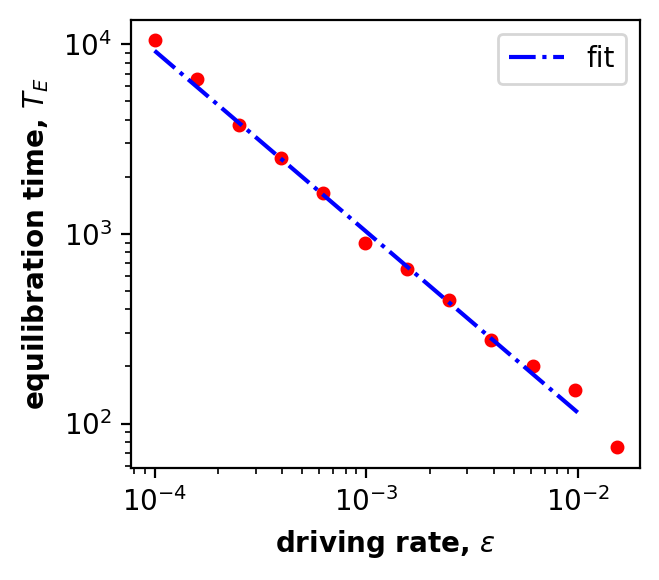

-0.9541609775085852
0.02251398792169115


In [6]:
from mpl_toolkits.axes_grid.inset_locator import (inset_axes, InsetPosition,
                                                  mark_inset)

approx_Relaxtime = [75,150,200,275,450,650,900,1650,2500,3750,6600,10500]
approx_RelaxtimeU = [50,85,90,125,210,275,500,1250,1500,3000,4500,6000]
relaxtime_eps = [0.015319, 0.009696,0.006136,0.003884,0.002458,0.001556,0.000985,0.000623,0.000394,0.000250,0.000158,0.000100]



# ============== Sakib's code to format the style of plots ============================
import matplotlib.pyplot as pp

matplotlib.rc('xtick', labelsize = 10 ) 
matplotlib.rc('ytick', labelsize = 10 )

fig, ax1 = plt.subplots(1,1, figsize =(3.4,3) )   # Figure Size in Inches
fs = 10     # Font Size
mks = 4.0   # Marker Size


# =====================================================================================


# fig, ax1 = plt.subplots(figsize=(4,4))

# These are in unitless percentages of the figure size. (0,0 is bottom left)
# left, bottom, width, height = [0.65, 0.65, 0.305, 0.305]
# ax2 = fig.add_axes([left, bottom, width, height])


ax1.plot(relaxtime_eps,approx_Relaxtime,color='red',linewidth=0,markersize = mks, marker='o',)
# ax2.plot(relaxtime_eps,approx_RelaxtimeU,color='red',linewidth=0,marker='.')
# =================================== Fitting ================================================
def func_logpowlaw(x,m,c):
    return m*x + c
end = -1
popt1,pcov1 = curve_fit(func_logpowlaw,np.log10(relaxtime_eps[2:end]),np.log10(approx_Relaxtime[2:end]))
stdDev = np.sqrt(np.diag(pcov1)[0])

xEps = np.linspace(-2,-4,100)
ax1.plot(10**xEps,10**func_logpowlaw(xEps,*popt1),
         color='blue',linestyle='-.',
#          label=r'$\nu z$ = '+ str(-1 * round(popt1[0],2)) + '$\pm$' + str(round(1.96*stdDev,2)))
         label = 'fit')
print(r'$\nu z$ = '+ str(-1 * round(popt1[0],2)) + '$\pm$' + str(round(1.96*stdDev,2)))

# popt1,pcov1 = curve_fit(func_logpowlaw,np.log10(relaxtime_eps),np.log10(approx_RelaxtimeU))
# xEps = np.linspace(-1.5,-4,100)
# ax2.plot(10**xEps,10**func_logpowlaw(xEps,*popt1),
#             color='red',label=r'$exp$='+ str(round(popt1[0],3)))
# ============================================================================================
ax1.set_yscale('log', nonposy='clip'); ax1.set_xscale('log', nonposx='clip')
ax1.set_xlabel(r'driving rate, $\varepsilon$', fontweight = 'bold', fontsize = fs )
ax1.set_ylabel(r'equilibration time, $T_{E}$', fontweight = 'bold', fontsize = fs )

ax1.legend(loc='upper right');
# ax1.grid(True)
plt.savefig('relaxTime_epsi.png', format='png', dpi=360, bbox_inches = "tight")
plt.show(fig)

print(popt1[0])
print(np.sqrt(np.diag(pcov1)[0]))

### Equilibration time for $\Delta \lambda$

In [ ]:
for i in range(87,97):
    timeString = 'brain_0xx/brain' + "{:0>2d}".format(i) + "_timeData.txt"
    savename = 'Plots/brain0xx/brain' + "{:0>2d}".format(i) + "_timeAct.png"
    print(timeString)
    actStats_G2 += activityDensityPlots(timeString, 10, 3, 100, True, savename)

In [ ]:
approx_Relaxtime = np.array([90, 400, 3600, 5500, 12000, 18500, 28000, 12000, 7500, 5000, 1000, 300, 50])
approx_RelaxtimeU = np.array([90, 120, 700, 2000, 5500, 10000, 15000, 4500, 2000, 400, 200, 100, 20])
relaxtime_lamb = np.array([0.1,0.01,0.001,0.0001,0.00001,0.000001,0,-0.000001,-0.00001,-0.0001,-0.001,-0.01,-0.1])

for i in range(84,97):
#     endList = int(float(approx_Relaxtime[i-1])*3)
    timeString = 'brain_0xx/brain' + "{:0>2d}".format(i) + "_timeData.txt"
    savename = 'Plots/brain0xx/brain' + "{:0>2d}".format(i) + "_timeActRange.png"
    actDensPlots_range(timeString, 10, 5, 250, True, savename)

In [ ]:
fig = plt.figure(figsize=(8,3)); 
grid = gridspec.GridSpec(1,2,wspace=0.4,hspace=0.3);
ax = fig.add_subplot(grid[0,0]); 
ax2 = fig.add_subplot(grid[0,1]);

ax.plot(relaxtime_lamb[:7],approx_Relaxtime[:7],color='red',linewidth=0,marker='.')
ax2.plot(relaxtime_lamb[:7],approx_RelaxtimeU[:7],color='red',linewidth=0,marker='.')

ax.plot(-1*relaxtime_lamb[7:],approx_Relaxtime[7:],color='blue',linewidth=0,marker='x')
ax2.plot(-1*relaxtime_lamb[7:],approx_RelaxtimeU[7:],color='blue',linewidth=0,marker='x')
# =================================== Fitting ================================================
def func_logpowlaw(x,m,c):
    return m*x + c
popt1,pcov1 = curve_fit(func_logpowlaw,np.log10(relaxtime_lamb[:6]),np.log10(approx_Relaxtime[:6]))
xEps = np.linspace(-1,-6,100)
ax.plot(10**xEps,10**func_logpowlaw(xEps,*popt1),
            color='red',label=r'$\Delta \lambda > 0; \ \ \exp$='+ str(round(popt1[0],3)))

popt1,pcov1 = curve_fit(func_logpowlaw,np.log10(relaxtime_lamb[:6]),np.log10(approx_RelaxtimeU[:6]))
xEps = np.linspace(-1,-6,100)
ax2.plot(10**xEps,10**func_logpowlaw(xEps,*popt1),
            color='red',label=r'$\Delta \lambda > 0; \ \exp$='+ str(round(popt1[0],3)))

popt1,pcov1 = curve_fit(func_logpowlaw,np.log10(-1*relaxtime_lamb[7:]),np.log10(approx_Relaxtime[7:]))
xEps = np.linspace(-1,-6,100)
ax.plot(10**xEps,10**func_logpowlaw(xEps,*popt1),
            color='blue',label=r'$\Delta \lambda < 0; \ \ \exp$='+ str(round(popt1[0],3)))

popt1,pcov1 = curve_fit(func_logpowlaw,np.log10(-1*relaxtime_lamb[7:]),np.log10(approx_RelaxtimeU[7:]))
xEps = np.linspace(-1,-6,100)
ax2.plot(10**xEps,10**func_logpowlaw(xEps,*popt1),
            color='blue',label=r'$\Delta \lambda < 0; \ \exp$='+ str(round(popt1[0],3)))
# ============================================================================================
ax.set_yscale('log', nonposy='clip'); ax.set_xscale('log', nonposx='clip')
ax.set_xlabel(r'propagation rate, $\Delta \lambda$ ',fontweight='bold',fontsize='large'); 
ax.set_ylabel(r'relaxation time, $t_{r}$',fontweight='bold',fontsize='large')

ax2.set_yscale('log', nonposy='clip'); ax2.set_xscale('log', nonposx='clip')
ax2.set_xlabel(r'propagation rate, $\Delta \lambda$ ',fontweight='bold',fontsize='large'); 
ax2.set_ylabel(r'relaxation time, $t_{r}$',fontweight='bold',fontsize='large')
# fig.suptitle('$N = 10^4$'+'; $\epsilon= 10^{-4}$',
#              fontweight='bold',fontsize='large')
ax.legend(fontsize='small');ax2.legend(fontsize='small')
plt.savefig('Plots/relaxTime_deltLambd.png', format='png', dpi=360, bbox_inches = "tight")
plt.show(fig)

# Comparison between constant N and G runs

In [ ]:
fig = plt.figure(figsize=(20,3)); grid = gridspec.GridSpec(1,5,wspace=0.4,hspace=0.3)
axActM = fig.add_subplot(grid[0,0]); axActUM = fig.add_subplot(grid[0,1]); axActF = fig.add_subplot(grid[0,2])
axChiS = fig.add_subplot(grid[0,3]); axChiD = fig.add_subplot(grid[0,4])

# ======= Order parameter =======
activityStats = np.asarray(actStats_G).astype(float).reshape(len(actStats_G)//4,4) 
axActM.plot(activityStats[:,0],activityStats[:,1],color='r',marker='.',label=r'const. G')
axActUM.plot(activityStats[:,0],activityStats[:,2],color='r',marker='.',label=r'const. G')
axActF.plot(activityStats[:,0],activityStats[:,3],color='r',marker='.',label=r'const. G')

activityStats = np.asarray(actStats_N).astype(float).reshape(len(actStats_N)//4,4) 
axActM.plot(activityStats[:,0],activityStats[:,1],color='b',marker='.',label=r'const. N')
axActUM.plot(activityStats[:,0],activityStats[:,2],color='b',marker='.',label=r'const. N')
axActF.plot(activityStats[:,0],activityStats[:,3],color='b',marker='.',label=r'const. N')

x = np.logspace(-6,-4,100)
axActM.plot(x,1e4*x, linestyle='--',color='grey',label=(r'$\beta = 1$'))
axActUM.plot(x,1e1*x, linestyle='--',color='grey',label=(r'$\beta = 1$'))
y = np.logspace(-4,-2,100)
axActF.plot(y,1e-9*y**(-2), linestyle='--',color='grey',label=(r'$\gamma = -2$'))

# x = np.logspace(-6,-4,100)
# axActM.plot(x,1e8*x, linestyle='--',color='grey',label=(r'$\beta = 1$'))
# axActUM.plot(x,1e5*x, linestyle='--',color='grey',label=(r'$\beta = 1$'))
# y = np.logspace(-4,-1,100)
# axActF.plot(y,10**(-0.5)*y**(-2), linestyle='--',color='grey',label=(r'$\gamma = -2$'))

axActM.set_yscale('log', nonposy='clip'); axActM.set_xscale('log', nonposx='clip')
axActUM.set_yscale('log', nonposy='clip'); axActUM.set_xscale('log', nonposx='clip')
axActF.set_yscale('log', nonposy='clip'); axActF.set_xscale('log', nonposx='clip')

axActM.set_xlabel(r'$\epsilon$',fontweight='bold',fontsize='large'); axActUM.set_xlabel(r'$\epsilon$',fontweight='bold',fontsize='large'); axActF.set_xlabel(r'$\epsilon$',fontweight='bold',fontsize='large')
axActM.set_ylabel(r'$\langle \rho \rangle$ - activity',fontweight='bold'); axActUM.set_ylabel(r'$\langle u \rangle$ - unique clusters',fontweight='bold'); axActF.set_ylabel(r'$\delta \rho$ - activity fluctuations',fontweight='bold')

# ======= Response Functions =======
chiArray = np.asarray(chiList_G).astype(float).reshape(len(chiList_G)//3,3)
axChiS.plot(chiArray[:,0],chiArray[:,1],color='r',marker='.',label=r'const. G')
axChiD.plot(chiArray[:,0],chiArray[:,2],color='r',marker='.',label=r'const. G')

chiArray = np.asarray(chiList_N).astype(float).reshape(len(chiList_N)//3,3)
axChiS.plot(chiArray[:,0],chiArray[:,1],color='b',marker='.',label=r'const. N')
axChiD.plot(chiArray[:,0],chiArray[:,2],color='b',marker='.',label=r'const. N')

x = np.logspace(-4,-1,100)
axChiS.plot(x,1*(x**-2), linestyle='--',color='grey',label=(r'$\gamma = -2$'))
axChiD.plot(x,10**(0.5)*x**(-3/4), linestyle='--',color='grey',label=(r'exp $= -3/4$'))

axChiS.set_yscale('log', nonposy='clip'); axChiS.set_xscale('log', nonposx='clip')
axChiD.set_yscale('log', nonposy='clip'); axChiD.set_xscale('log', nonposx='clip')

axChiS.set_xlabel(r'$\epsilon$',fontweight='bold',fontsize='large'); axChiD.set_xlabel(r'$\epsilon$',fontweight='bold',fontsize='large')
axChiS.set_ylabel(r'$\chi_s$ - mean cluster size',fontweight='bold'); axChiD.set_ylabel(r'$\chi_t$ - mean cluster duration',fontweight='bold')

# ======= Legend and showing =======

axChiS.legend(); axChiD.legend(); axActM.legend(); axActUM.legend(); axActF.legend()
# axActF.set_title('$\lambda=$'+str(parts[2])+'; $\mu=$'+str(parts[3]+'; $\kappa=$'+str(parts[4])),fontweight='bold',fontsize='large')
plt.savefig('Plots/epsilon_response_RW.png', format='png', dpi=300)
plt.show(fig)

# Measuring $\alpha$ exponenet from DP

if we start with a fully occupied lattice at the critical bond probability, $p=p_c$, the density of active sites (particles) decays like
\begin{equation}
\rho(t) \sim t^{-\alpha}
\end{equation}
where $\alpha = \beta / \nu^\parallel$. 

In [21]:
def activityDensityPlots(filename, width, length, bins, save, savename):
    """
    Inputs: 
        - filename: of the brainXXXX_timeData.txt
        - width, length: end plot
        - show (Boolean): save plot iff True
        - savename: path to save file to
   
    Returns:
        - Fluctuations in activity density, $\sigma(\rho)$
        - (if show==True) Plot of density of activity as a function of time:
        - $$ \rho(t) \equiv \frac{1}{N} \sum_n A_k$$
    """
    # ---------- Open and read in timeData file ----------
    text_file = open("Data/" + filename, "r")
    lines = []
    for line in open("Data/" + filename, "r"):
        lines += [line]
    lines = text_file.read().split('\n')
    eventList = lines[3:]
    
    neuralAvalancheStr = []
    neuralAvalancheData = []
    
    # ---------- Make lists from all the data ----------
    for i in range(len(eventList)):
        tempstr = eventList[i]
        neuralAvalancheStr += [tempstr.split(' ')]
        while '' in neuralAvalancheStr[-1]:
            neuralAvalancheStr[-1].remove('')
        for j in range(len(neuralAvalancheStr[-1])):
            neuralAvalancheData.append(int(neuralAvalancheStr[-1][j]))
    activityDensity = np.asarray(neuralAvalancheData).reshape(len(neuralAvalancheData)//3,3)

    # ---------- Create a list of the parameters ----------
    unNormedParts = lines[2].split(' ')    # Get rid of spaces in strings
    while '' in unNormedParts:
        unNormedParts.remove('')
    parts = [int(unNormedParts[0])]        # Make the parameters look pretty
    for i in range(len(unNormedParts)-1):
        parts += [str(round(float(unNormedParts[i+1]),8))]
    activityDensity = activityDensity.astype(float)
#     activityDensity[:,1] /= parts[0]
    
    # ---------- Make plots (Main - Histogram; Side - Activity time series) ----------
    fig = plt.figure(figsize=(width,length)); grid = gridspec.GridSpec(3,16,wspace=0.5,hspace=0.4)
    ax2 = fig.add_subplot(grid[0,:]) # Active Sites vs. Time
    ax3 = fig.add_subplot(grid[1,:]) # Unique Clusters vs. Time
    ax4 = fig.add_subplot(grid[2,:]) # avg Cluster Size vs. Time

    ax2.plot(activityDensity[:,0],activityDensity[:,1],label=r'$\rho$',linewidth=0.5,color='red')
    ax2.set_xlabel(r'time - $t$',fontsize='large'); ax2.set_ylabel(r'$\rho$',fontsize='large')
    
    ax4.plot(activityDensity[:,0],activityDensity[:,1]/activityDensity[:,2],linewidth=0.5,color='red')
    ax4.set_xlabel(r'time - $t$',fontsize='large'); ax4.set_ylabel(r'$\rho / U$',fontsize='large')
    # =================================== Fitting ================================================
    def func_logpowlaw(x,m,c):
        return m*x + c
    popt1,pcov1 = curve_fit(func_logpowlaw,np.log10(activityDensity[10:10000,0]),np.log10(activityDensity[10:10000,1]/activityDensity[10:10000,2]))
    xEps = np.linspace(1,4,100)
    ax4.plot(10**xEps,10**func_logpowlaw(xEps,*popt1),
                color='blue',label=r'$exp$='+ str(round(popt1[0],3)))
    # ============================================================================================
    

    ax3.plot(activityDensity[:,0],activityDensity[:,2],linewidth=0.5,color='red')
    ax3.set_xlabel(r'time - $t$',fontsize='large'); ax3.set_ylabel(r'$u$',fontsize='x-large')
    # =================================== Fitting ================================================
    def func_logpowlaw(x,m,c):
        return m*x + c
    popt1,pcov1 = curve_fit(func_logpowlaw,np.log10(activityDensity[10:10000,0]),np.log10(activityDensity[10:10000,2]))
    xEps = np.linspace(1,4,100)
    ax3.plot(10**xEps,10**func_logpowlaw(xEps,*popt1),
                color='blue',label=r'$exp$='+ str(round(popt1[0],3)))
    # ============================================================================================

    ax2.set_yscale('log', nonposy='clip'); ax2.set_xscale('log', nonposx='clip')
    ax3.set_yscale('log', nonposy='clip'); ax3.set_xscale('log', nonposx='clip')
    ax4.set_yscale('log', nonposy='clip'); ax4.set_xscale('log', nonposx='clip')
    ax3.legend()
    ax4.legend()
    
    ax2.tick_params('both')
    ax2.set_title('$N = $'+str(parts[0])+'$; \epsilon=$'+str(parts[1])+'; $\delta\lambda=$'+str(parts[2])+'; $\mu=$'+str(parts[3])+'; T='+str(parts[4]),fontweight='bold',fontsize='large')
    if save == True:
        fig.savefig(savename,dpi=300,bbox_inches = "tight")
        plt.close(fig)
    else:
        plt.show(fig)

In [22]:
def activityAdding(filename, width, length, bins, save, savename):
    """
    Inputs: 
        - filename: of the brainXXXX_timeData.txt
        - width, length: end plot
        - show (Boolean): save plot iff True
        - savename: path to save file to
   
    Returns:
        - Fluctuations in activity density, $\sigma(\rho)$
        - (if show==True) Plot of density of activity as a function of time:
        - $$ \rho(t) \equiv \frac{1}{N} \sum_n A_k$$
    """
    # ---------- Open and read in timeData file ----------
#     if os.path.exists("test_file.txt"):        #finding bad lines
#       os.remove("test_file.txt")               #finding bad lines
#     f= open("test_file.txt","w+")              #finding bad lines

    text_file = open("Data/" + filename, "r")
    lines = []
    for line in open("Data/" + filename, "r"):
        if '^@' in line:
            5
        else:
            lines += [line]
        
    lines = text_file.read().split('\n')
    eventList = lines[3:]
    
    neuralAvalancheStr = []
    neuralAvalancheData = []
    
    # ---------- Make lists from all the data ----------
    for i in range(len(eventList)):
        tempstr = eventList[i]
        neuralAvalancheStr += [tempstr.split(' ')]
        while '' in neuralAvalancheStr[-1]:
            neuralAvalancheStr[-1].remove('')
        for j in range(len(neuralAvalancheStr[-1])):
#             f.write(str(i)+', '+str(neuralAvalancheStr[-1][j])+'\n')                            #finding bad lines
            neuralAvalancheData.append(int(neuralAvalancheStr[-1][j]))
    activityDensity = np.asarray(neuralAvalancheData).reshape(len(neuralAvalancheData)//3,3)

    # ---------- Create a list of the parameters ----------
    unNormedParts = lines[2].split(' ')    # Get rid of spaces in strings
    while '' in unNormedParts:
        unNormedParts.remove('')
    parts = [int(unNormedParts[0])]        # Make the parameters look pretty
    for i in range(len(unNormedParts)-1):
        parts += [str(round(float(unNormedParts[i+1]),8))]
    activityDensity = activityDensity.astype(float)
    
    return activityDensity, parts


def plotActivity(activityDensity, width, length, bins, save, savename,parts):
    
    # ---------- Make plots (Main - Histogram; Side - Activity time series) ----------
    fig = plt.figure(figsize=(width,length)); grid = gridspec.GridSpec(16,3,wspace=0.25,hspace=0.2)
    ax2 = fig.add_subplot(grid[:,0]) # Active Sites vs. Time
    ax3 = fig.add_subplot(grid[:,1]) # Unique Clusters vs. Time
    ax4 = fig.add_subplot(grid[:,2]) # avg Cluster Size vs. Time

    ax2.plot(activityDensity[:,0],activityDensity[:,1],label=r'$\rho$',linewidth=0.5,color='red')
    ax2.set_xlabel(r'time - $t$',fontsize='large'); ax2.set_ylabel(r'$\rho$',fontsize='large')
    
    ax4.plot(activityDensity[:,0],activityDensity[:,1]/activityDensity[:,2],linewidth=0.5,color='red')
    ax4.set_xlabel(r'time - $t$',fontsize='large'); ax4.set_ylabel(r'$\rho / U$',fontsize='large')
    # =================================== Fitting ================================================
    def func_logpowlaw(x,m,c):
        return m*x + c
    popt1,pcov1 = curve_fit(func_logpowlaw,np.log10(activityDensity[10:10000,0]),np.log10(activityDensity[10:10000,1]/activityDensity[10:10000,2]))
    xEps = np.linspace(1,4,100)
    ax4.plot(10**xEps,10**func_logpowlaw(xEps,*popt1),
                color='blue',label=r'$exp$='+ str(round(popt1[0],3)))
    # ============================================================================================
    

    ax3.plot(activityDensity[:,0],activityDensity[:,2],linewidth=0.5,color='red')
    ax3.set_xlabel(r'time - $t$',fontsize='large'); ax3.set_ylabel(r'$u$',fontsize='x-large')
    # =================================== Fitting ================================================
    def func_logpowlaw(x,m,c):
        return m*x + c
    popt1,pcov1 = curve_fit(func_logpowlaw,np.log10(activityDensity[10:10000,0]),np.log10(activityDensity[10:10000,2]))
    xEps = np.linspace(1,4,100)
    ax3.plot(10**xEps,10**func_logpowlaw(xEps,*popt1),
                color='blue',label=r'$exp$='+ str(round(popt1[0],3)))
    # ============================================================================================

    ax2.set_yscale('log', nonposy='clip'); ax2.set_xscale('log', nonposx='clip')
    ax3.set_yscale('log', nonposy='clip'); ax3.set_xscale('log', nonposx='clip')
    ax4.set_yscale('log', nonposy='clip'); ax4.set_xscale('log', nonposx='clip')
    ax3.legend()
    ax4.legend()
    
#     ax2.tick_params('both')
    ax3.set_title('$N = $'+str(parts[0])+'$; \epsilon=$'+str(parts[1])+'; $\delta \lambda=$'+str(parts[2])+'; $\mu=$'+str(parts[3])+'; T='+str(parts[4]),fontweight='bold',fontsize='large')
    if save == True:
        fig.savefig(savename,dpi=300,bbox_inches = "tight")
        plt.close(fig)
    else:
        plt.show(fig)

In [ ]:
startIndex = [3]#,8,13,18,23,28]
# for start in startIndex:
start = 3
timeString = 'brain_2xx/brain2' + "{:0>2d}".format(start) + "_timeData.txt"
savename = 'Plots/brain2xx/brain2' + "{:0>2d}".format(start) + "_timeAct.png"
activity, parts = activityAdding(timeString, 4, 9, 100, True, savename)
activityDensityPlots(timeString, 4, 9, 100, True, savename)

for i in range(start+1 ,start+5):
    print(i)
    timeString = 'brain_2xx/brain2' + "{:0>2d}".format(i) + "_timeData.txt"
    savename = 'Plots/brain2xx/brain2' + "{:0>2d}".format(i) + "_timeAct.png"
    activity += activityAdding(timeString, 4, 9, 100, True, savename)[0]
    activityDensityPlots(timeString, 4, 9, 100, True, savename)

# savename = 'Plots/brain2xx/brainAvg_2' + "{:0>2d}".format(start) + '_2' + "{:0>2d}".format(i) + '.png'
plotActivity(activity/5, 15, 3, 1, False, savename,parts)

In [23]:
def activityAdding(filename, width, length, bins, save, savename):
    """
    Inputs: 
        - filename: of the brainXXXX_timeData.txt
        - width, length: end plot
        - show (Boolean): save plot iff True
        - savename: path to save file to
   
    Returns:
        - Fluctuations in activity density, $\sigma(\rho)$
        - (if show==True) Plot of density of activity as a function of time:
        - $$ \rho(t) \equiv \frac{1}{N} \sum_n A_k$$
    """
    # ---------- Open and read in timeData file ----------
#     if os.path.exists("test_file.txt"):        #finding bad lines
#       os.remove("test_file.txt")               #finding bad lines
#     f= open("test_file.txt","w+")              #finding bad lines

    text_file = open("Data/" + filename, "r")
    lines = []
    for line in open("Data/" + filename, "r"):
        if '^@' in line:
            5
        else:
            lines += [line]
        
    lines = text_file.read().split('\n')
    eventList = lines[3:]
    
    neuralAvalancheStr = []
    neuralAvalancheData = []
    
    # ---------- Make lists from all the data ----------
    for i in range(len(eventList)):
        tempstr = eventList[i]
        neuralAvalancheStr += [tempstr.split(' ')]
        while '' in neuralAvalancheStr[-1]:
            neuralAvalancheStr[-1].remove('')
        for j in range(len(neuralAvalancheStr[-1])):
#             f.write(str(i)+', '+str(neuralAvalancheStr[-1][j])+'\n')                            #finding bad lines
            neuralAvalancheData.append(int(neuralAvalancheStr[-1][j]))
    activityDensity = np.asarray(neuralAvalancheData).reshape(len(neuralAvalancheData)//3,3)

    # ---------- Create a list of the parameters ----------
    rawparts = [lines[0],lines[1],lines[2]]
    unNormedParts = lines[2].split(' ')    # Get rid of spaces in strings
    while '' in unNormedParts:
        unNormedParts.remove('')
    parts = [int(unNormedParts[0])]        # Make the parameters look pretty
    for i in range(len(unNormedParts)-1):
        parts += [str(round(float(unNormedParts[i+1]),8))]
    activityDensity = activityDensity.astype(float)
    
    return activityDensity, parts, rawparts

# ============================================================================================================
# ============================================================================================================
# ============================================================================================================

def plotActivity(activityDensity, width, length, bins, save, savename,parts):
    
    # ---------- Make plots (Main - Histogram; Side - Activity time series) ----------
    fig = plt.figure(figsize=(width,length)); grid = gridspec.GridSpec(9,3,wspace=0.3,hspace=0.4)
    ax2 = fig.add_subplot(grid[:7,0]) # Active Sites vs. Time
    ax3 = fig.add_subplot(grid[:7,1]) # Unique Clusters vs. Time
    ax4 = fig.add_subplot(grid[:7,2]) # avg Cluster Size vs. Time
    
    ax21 = fig.add_subplot(grid[-1,0]) # Active Sites vs. Time
    ax31 = fig.add_subplot(grid[-1,1]) # Unique Clusters vs. Time
    ax41 = fig.add_subplot(grid[-1,2]) # avg Cluster Size vs. Time

    ax2.plot(activityDensity[:,0],activityDensity[:,1],label=r'$\rho$',linewidth=0.5,color='red')
    ax2.set_xlabel(r'time - $t$',fontsize='large'); ax2.set_ylabel(r'$\rho$',fontsize='large')
    
    ax4.plot(activityDensity[:,0],activityDensity[:,1]/activityDensity[:,2],linewidth=0.5,color='red')
    ax4.set_xlabel(r'time - $t$',fontsize='large'); ax4.set_ylabel(r'$\rho / U$',fontsize='large')
    
    ax21.plot(activityDensity[:,0],activityDensity[:,1],label=r'$\rho$',linewidth=0.5,color='red')
    ax21.set_xlabel(r'time - $t$',fontsize='large'); ax2.set_ylabel(r'$\rho$',fontsize='large')
    ax41.plot(activityDensity[:,0],activityDensity[:,1]/activityDensity[:,2],linewidth=0.5,color='red')
    ax41.set_xlabel(r'time - $t$',fontsize='large'); ax4.set_ylabel(r'$\rho / U$',fontsize='large')
    
    # =================================== Fitting ================================================
    def func_logpowlaw(x,m,c):
        return m*x + c
    popt1,pcov1 = curve_fit(func_logpowlaw,np.log10(activityDensity[10:10000,0]),np.log10(activityDensity[10:10000,1]/activityDensity[10:10000,2]))
    xEps = np.linspace(1,4,100)
    ax4.plot(10**xEps,10**func_logpowlaw(xEps,*popt1),
                color='blue',label=r'$exp$='+ str(round(popt1[0],3)))
    # ============================================================================================
    

    ax3.plot(activityDensity[:,0],activityDensity[:,2],linewidth=0.5,color='red')
    ax3.set_xlabel(r'time - $t$',fontsize='large'); ax3.set_ylabel(r'$u$',fontsize='x-large')
    
    ax31.plot(activityDensity[:,0],activityDensity[:,2],linewidth=0.5,color='red')
    ax31.set_xlabel(r'time - $t$',fontsize='large'); ax3.set_ylabel(r'$u$',fontsize='x-large')
    # =================================== Fitting ================================================
    def func_logpowlaw(x,m,c):
        return m*x + c
    popt1,pcov1 = curve_fit(func_logpowlaw,np.log10(activityDensity[10:10000,0]),np.log10(activityDensity[10:10000,2]))
    xEps = np.linspace(1,4,100)
    ax3.plot(10**xEps,10**func_logpowlaw(xEps,*popt1),
                color='blue',label=r'$exp$='+ str(round(popt1[0],3)))
    # ============================================================================================

    ax2.set_yscale('log', nonposy='clip'); ax2.set_xscale('log', nonposx='clip')
    ax3.set_yscale('log', nonposy='clip'); ax3.set_xscale('log', nonposx='clip')
    ax4.set_yscale('log', nonposy='clip'); ax4.set_xscale('log', nonposx='clip')
    ax3.legend()
    ax4.legend()
    
#     ax2.tick_params('both')
    ax3.set_title('$N = $'+str(parts[0])+'$; \epsilon=$'+str(parts[1])+'; $\delta \lambda=$'+str(parts[2])+'; $\mu=$'+str(parts[3])+'; T='+str(parts[4]),fontweight='bold',fontsize='large')
    if save == True:
        fig.savefig(savename,dpi=300,bbox_inches = "tight")
        plt.close(fig)
    else:
        plt.show(fig)

# ============================================================================================================
# ============================================================================================================
# ============================================================================================================

startIndex = np.arange(300,400,10)
for start in startIndex:
    timeString = 'brain_102xx/brain10' + "{:0>2d}".format(start) + "_timeData.txt"; print(timeString)
    savename = 'Plots/brain102xx/brain2' + "{:0>2d}".format(start) + "_timeAct.png"
    activity, parts, rawparts = activityAdding(timeString, 4, 9, 100, True, savename)
    plotActivity(activity, 12, 4, 100, True, savename, parts)

    for i in range(start+1 ,start+10):
        timeString = 'brain_102xx/brain10' + "{:0>2d}".format(i) + "_timeData.txt"; print(timeString)
        savename = 'Plots/brain2xx/brain2' + "{:0>2d}".format(i) + "_timeAct.png"
        activityStep = activityAdding(timeString, 4, 9, 100, True, savename)[0]
        activity += activityStep
        plotActivity(activityStep, 12, 4, 100, True, savename, parts)

#     activity /= 10

#     filename = 'brainAvg_10' + "{:0>1d}".format(start) + 'x.txt'
#     f= open(filename,"w+")
#     for string in rawparts:
#         f.writelines([string, '\n'])

#     for t in range(len(activity[:,0])):
#         f.writelines([str(int(activity[t,0])), '      ', str(activity[t,1]), '       ', str(activity[t,2]), '\n'])

#     f.close()

brain_102xx/brain10300_timeData.txt


KeyboardInterrupt: 

In [126]:
np.arange(200,410,10)

array([200, 210, 220, 230, 240, 250, 260, 270, 280, 290, 300, 310, 320,
       330, 340, 350, 360, 370, 380, 390, 400])

In [ ]:
def func_logpowlaw(x,m,c):
    return m*x + c

def find_zeroIndex(array):
    for i in range(len(array)):
        if array[i]==0:
            return i-1
    return len(array)-1
    
fig = plt.figure(figsize=(30,8)); grid = gridspec.GridSpec(16,3,wspace=0.2,hspace=0.2)
ax2 = fig.add_subplot(grid[:,0]) # Active Sites vs. Time
ax3 = fig.add_subplot(grid[:,1]) # Unique Clusters vs. Time
ax4 = fig.add_subplot(grid[:,2]) # avg Cluster Size vs. Time

color_list = np.array([[111,49,55],
[152,52,45],
[223,66,59],
[211,134,120],
[210,114,50],
[126,90,44],
[207,157,60],
[170,166,103],
[164,183,56],
[84,140,50],
[86,116,66],
[45,72,33],
[86,196,68],
[91,186,128],
[81,169,165],
[100,143,191],
[115,111,210],
[109,57,193],
[92,57,112],
[205,77,197],
[198,137,184],
[199,67,125]])/255
cp = -1

plotSeeds= np.arange(1,23)
for i in plotSeeds:
    print('starting i=' + str(i))
    cp +=1
    timeString = 'brain_1xx/brain1' + "{:0>2d}".format(i) + "_timeData.txt"
    savename = 'Plots/brain1xx/brain1' + "{:0>2d}".format(i) + "_timeAct.png"
    activityDensityPlots(timeString, 4, 9, 100, True, savename)
    activityDensity,parts = activityAdding(timeString, 4, 9, 100, True, savename)
    
    ax2.plot(activityDensity[:,0],activityDensity[:,1],label=r'$\epsilon=$'+str(round(float(parts[1]),6)),
             linewidth=1.5,color=color_list[cp])
    ax4.plot(activityDensity[:,0],activityDensity[:,1]/activityDensity[:,2],label=r'$\epsilon=$'+str(round(float(parts[1]),6)),
             linewidth=1.5,color=color_list[cp])
    
#     # =================================== Fitting ================================================
#     endFit = find_zeroIndex(activityDensity[:,1]); print(endFit)
#     popt1,pcov1 = curve_fit(func_logpowlaw,np.log10(activityDensity[10:endFit,0]),np.log10(activityDensity[10:endFit,1]/activityDensity[10:endFit,2]))
#     xEps = np.linspace(1,np.log10(endFit),100)
#     ax4.plot(10**xEps,10**func_logpowlaw(xEps,*popt1),
#                 color='blue',label=r'$exp$='+ str(round(popt1[0],3)))
#     # ============================================================================================


    ax3.plot(activityDensity[:,0],activityDensity[:,2],label=r'$\epsilon=$'+str(round(float(parts[1]),6)),
             linewidth=1.5,color=color_list[cp])
#     # =================================== Fitting ================================================
#     popt1,pcov1 = curve_fit(func_logpowlaw,np.log10(activityDensity[10:endFit,0]),np.log10(activityDensity[10:endFit,2]))
#     xEps = np.linspace(1,np.log10(endFit),100)
#     ax3.plot(10**xEps,10**func_logpowlaw(xEps,*popt1),
#                 color='blue',label=r'$exp$='+ str(round(popt1[0],3)))
#     # ============================================================================================

ax2.set_ylim(top=10**6.1,bottom=10**4)
ax2.set_xlabel(r'time - $t$',fontsize='large'); ax2.set_ylabel(r'$\rho$',fontsize='large')
ax4.set_xlabel(r'time - $t$',fontsize='large'); ax4.set_ylabel(r'$\rho / U$',fontsize='large')
ax3.set_xlabel(r'time - $t$',fontsize='large'); ax3.set_ylabel(r'$u$',fontsize='x-large')
ax2.set_yscale('log', nonposy='clip'); ax2.set_xscale('log', nonposx='clip')
ax3.set_yscale('log', nonposy='clip'); ax3.set_xscale('log', nonposx='clip')
ax4.set_yscale('log', nonposy='clip'); ax4.set_xscale('log', nonposx='clip')
ax2.legend();
ax3.legend(); 
ax4.legend()

ax2.tick_params('both')
ax3.set_title('$N = $'+str(parts[0])+'$; \delta \lambda = 0 $' + '; $\mu=$'+str(parts[3]),fontweight='bold',fontsize='large')
savename = 'Plots/brain1xx/epsi_timeStats.png'
fig.savefig(savename,dpi=450,bbox_inches = "tight")
plt.show(fig)

starting i=90


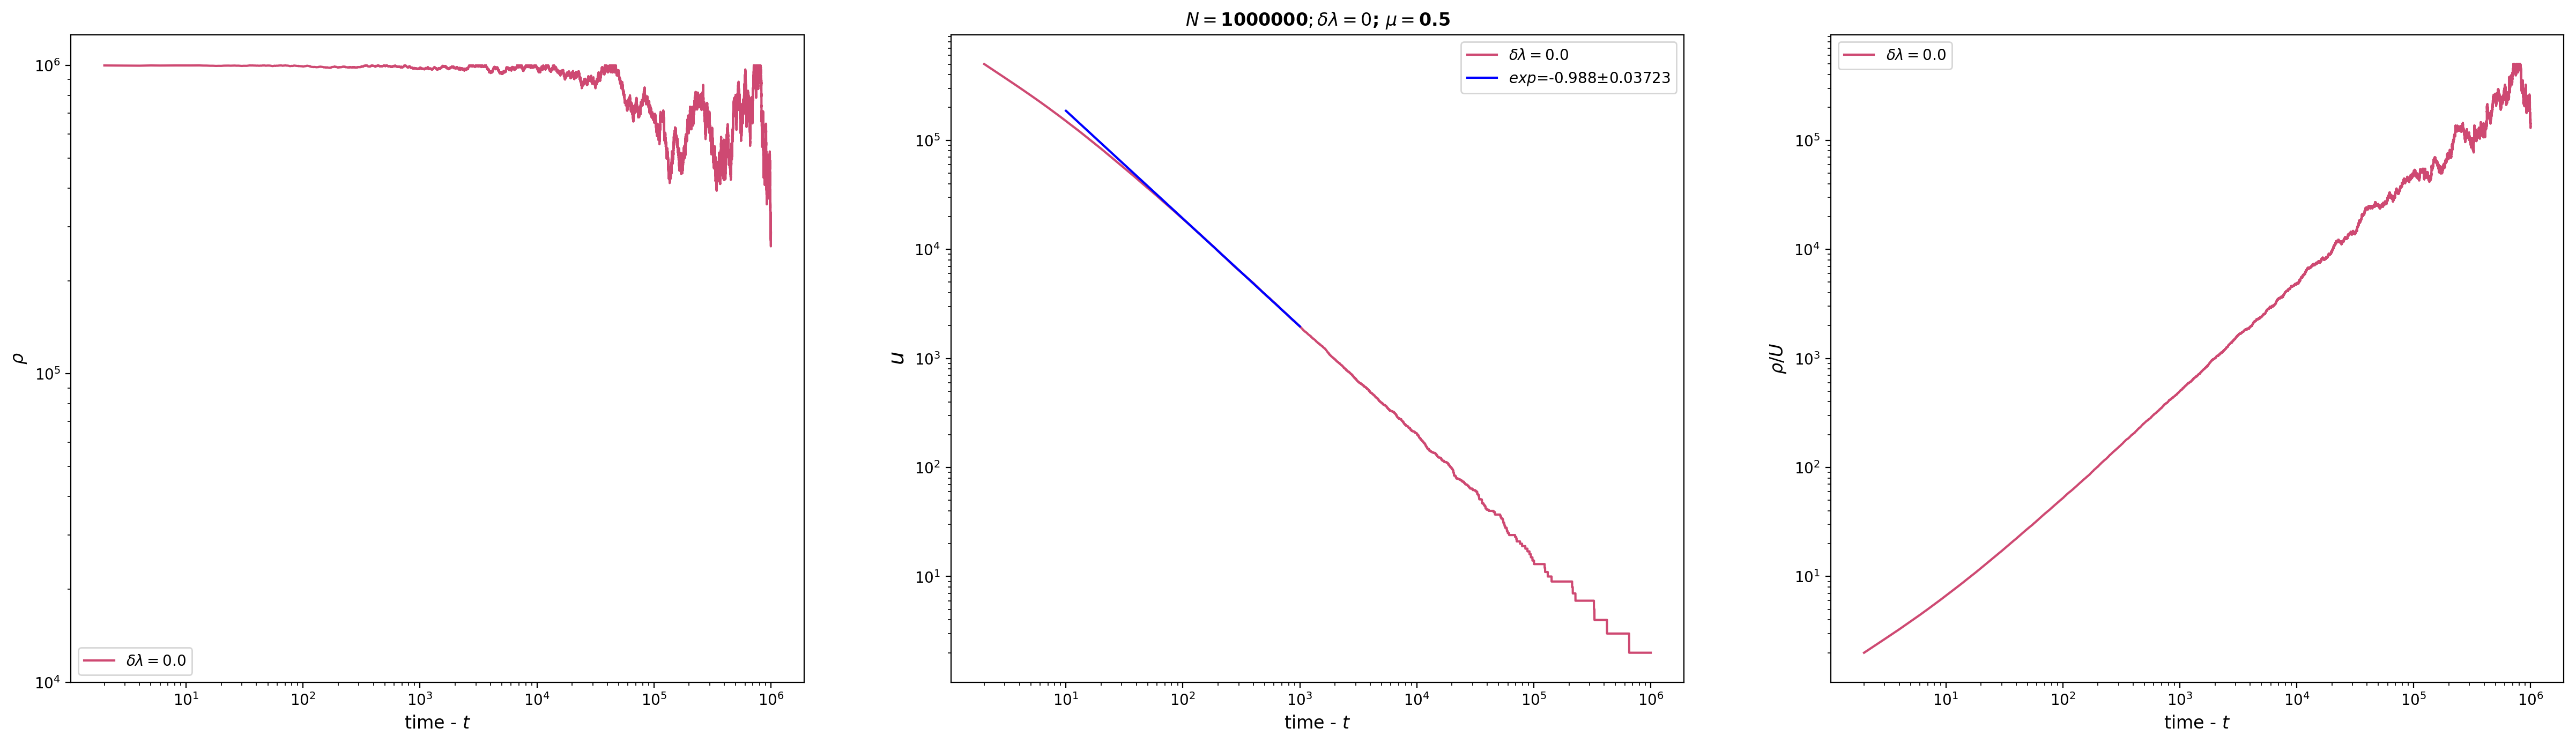

In [41]:
def func_logpowlaw(x,m,c):
    return m*x + c

def find_zeroIndex(array):
    for i in range(len(array)):
        if array[i]==0:
            return i-1
    return len(array)-1
    
fig = plt.figure(figsize=(30,8)); grid = gridspec.GridSpec(16,3,wspace=0.2,hspace=0.2)
ax2 = fig.add_subplot(grid[:,0]) # Active Sites vs. Time
ax3 = fig.add_subplot(grid[:,1]) # Unique Clusters vs. Time
ax4 = fig.add_subplot(grid[:,2]) # avg Cluster Size vs. Time

color_list = np.array([[206,73,114],
[130,65,49],
[214,79,51],
[203,143,80],
[164,170,66],
[76,100,49],
[89,185,73],
[97,175,146],
[99,140,194],
[104,74,195],
[98,54,105],
[201,77,196],
[199,136,181]])/255
cp = -1

# plotSeeds= [89,88,87,86,85,84,90,96,95,94,93,92,91]
plotSeeds = [90]
for i in plotSeeds:
    print('starting i=' + str(i))
    cp +=1
    timeString = 'brain_2xx/brain2' + "{:0>2d}".format(i) + "_timeData.txt"
    savename = 'Plots/brain2xx/brain2' + "{:0>2d}".format(i) + "_timeAct.png"
#     activityDensityPlots(timeString, 4, 9, 100, True, savename)
    activityDensity,parts = activityAdding(timeString, 4, 9, 100, True, savename)
    
    ax2.plot(activityDensity[:,0],activityDensity[:,1],label=r'$\delta \lambda=$'+str(round(float(parts[2])-float(parts[3]),6)),
             linewidth=1.5,color=color_list[cp])
    ax4.plot(activityDensity[:,0],activityDensity[:,1]/activityDensity[:,2],label=r'$\delta \lambda=$'+str(round(float(parts[2])-float(parts[3]),6)),
             linewidth=1.5,color=color_list[cp])
    
#     # =================================== Fitting ================================================
#     endFit = find_zeroIndex(activityDensity[:,1]); print(endFit)
#     popt1,pcov1 = curve_fit(func_logpowlaw,np.log10(activityDensity[10:endFit,0]),np.log10(activityDensity[10:endFit,1]/activityDensity[10:endFit,2]))
#     xEps = np.linspace(1,np.log10(endFit),100)
#     ax4.plot(10**xEps,10**func_logpowlaw(xEps,*popt1),
#                 color='blue',label=r'$exp$='+ str(round(popt1[0],3)))
#     # ============================================================================================


    ax3.plot(activityDensity[:,0],activityDensity[:,2],label=r'$\delta \lambda=$'+str(round(float(parts[2])-float(parts[3]),6)),
             linewidth=1.5,color=color_list[cp])
#     # =================================== Fitting ================================================
    endFit = 1000
    popt1,pcov1 = curve_fit(func_logpowlaw,np.log10(activityDensity[100:endFit,0]),np.log10(activityDensity[100:endFit,2]))
    xEps = np.linspace(1,np.log10(endFit),100)
    ax3.plot(10**xEps,10**func_logpowlaw(xEps,*popt1),
                color='blue',label=r'$exp$='+ str(round(popt1[0],3)) + '$\pm$' + str(round(1.96*stdDev,5)))
#     # ============================================================================================

ax2.set_ylim(top=10**6.1,bottom=10**4)
ax2.set_xlabel(r'time - $t$',fontsize='large'); ax2.set_ylabel(r'$\rho$',fontsize='large')
ax4.set_xlabel(r'time - $t$',fontsize='large'); ax4.set_ylabel(r'$\rho / U$',fontsize='large')
ax3.set_xlabel(r'time - $t$',fontsize='large'); ax3.set_ylabel(r'$u$',fontsize='x-large')
ax2.set_yscale('log', nonposy='clip'); ax2.set_xscale('log', nonposx='clip')
ax3.set_yscale('log', nonposy='clip'); ax3.set_xscale('log', nonposx='clip')
ax4.set_yscale('log', nonposy='clip'); ax4.set_xscale('log', nonposx='clip')
ax2.legend();
ax3.legend(); 
ax4.legend()

ax2.tick_params('both')
ax3.set_title('$N = $'+str(parts[0])+'$; \delta \lambda = 0 $' + '; $\mu=$'+str(parts[3]),fontweight='bold',fontsize='large')
savename = 'Plots/brain102xx/deltaLambd_timeStats.png'
# fig.savefig(savename,dpi=450,bbox_inches = "tight")
plt.show(fig)

In [ ]:
color_list = np.array([[245,149,146],
[255,213,197],
[255,204,155],
[190,171,147],
[189,169,132],
[217,203,128],
[243,255,177],
[240,255,198],
[144,223,170],
[120,219,179],
[207,255,238],
[169,255,236],
[122,183,171],
[74,206,188],
[173,216,210],
[72,188,186],
[31,201,206],
[141,245,255],
[137,178,193],
[57,200,245],
[158,226,255],
[255,194,240]])/255
print(color_list)

In [13]:
def gen_log_space(limit, n):
    result = [1]
    if n>1:  # just a check to avoid ZeroDivisionError
        ratio = (float(limit)/result[-1]) ** (1.0/(n-len(result)))
    while len(result)<n:
        next_value = result[-1]*ratio
        if next_value - result[-1] >= 1:
            # safe zone. next_value will be a different integer
            result.append(next_value)
        else:
            # problem! same integer. we need to find next_value by artificially incrementing previous value
            result.append(result[-1]+1)
            # recalculate the ratio so that the remaining values will scale correctly
            ratio = (float(limit)/result[-1]) ** (1.0/(n-len(result)))
    # round, re-adjust to 0 indexing (i.e. minus 1) and return np.uint64 array
    return np.array(list(map(lambda x: round(x)-1, result)), dtype=np.uint64)

y = gen_log_space(2000,50)
print(y)

[   0    1    2    3    4    5    6    7    8    9   11   13   14   17
   19   22   25   29   33   38   43   49   56   65   74   84   96  110
  125  143  164  187  213  243  277  316  361  412  470  536  612  698
  796  908 1035 1181 1347 1537 1753 1999]


starting i=10


ValueError: too many values to unpack (expected 2)

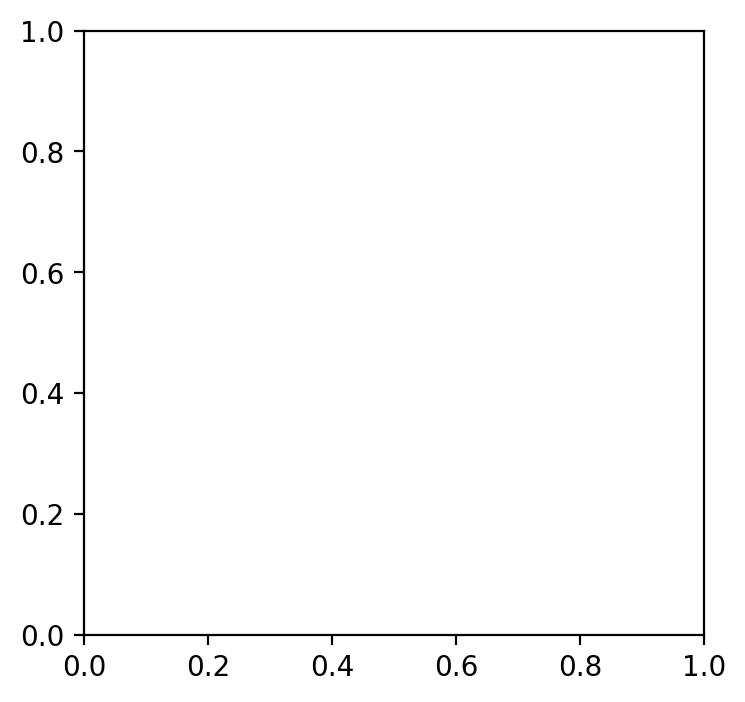

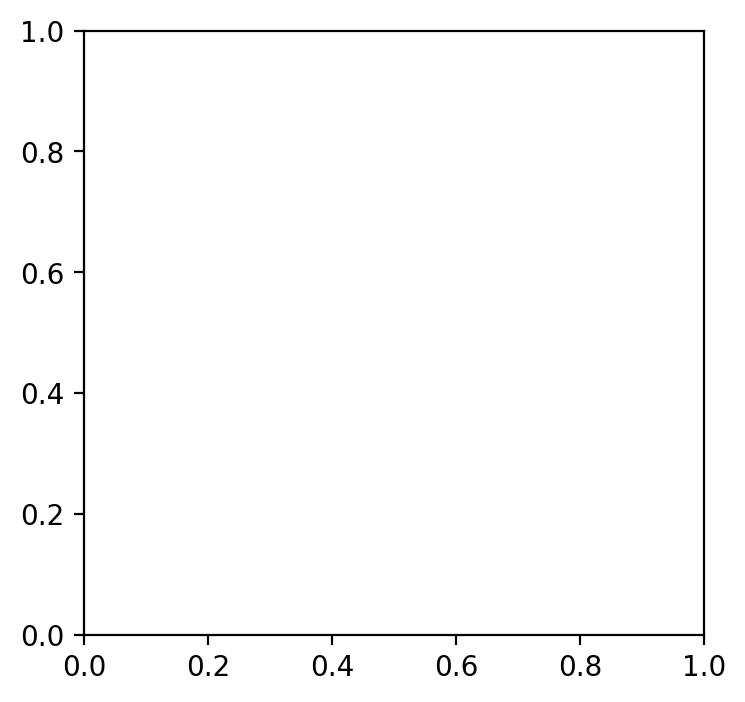

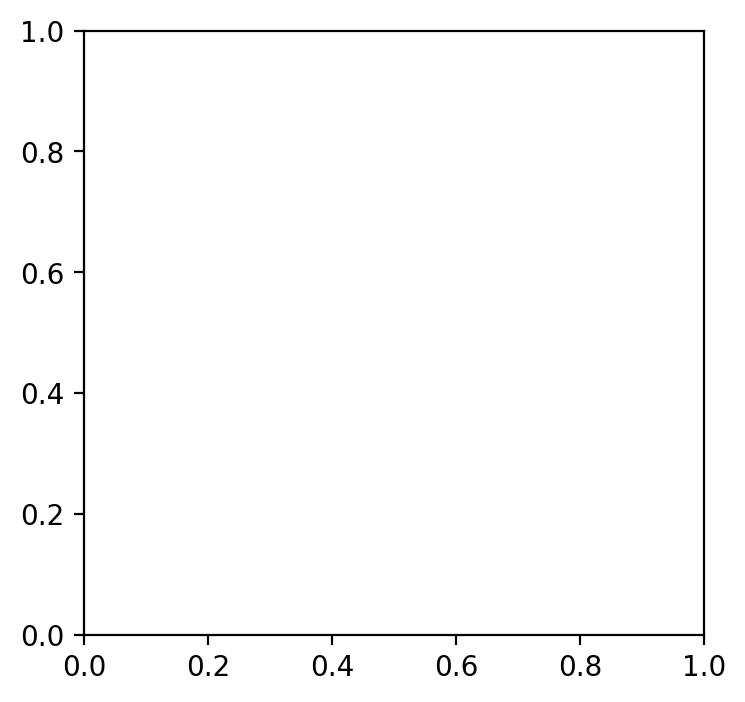

In [24]:
# ================ Paper version of the figure, smaller and fewer runs shown ====================

def func_logpowlaw(x,m,c):
    return m*x + c

def find_zeroIndex(array):
    for i in range(len(array)):
        if array[i]==0:
            return i-1
    return len(array)-1
    
fig2 = plt.figure(figsize=(4,4)); grid = gridspec.GridSpec(1,1,wspace=0.2,hspace=0.2); ax2 = fig2.add_subplot(grid[0,0]) # Active Sites vs. Time
fig3 = plt.figure(figsize=(4,4)); grid = gridspec.GridSpec(1,1,wspace=0.2,hspace=0.2); ax3 = fig3.add_subplot(grid[0,0]) # Unique Clusters vs. Time
fig4 = plt.figure(figsize=(4,4)); grid = gridspec.GridSpec(1,1,wspace=0.2,hspace=0.2); ax4 = fig4.add_subplot(grid[0,0]) # avg Cluster Size vs. Time

color_list = ['blue','red','black','green']
line_list = ['--','-.','-']
cp = -1

plotSeeds= [10,18,1]
for i in plotSeeds:
    print('starting i=' + str(i))
    cp +=1
    timeString = 'brain_1xx/brain1' + "{:0>2d}".format(i) + "_timeData.txt"
    savename = 'Plots/brain1xx/brain1' + "{:0>2d}".format(i) + "_timeAct.png"
    activityDensityFull,parts = activityAdding(timeString, 4, 9, 100, True, savename)
    actDensSparseIndexes = gen_log_space(len(activityDensityFull[:,0]-1),100)
    actList = []
    for ind in actDensSparseIndexes:
        actList += [activityDensityFull[ind,:].tolist()]
    activityDensity = np.asarray(actList)
#     print(activityDensity)
    
    
    ax2.plot(activityDensity[:,0],activityDensity[:,1],label=r'$\epsilon=$'+str(round(float(parts[1]),6)),
             linewidth=1.5,color=color_list[cp],linestyle=line_list[cp])
    ax4.plot(activityDensity[:,0],activityDensity[:,1]/activityDensity[:,2],label=r'$\epsilon=$'+str(round(float(parts[1]),6)),
             linewidth=1.5,color=color_list[cp],linestyle=line_list[cp])
    ax3.plot(activityDensity[:,0],activityDensity[:,2],label=r'$\epsilon=$'+str(round(float(parts[1]),6)),
             linewidth=1.5,color=color_list[cp],linestyle=line_list[cp])

ax2.set_ylim(top=10**6.1,bottom=10**4)
ax2.set_xlabel(r'time - $t$',fontsize='large'); ax2.set_ylabel(r'$\rho$',fontsize='large')
ax4.set_xlabel(r'time - $t$',fontsize='large'); ax4.set_ylabel(r'$\rho / U$',fontsize='large')
ax3.set_xlabel(r'time - $t$',fontsize='large'); ax3.set_ylabel(r'$u$',fontsize='x-large')
ax2.set_yscale('log', nonposy='clip'); ax2.set_xscale('log', nonposx='clip')
ax3.set_yscale('log', nonposy='clip'); ax3.set_xscale('log', nonposx='clip')
ax4.set_yscale('log', nonposy='clip'); ax4.set_xscale('log', nonposx='clip')
ax2.legend();
ax3.legend(); 
ax4.legend()

ax2.tick_params('both')
# ax3.set_title('$N = $'+str(parts[0])+'$; \delta \lambda = 0 $' + '; $\mu=$'+str(parts[3]),fontweight='bold',fontsize='large')
savename = 'Plots/brain1xx/epsi_timeStats.png'
# fig2.savefig('Plots/5_alpha_rho_epsi.png', dpi=360,bbox_inches = "tight")
# fig3.savefig('Plots/5_alpha_U_epsi.png', dpi=360,bbox_inches = "tight")
# fig4.savefig('Plots/5_alpha_rhoU_epsi.png', dpi=360,bbox_inches = "tight")
plt.show(fig2); plt.show(fig3); plt.show(fig4)

In [ ]:
fig2 = plt.figure(figsize=(4,4)); grid = gridspec.GridSpec(1,1,wspace=0.2,hspace=0.2); ax2 = fig2.add_subplot(grid[0,0]) # Active Sites vs. Time
fig3 = plt.figure(figsize=(4,4)); grid = gridspec.GridSpec(1,1,wspace=0.2,hspace=0.2); ax3 = fig3.add_subplot(grid[0,0]) # Unique Clusters vs. Time
fig4 = plt.figure(figsize=(4,4)); grid = gridspec.GridSpec(1,1,wspace=0.2,hspace=0.2); ax4 = fig4.add_subplot(grid[0,0]) # avg Cluster Size vs. Time

color_list = ['blue','red','black']
line_list = ['--','-.','-']
cp = -1

plotSeeds= [86, 88, 90]
for i in plotSeeds:
    print('starting i=' + str(i))
    cp +=1
    timeString = 'brain_2xx/brain2' + "{:0>2d}".format(i) + "_timeData.txt"
    savename = 'Plots/brain2xx/brain2' + "{:0>2d}".format(i) + "_timeAct.png"
#     activityDensity,parts = activityAdding(timeString, 4, 9, 100, True, savename)
    activityDensityFull,parts = activityAdding(timeString, 4, 9, 100, True, savename)
    actDensSparseIndexes = gen_log_space(len(activityDensityFull[:,0]-1),200)
    actList = []
    for ind in actDensSparseIndexes:
        actList += [activityDensityFull[ind,:].tolist()]
    activityDensity = np.asarray(actList)
    
    ax2.plot(activityDensity[:,0],activityDensity[:,1],label=r'$\Delta \lambda=$'+str(round(float(parts[2])-float(parts[3]),6)),
             linewidth=1.5,color=color_list[cp],linestyle=line_list[cp])
    ax4.plot(activityDensity[:,0],activityDensity[:,1]/activityDensity[:,2],label=r'$\Delta \lambda=$'+str(round(float(parts[2])-float(parts[3]),6)),
             linewidth=1.5,color=color_list[cp],linestyle=line_list[cp])
    ax3.plot(activityDensity[:,0],activityDensity[:,2],label=r'$\Delta \lambda=$'+str(round(float(parts[2])-float(parts[3]),6)),
             linewidth=1.5,color=color_list[cp],linestyle=line_list[cp])

ax2.set_ylim(top=10**6.1,bottom=10**4)
ax2.set_xlabel(r'time - $t$',fontsize='large'); ax2.set_ylabel(r'$\rho$',fontsize='large')
ax4.set_xlabel(r'time - $t$',fontsize='large'); ax4.set_ylabel(r'$\rho / U$',fontsize='large')
ax3.set_xlabel(r'time - $t$',fontsize='large'); ax3.set_ylabel(r'$u$',fontsize='x-large')
ax2.set_yscale('log', nonposy='clip'); ax2.set_xscale('log', nonposx='clip')
ax3.set_yscale('log', nonposy='clip'); ax3.set_xscale('log', nonposx='clip')
ax4.set_yscale('log', nonposy='clip'); ax4.set_xscale('log', nonposx='clip')
ax2.legend();
ax3.legend(); 
ax4.legend()

ax2.tick_params('both')
# ax3.set_title('$N = $'+str(parts[0])+'$; \delta \lambda = 0 $' + '; $\mu=$'+str(parts[3]),fontweight='bold',fontsize='large')
savename = 'Plots/brain2xx/deltaLambd_timeStats.png'
fig2.savefig('Plots/5_alpha_rho_deltLamb.png', dpi=360,bbox_inches = "tight")
fig3.savefig('Plots/5_alpha_U_deltLamb.png', dpi=360,bbox_inches = "tight")
fig4.savefig('Plots/5_alpha_rhoU_deltLamb.png', dpi=360,bbox_inches = "tight")
plt.show(fig2); plt.show(fig3); plt.show(fig4); 

## Time-averaged Data sets (over 10 runs, seed 102xx)

In [25]:
def activityDensityPlots(filename, width, length, bins, save, savename):
    """
    Inputs: 
        - filename: of the brainXXXX_timeData.txt
        - width, length: end plot
        - show (Boolean): save plot iff True
        - savename: path to save file to
   
    Returns:
        - Fluctuations in activity density, $\sigma(\rho)$
        - (if show==True) Plot of density of activity as a function of time:
        - $$ \rho(t) \equiv \frac{1}{N} \sum_n A_k$$
    """
    # ---------- Open and read in timeData file ----------
    text_file = open("Data/" + filename, "r")
    lines = []
    for line in open("Data/" + filename, "r"):
        lines += [line]
    lines = text_file.read().split('\n')
    eventList = lines[3:]
    
    neuralAvalancheStr = []
    neuralAvalancheData = []
    
    # ---------- Make lists from all the data ----------
    for i in range(len(eventList)):
        tempstr = eventList[i]
        neuralAvalancheStr += [tempstr.split(' ')]
        while '' in neuralAvalancheStr[-1]:
            neuralAvalancheStr[-1].remove('')
        for j in range(len(neuralAvalancheStr[-1])):
            neuralAvalancheData.append(float(neuralAvalancheStr[-1][j]))
    activityDensity = np.asarray(neuralAvalancheData).reshape(len(neuralAvalancheData)//3,3)

    # ---------- Create a list of the parameters ----------
    unNormedParts = lines[2].split(' ')    # Get rid of spaces in strings
    while '' in unNormedParts:
        unNormedParts.remove('')
    parts = [int(unNormedParts[0])]        # Make the parameters look pretty
    for i in range(len(unNormedParts)-1):
        parts += [str(round(float(unNormedParts[i+1]),8))]
    activityDensity = activityDensity.astype(float)
#     activityDensity[:,1] /= parts[0]
    
    # ---------- Make plots (Main - Histogram; Side - Activity time series) ----------
    fig = plt.figure(figsize=(width,length)); grid = gridspec.GridSpec(3,16,wspace=0.5,hspace=0.4)
    ax2 = fig.add_subplot(grid[0,:]) # Active Sites vs. Time
    ax3 = fig.add_subplot(grid[1,:]) # Unique Clusters vs. Time
    ax4 = fig.add_subplot(grid[2,:]) # avg Cluster Size vs. Time

    ax2.plot(activityDensity[:,0],activityDensity[:,1],label=r'$\rho$',linewidth=0.5,color='red')
    ax2.set_xlabel(r'time - $t$',fontsize='large'); ax2.set_ylabel(r'$\rho$',fontsize='large')
    
    ax4.plot(activityDensity[:,0],activityDensity[:,1]/activityDensity[:,2],linewidth=0.5,color='red')
    ax4.set_xlabel(r'time - $t$',fontsize='large'); ax4.set_ylabel(r'$\rho / U$',fontsize='large')
    # =================================== Fitting ================================================
    def func_logpowlaw(x,m,c):
        return m*x + c
    popt1,pcov1 = curve_fit(func_logpowlaw,np.log10(activityDensity[10:10000,0]),np.log10(activityDensity[10:10000,1]/activityDensity[10:10000,2]))
    xEps = np.linspace(1,4,100)
    ax4.plot(10**xEps,10**func_logpowlaw(xEps,*popt1),
                color='blue',label=r'$exp$='+ str(round(popt1[0],3)))
    # ============================================================================================
    

    ax3.plot(activityDensity[:,0],activityDensity[:,2],linewidth=0.5,color='red')
    ax3.set_xlabel(r'time - $t$',fontsize='large'); ax3.set_ylabel(r'$u$',fontsize='x-large')
    # =================================== Fitting ================================================
    def func_logpowlaw(x,m,c):
        return m*x + c
    popt1,pcov1 = curve_fit(func_logpowlaw,np.log10(activityDensity[10:10000,0]),np.log10(activityDensity[10:10000,2]))
    xEps = np.linspace(1,4,100)
    ax3.plot(10**xEps,10**func_logpowlaw(xEps,*popt1),
                color='blue',label=r'$exp$='+ str(round(popt1[0],3)))
    # ============================================================================================

    ax2.set_yscale('log', nonposy='clip'); ax2.set_xscale('log', nonposx='clip')
    ax3.set_yscale('log', nonposy='clip'); ax3.set_xscale('log', nonposx='clip')
    ax4.set_yscale('log', nonposy='clip'); ax4.set_xscale('log', nonposx='clip')
    ax3.legend()
    ax4.legend()
    
    ax2.tick_params('both')
    ax2.set_title('$N = $'+str(parts[0])+'$; \epsilon=$'+str(parts[1])+'; $\Delta=$'+str(parts[2])+'; $\mu=$'+str(parts[3]),fontweight='bold',fontsize='large')
    if save == True:
        fig.savefig(savename,dpi=300,bbox_inches = "tight")
        plt.close(fig)
    else:
        plt.show(fig)
        

def activityAdding(filename, width, length, bins, save, savename):
    """
    Inputs: 
        - filename: of the brainXXXX_timeData.txt
        - width, length: end plot
        - show (Boolean): save plot iff True
        - savename: path to save file to
   
    Returns:
        - Fluctuations in activity density, $\sigma(\rho)$
        - (if show==True) Plot of density of activity as a function of time:
        - $$ \rho(t) \equiv \frac{1}{N} \sum_n A_k$$
    """
    # ---------- Open and read in timeData file ----------
#     if os.path.exists("test_file.txt"):        #finding bad lines
#       os.remove("test_file.txt")               #finding bad lines
#     f= open("test_file.txt","w+")              #finding bad lines

    text_file = open("Data/" + filename, "r")
    lines = []
    for line in open("Data/" + filename, "r"):
        if '^@' in line:
            5
        else:
            lines += [line]
        
    lines = text_file.read().split('\n')
    eventList = lines[3:]
    
    neuralAvalancheStr = []
    neuralAvalancheData = []
    
    # ---------- Make lists from all the data ----------
    for i in range(len(eventList)):
        tempstr = eventList[i]
        neuralAvalancheStr += [tempstr.split(' ')]
        while '' in neuralAvalancheStr[-1]:
            neuralAvalancheStr[-1].remove('')
        for j in range(len(neuralAvalancheStr[-1])):
#             f.write(str(i)+', '+str(neuralAvalancheStr[-1][j])+'\n')                            #finding bad lines
            neuralAvalancheData.append(float(neuralAvalancheStr[-1][j]))
    activityDensity = np.asarray(neuralAvalancheData).reshape(len(neuralAvalancheData)//3,3)

    # ---------- Create a list of the parameters ----------
    unNormedParts = lines[2].split(' ')    # Get rid of spaces in strings
    while '' in unNormedParts:
        unNormedParts.remove('')
    parts = [int(unNormedParts[0])]        # Make the parameters look pretty
    for i in range(len(unNormedParts)-1):
        parts += [str(round(float(unNormedParts[i+1]),8))]
    activityDensity = activityDensity.astype(float)
    
    return activityDensity, parts

starting: brain_102xx/brainAvg_10400x.txt
starting: brain_102xx/brainAvg_10300x.txt
starting: brain_102xx/brainAvg_10310x.txt
starting: brain_102xx/brainAvg_10320x.txt
starting: brain_102xx/brainAvg_10330x.txt
starting: brain_102xx/brainAvg_10340x.txt
starting: brain_102xx/brainAvg_10350x.txt
starting: brain_102xx/brainAvg_10360x.txt
starting: brain_102xx/brainAvg_10370x.txt
starting: brain_102xx/brainAvg_10380x.txt
starting: brain_102xx/brainAvg_10390x.txt


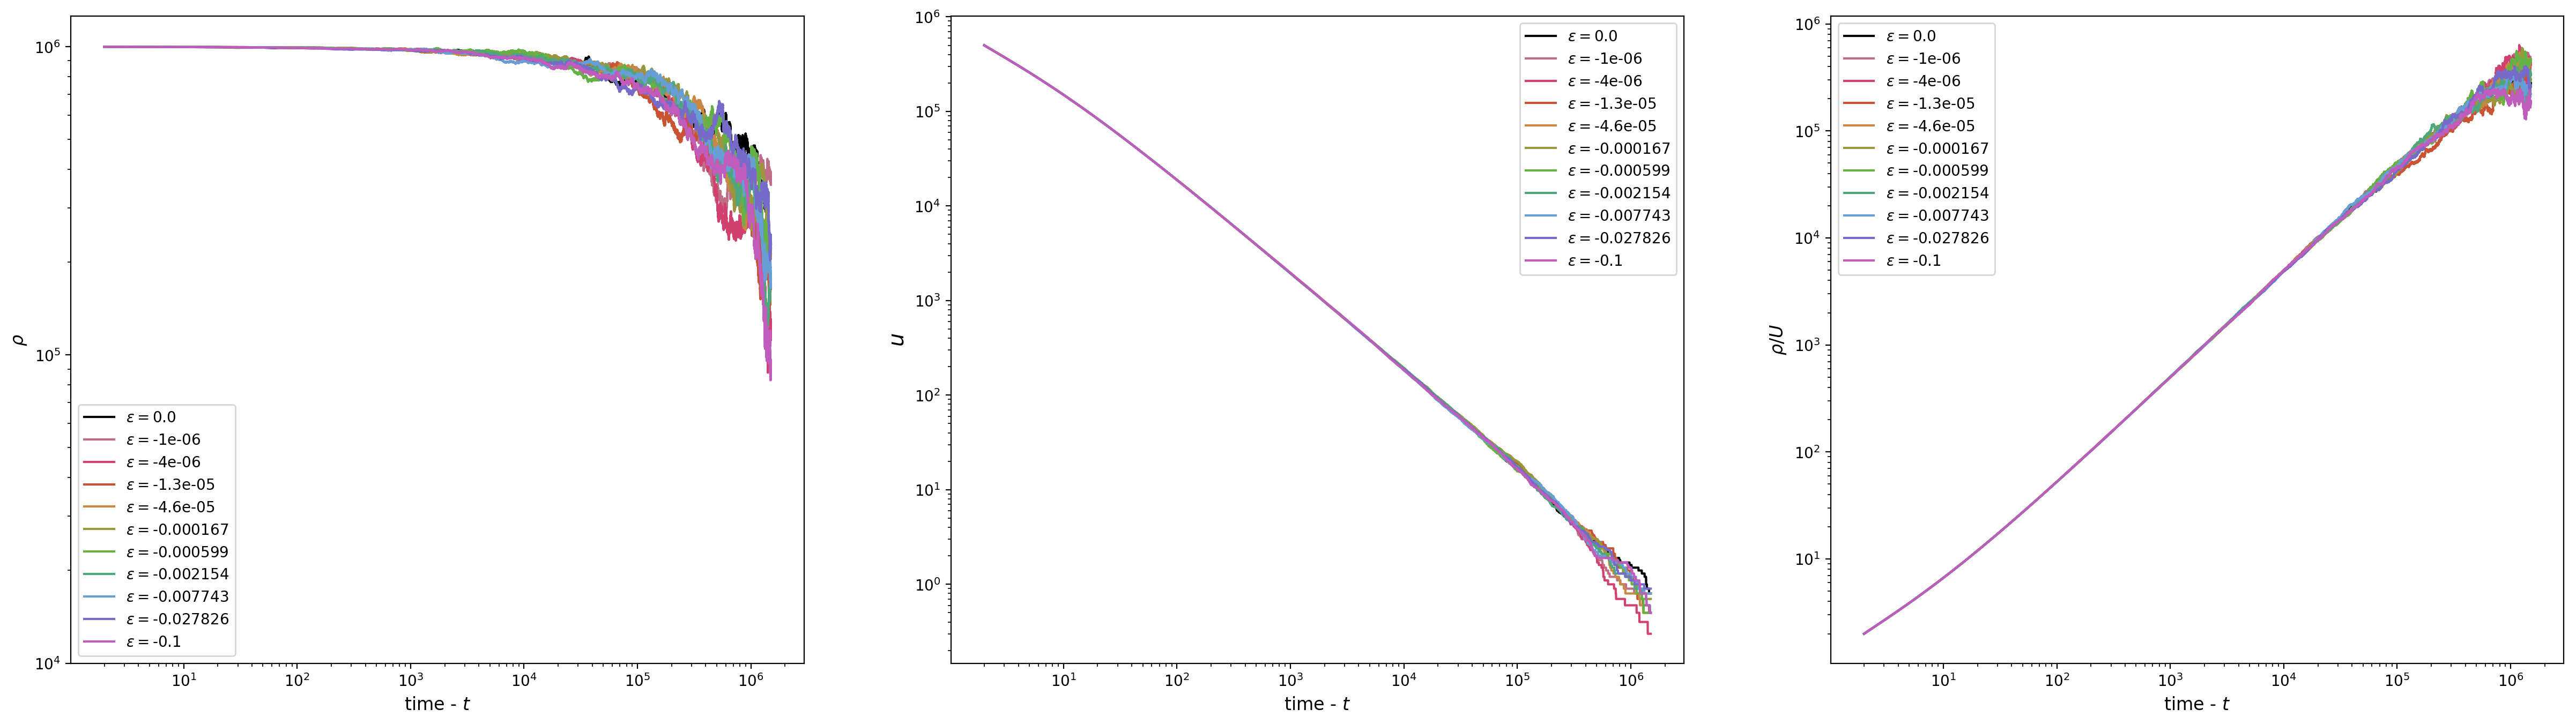

In [162]:
def func_logpowlaw(x,m,c):
    return m*x + c

def find_zeroIndex(array):
    for i in range(len(array)):
        if array[i]==0:
            return i-1
    return len(array)-1
    
fig = plt.figure(figsize=(30,8)); grid = gridspec.GridSpec(16,3,wspace=0.2,hspace=0.2)
ax2 = fig.add_subplot(grid[:,0]) # Active Sites vs. Time
ax3 = fig.add_subplot(grid[:,1]) # Unique Clusters vs. Time
ax4 = fig.add_subplot(grid[:,2]) # avg Cluster Size vs. Time

color_list = np.array([[0,0,0],
[192,109,135],
[209,64,110],
[202,83,54],
[200,135,67],
[153,150,62],
[102,177,70],
[79,166,124],
[102,158,213],
[118,107,201],
[192,92,187]])/255
cp = -1

plotSeeds= [40,30,31,32,33,34,35,36,37,38,39]
for i in plotSeeds:
    cp +=1
    timeString = 'brain_102xx/brainAvg_10' + "{:0>2d}".format(i) + "0x.txt"; print('starting: ' + timeString)
    savename = 'Plots/brain102xx/brainAvg_10' + "{:0>2d}".format(i) + "0x_timeAct.png"
#     activityDensityPlots(timeString, 4, 9, 100, True, savename)
    activityDensity,parts = activityAdding(timeString, 4, 9, 100, True, savename)
    
    ax2.plot(activityDensity[:,0],activityDensity[:,1],label=r'$\epsilon=$'+str(round(float(parts[1]),6)),
             linewidth=1.5,color=color_list[cp])
    ax4.plot(activityDensity[:,0],activityDensity[:,1]/activityDensity[:,2],label=r'$\epsilon=$'+str(round(float(parts[1]),6)),
             linewidth=1.5,color=color_list[cp])
    
#     # =================================== Fitting ================================================
#     endFit = find_zeroIndex(activityDensity[:,1]); print(endFit)
#     popt1,pcov1 = curve_fit(func_logpowlaw,np.log10(activityDensity[10:endFit,0]),np.log10(activityDensity[10:endFit,1]/activityDensity[10:endFit,2]))
#     xEps = np.linspace(1,np.log10(endFit),100)
#     ax4.plot(10**xEps,10**func_logpowlaw(xEps,*popt1),
#                 color='blue',label=r'$exp$='+ str(round(popt1[0],3)))
#     # ============================================================================================


    ax3.plot(activityDensity[:,0],activityDensity[:,2],label=r'$\epsilon=$'+str(round(float(parts[1]),6)),
             linewidth=1.5,color=color_list[cp])
#     # =================================== Fitting ================================================
#     popt1,pcov1 = curve_fit(func_logpowlaw,np.log10(activityDensity[10:endFit,0]),np.log10(activityDensity[10:endFit,2]))
#     xEps = np.linspace(1,np.log10(endFit),100)
#     ax3.plot(10**xEps,10**func_logpowlaw(xEps,*popt1),
#                 color='blue',label=r'$exp$='+ str(round(popt1[0],3)))
#     # ============================================================================================

ax2.set_ylim(top=10**6.1,bottom=10**4)
ax2.set_xlabel(r'time - $t$',fontsize='large'); ax2.set_ylabel(r'$\rho$',fontsize='large')
ax4.set_xlabel(r'time - $t$',fontsize='large'); ax4.set_ylabel(r'$\rho / U$',fontsize='large')
ax3.set_xlabel(r'time - $t$',fontsize='large'); ax3.set_ylabel(r'$u$',fontsize='x-large')
ax2.set_yscale('log', nonposy='clip'); ax2.set_xscale('log', nonposx='clip')
ax3.set_yscale('log', nonposy='clip'); ax3.set_xscale('log', nonposx='clip')
ax4.set_yscale('log', nonposy='clip'); ax4.set_xscale('log', nonposx='clip')
ax2.legend();
ax3.legend(); 
ax4.legend()

ax2.tick_params('both')
# ax3.set_title('$N = $'+str(parts[0])+'$; \delta \lambda = 0 $' + '; $\mu=$'+str(parts[3]),fontweight='bold',fontsize='large')
savename = 'Plots/brain102xx/epsi_timeStats.png'
fig.savefig(savename,dpi=450,bbox_inches = "tight")
plt.show(fig)

starting: brain_102xx/brainAvg_10400x.txt
1499998
starting: brain_102xx/brainAvg_10200x.txt


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in true_divide


1346132
starting: brain_102xx/brainAvg_10210x.txt
994103
starting: brain_102xx/brainAvg_10220x.txt
416983
starting: brain_102xx/brainAvg_10230x.txt
106606
starting: brain_102xx/brainAvg_10240x.txt
23439
starting: brain_102xx/brainAvg_10250x.txt
9374
starting: brain_102xx/brainAvg_10260x.txt
2790
starting: brain_102xx/brainAvg_10270x.txt
768
starting: brain_102xx/brainAvg_10280x.txt
243
starting: brain_102xx/brainAvg_10290x.txt
61


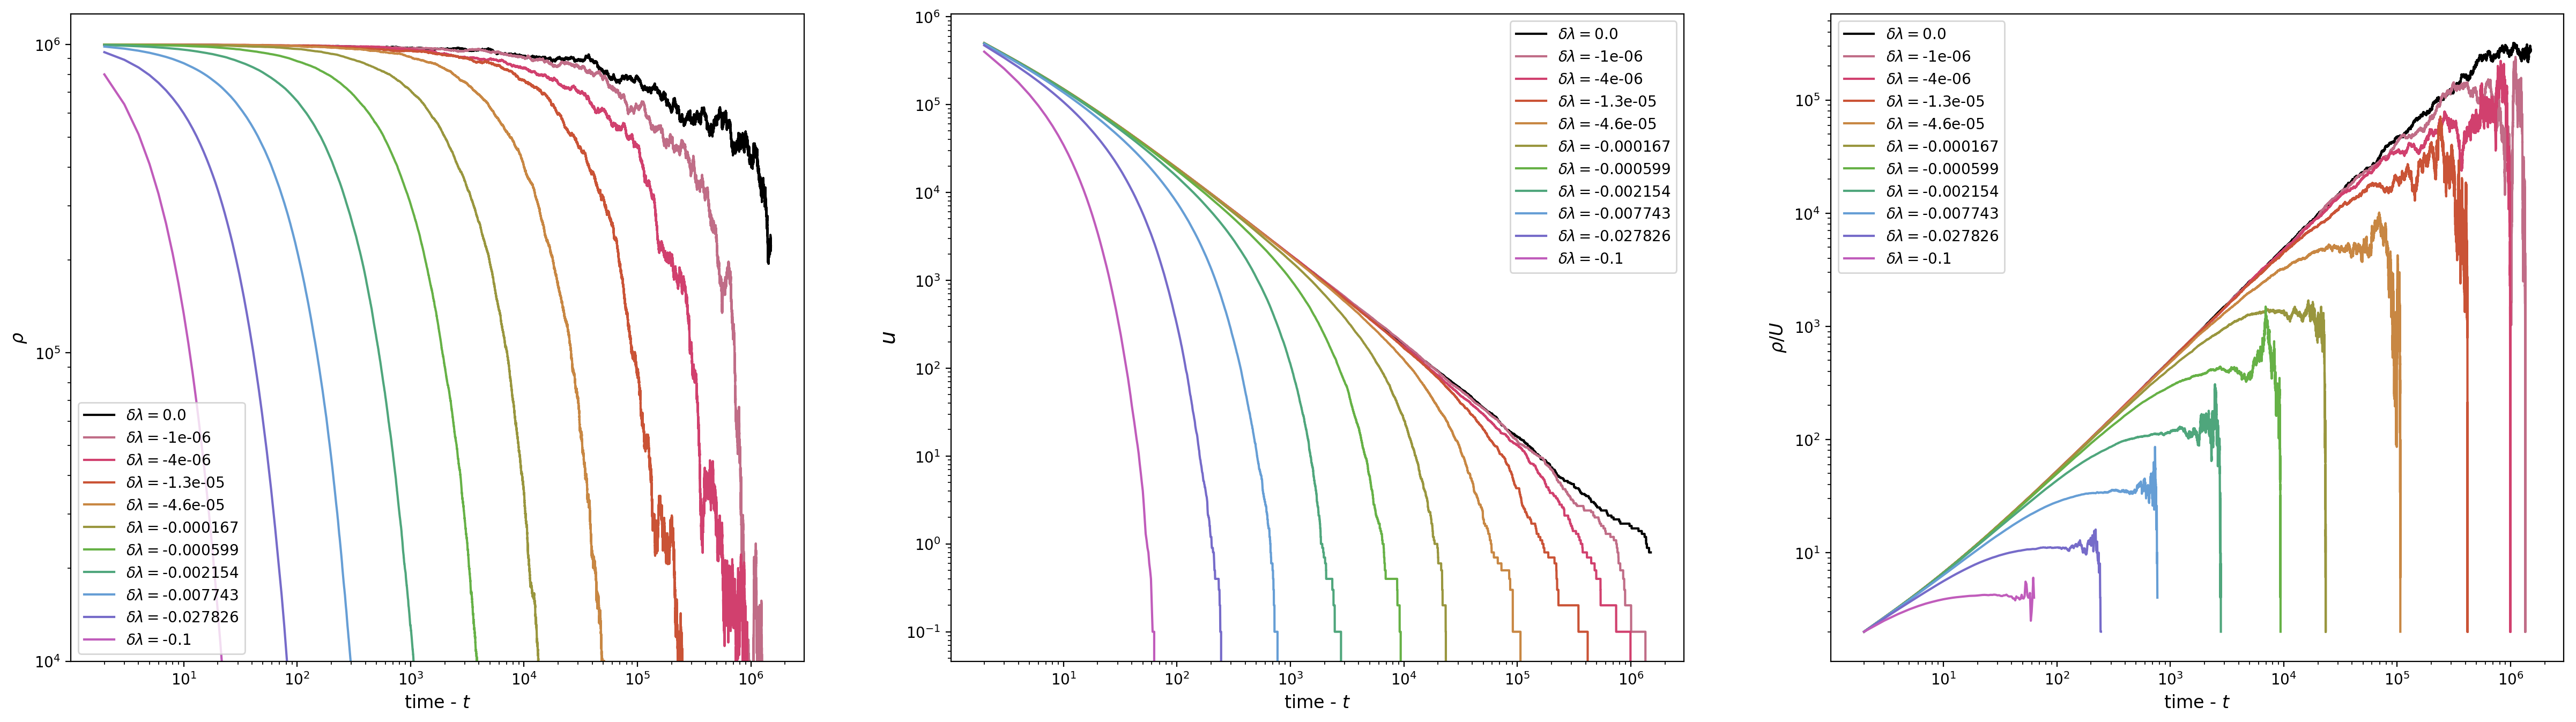

In [152]:
def func_logpowlaw(x,m,c):
    return m*x + c

def func_exp(x,zi,A):
    return A * np.exp(-x/zi)

def find_zeroIndex(array):
    for i in range(len(array)):
        if array[i]==0:
            return i-1
    return len(array)-1
    
fig = plt.figure(figsize=(30,8)); grid = gridspec.GridSpec(16,3,wspace=0.2,hspace=0.2)
ax2 = fig.add_subplot(grid[:,0]) # Active Sites vs. Time
ax3 = fig.add_subplot(grid[:,1]) # Unique Clusters vs. Time
ax4 = fig.add_subplot(grid[:,2]) # avg Cluster Size vs. Time

corInv = []
color_list = np.array([[0,0,0],
[192,109,135],
[209,64,110],
[202,83,54],
[200,135,67],
[153,150,62],
[102,177,70],
[79,166,124],
[102,158,213],
[118,107,201],
[192,92,187]])/255
cp = -1

plotSeeds= [40,20,21,22,23,24,25,26,27,28,29]
for i in plotSeeds:
    cp +=1
    timeString = 'brain_102xx/brainAvg_10' + "{:0>2d}".format(i) + "0x.txt"; print('starting: ' + timeString)
    savename = 'Plots/brain102xx/brainAvg_10' + "{:0>2d}".format(i) + "0x_timeAct.png"
#     activityDensityPlots(timeString, 4, 9, 100, True, savename)
    activityDensity,parts = activityAdding(timeString, 4, 9, 100, True, savename)
    
    ax2.plot(activityDensity[:,0],activityDensity[:,1],label=r'$\delta \lambda=$'+str(round(float(parts[2])-float(parts[3]),6)),
             linewidth=1.5,color=color_list[cp])
    ax4.plot(activityDensity[:,0],activityDensity[:,1]/activityDensity[:,2],label=r'$\delta \lambda=$'+str(round(float(parts[2])-float(parts[3]),6)),
             linewidth=1.5,color=color_list[cp])
    
#     # =================================== Fitting ================================================
#     endFit = find_zeroIndex(activityDensity[:,1]); print(endFit)
#     popt1,pcov1 = curve_fit(func_logpowlaw,np.log10(activityDensity[10:endFit,0]),np.log10(activityDensity[10:endFit,1]/activityDensity[10:endFit,2]))
#     xEps = np.linspace(1,np.log10(endFit),100)
#     ax4.plot(10**xEps,10**func_logpowlaw(xEps,*popt1),
#                 color='blue',label=r'$exp$='+ str(round(popt1[0],3)))
#     # ============================================================================================


    ax3.plot(activityDensity[:,0],activityDensity[:,2],label=r'$\delta \lambda=$'+str(round(float(parts[2])-float(parts[3]),6)),
             linewidth=1.5,color=color_list[cp])
#     # =================================== Fitting ================================================
    endFit = find_zeroIndex(activityDensity[:,1]); print(endFit)
    popt1,pcov1 = curve_fit(func_exp,activityDensity[0:endFit,0],activityDensity[0:endFit,1])
    xEps = np.logspace(0,np.log10(endFit),100)
#     ax2.plot(xEps,func_exp(xEps,*popt1),
#                 color=color_list[cp],label=r'$\xi$='+ str(round(popt1[0],3))+'; $\delta \lambda=$'+str(round(float(parts[2])-float(parts[3]),6)))
    corInv += [[float(parts[2]) - float(parts[3]), popt1[0]]]
#     # ============================================================================================

ax2.set_ylim(top=10**6.1,bottom=10**4)
ax2.set_xlabel(r'time - $t$',fontsize='large'); ax2.set_ylabel(r'$\rho$',fontsize='large')
ax4.set_xlabel(r'time - $t$',fontsize='large'); ax4.set_ylabel(r'$\rho / U$',fontsize='large')
ax3.set_xlabel(r'time - $t$',fontsize='large'); ax3.set_ylabel(r'$u$',fontsize='x-large')
ax2.set_yscale('log', nonposy='clip'); ax2.set_xscale('log', nonposx='clip')
ax3.set_yscale('log', nonposy='clip'); ax3.set_xscale('log', nonposx='clip')
ax4.set_yscale('log', nonposy='clip'); ax4.set_xscale('log', nonposx='clip')
ax2.legend();
ax3.legend(); 
ax4.legend()

ax2.tick_params('both')
# ax3.set_title('$N = $'+str(parts[0])+'$; \epsilon = 0 $' + '; $\mu=$'+str(parts[3]),fontweight='bold',fontsize='large')
savename = 'Plots/brain102xx/deltaLambd_timeStats.png'
fig.savefig(savename,dpi=450,bbox_inches = "tight")
plt.show(fig)

[[-2.280000000021154e-06, 203277.3996473993], [-5.179999999993523e-06, 65543.59805782724], [-1.1790000000011513e-05, 71240.84738691505], [-2.6829999999977705e-05, 16007.707019096044], [-6.105000000000693e-05, 7875.541812231514], [-0.00013895000000002655, 3401.951860827864], [-0.0003162299999999729, 1555.0171476377072], [-0.0007196899999999951, 714.6314180132359], [-0.0016378899999999752, 312.5186418718269], [-0.003727590000000003, 134.10693762683704], [-0.008483430000000014, 58.05972814039371], [-0.019306979999999974, 25.45911669316817], [-0.04393971000000002, 10.840529110083848], [-0.09999999999999998, -260782835.76938063], [0.0, 89.8738250426688], [-9.999999999732445e-07, 336682.3053370793], [-3.5899999999977616e-06, 133933.26184049578], [-1.2920000000027354e-05, 42591.8347164944], [-4.641999999999147e-05, 11123.565709894097], [-0.00016681000000001722, 3016.7149107470773], [-0.0005994799999999856, 839.9532431103586], [-0.002154429999999985, 228.75034239460754], [-0.007742640000000023

# Misc. Special Use Functions/Plots

## Fitting sub-critical $\Delta \lambda$ runs for correlation time, $\xi_\parallel$ (for $\alpha$ runs)

In [ ]:
activityDensity,parts = activityAdding(timeString, 4, 9, 100, True, savename)

starting i=1


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:50: RuntimeWarning: invalid value encountered in true_divide


752982
starting i=2
283136
starting i=3
250461
starting i=4
68264
starting i=5
43779
starting i=6
21084
starting i=7
13951
starting i=8
5872
starting i=9
2620
starting i=10
1177
starting i=11
662
starting i=12
251
starting i=13
167
starting i=14


No handles with labels found to put in legend.


56


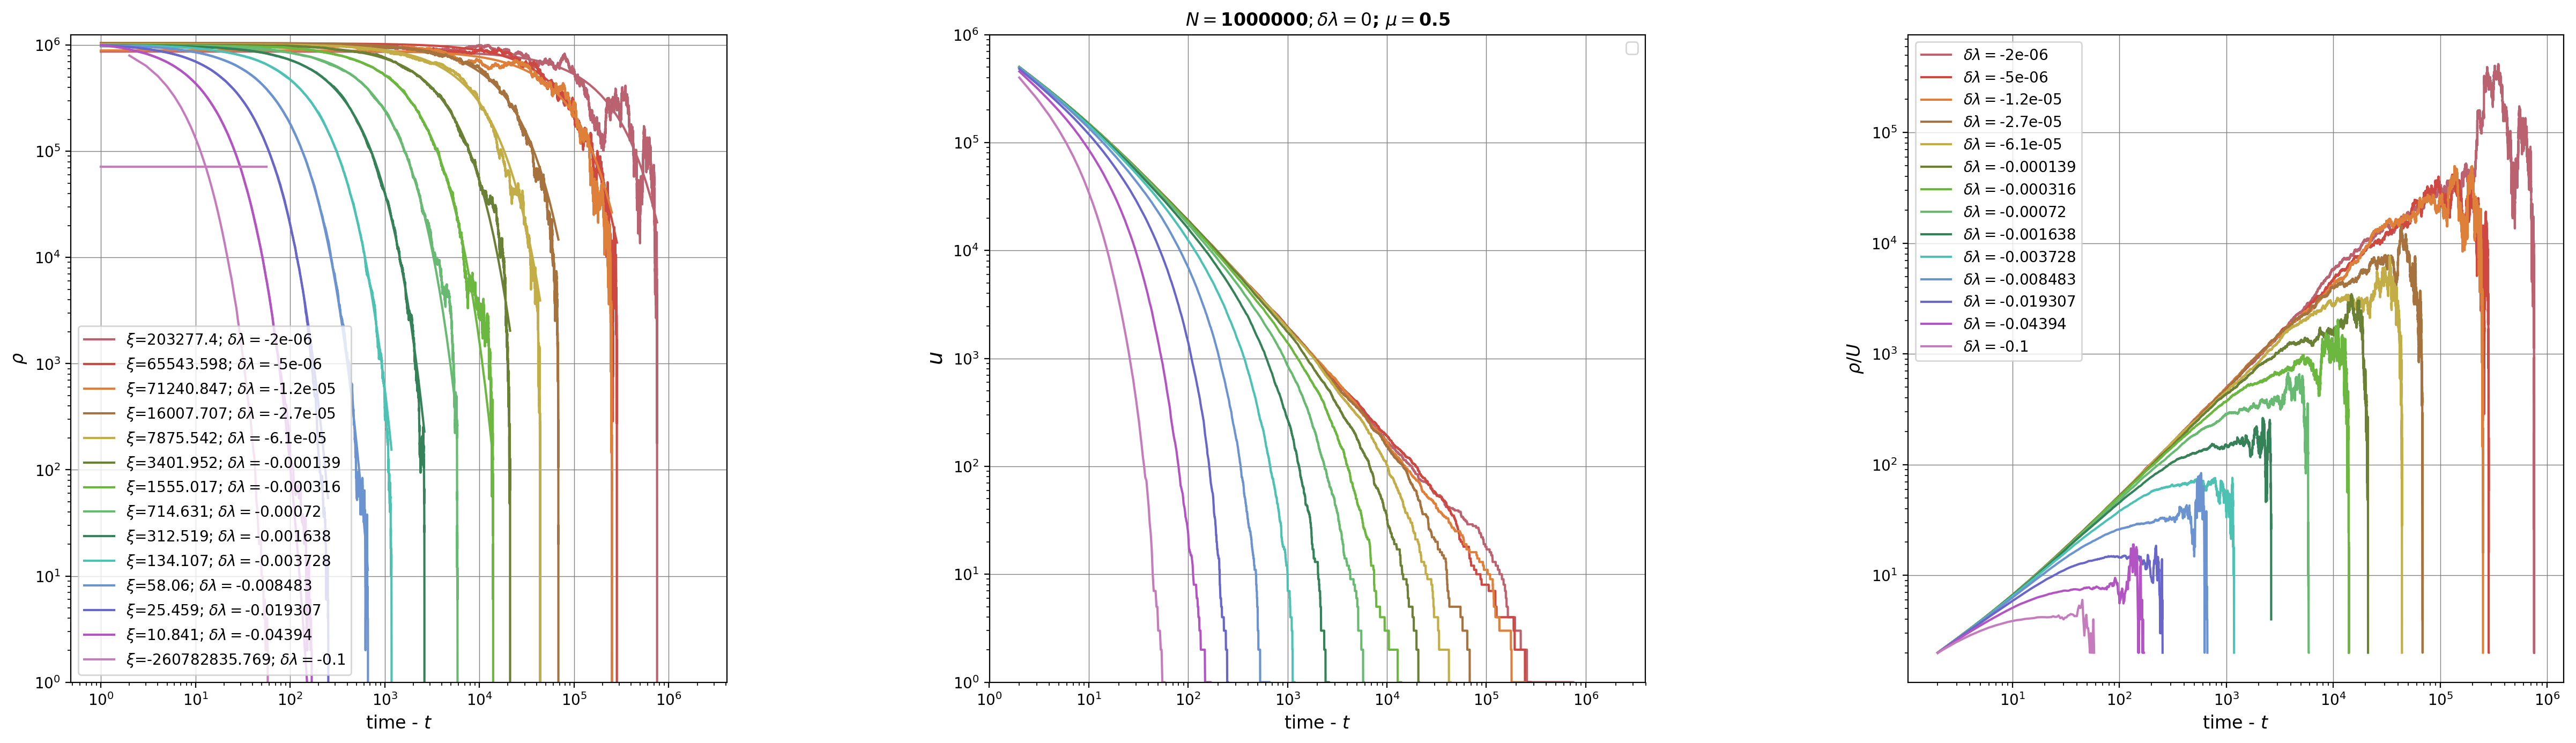

In [62]:
def func_logpowlaw(x,m,c):
    return m*x + c

def func_exp(x,zi,A):
    return A * np.exp(-x/zi)

def func_logNonlinPowLaw(s,a,m,sig,eps):
    powerlaw = a - m * s - eps * exp(sig*s)
    return powerlaw

def find_zeroIndex(array):
    for i in range(len(array)):
        if array[i]==0:
            return i-1
    return len(array)-1
    
fig = plt.figure(figsize=(30,8)); grid = gridspec.GridSpec(16,3,wspace=0.4,hspace=0.4)
ax2 = fig.add_subplot(grid[:,0]) # Active Sites vs. Time
ax3 = fig.add_subplot(grid[:,1]) # Unique Clusters vs. Time
ax4 = fig.add_subplot(grid[:,2]) # avg Cluster Size vs. Time

color_list = np.array([[187,98,112],
[206,71,64],
[222,127,58],
[166,114,62],
[194,173,70],
[106,128,52],
[107,183,63],
[104,186,114],
[53,130,88],
[77,193,180],
[107,147,207],
[104,103,201],
[178,84,193],
[196,124,188],
[209,68,133]])/255
cp = -1
corInv = []

plotSeeds= [1,2,3,4,5,6,7,8,9,10,11,12,13,14]
for i in plotSeeds:
    print('starting i=' + str(i))
    cp +=1
    timeString = 'brain_101xx/brain101' + "{:0>2d}".format(i) + "_timeData.txt"
    savename = 'Plots/brain101xx/brain101' + "{:0>2d}".format(i) + "_timeAct.png"
    activityDensity,parts = activityAdding(timeString, 4, 9, 100, True, savename)
    
    ax2.plot(activityDensity[:,0],activityDensity[:,1],#label=r'$\delta \lambda=$'+str(round(float(parts[2])-float(parts[3]),6)),
             linewidth=1.5,color=color_list[cp])
    ax4.plot(activityDensity[:,0],activityDensity[:,1]/activityDensity[:,2],label=r'$\delta \lambda=$'+str(round(float(parts[2])-float(parts[3]),6)),
             linewidth=1.5,color=color_list[cp])
    ax3.plot(activityDensity[:,0],activityDensity[:,2],#label=r'$\delta \lambda=$'+str(round(float(parts[2])-float(parts[3]),6)),
             linewidth=1.5,color=color_list[cp])
    # =================================== Fitting ================================================
    endFit = find_zeroIndex(activityDensity[:,1]); print(endFit)
    popt1,pcov1 = curve_fit(func_exp,activityDensity[0:endFit,0],activityDensity[0:endFit,1])
    xEps = np.logspace(0,np.log10(endFit),100)
    ax2.plot(xEps,func_exp(xEps,*popt1),
                color=color_list[cp],label=r'$\xi$='+ str(round(popt1[0],3))+'; $\delta \lambda=$'+str(round(float(parts[2])-float(parts[3]),6)))
    corInv += [[float(parts[2]) - float(parts[3]), popt1[0]]]
    # ============================================================================================

ax2.set_ylim(top=10**6.1,bottom=10**0)
ax3.set_ylim(top=10**6,bottom=10**0)

ax2.set_xlabel(r'time - $t$',fontsize='large'); ax2.set_ylabel(r'$\rho$',fontsize='large')
ax4.set_xlabel(r'time - $t$',fontsize='large'); ax4.set_ylabel(r'$\rho / U$',fontsize='large')
ax3.set_xlabel(r'time - $t$',fontsize='large'); ax3.set_ylabel(r'$u$',fontsize='x-large')
ax2.set_yscale('log', nonposy='clip'); ax2.set_xscale('log', nonposx='clip')
ax3.set_yscale('log', nonposy='clip'); ax3.set_xscale('log', nonposx='clip')
ax4.set_yscale('log', nonposy='clip'); ax4.set_xscale('log', nonposx='clip')
ax2.legend();
ax3.legend(); 
ax4.legend()

ax2.tick_params('both')
ax2.grid(linestyle='-', linewidth='0.5', color='grey')
ax3.grid(linestyle='-', linewidth='0.5', color='grey')
ax4.grid(linestyle='-', linewidth='0.5', color='grey')

ax3.set_title('$N = $'+str(parts[0])+'$; \delta \lambda = 0 $' + '; $\mu=$'+str(parts[3]),fontweight='bold',fontsize='large')
savename = 'Plots/brain2xx/deltaLambd_timeStats.png'
# fig.savefig(savename,dpi=450,bbox_inches = "tight")
plt.show(fig)

In [80]:
xTest = activityDensity[2:44,0]
yTest = activityDensity[2:44,1]

def func_exp(x, a, c, d):
    return a*np.exp(-x / c)+d

popt1,pcov1 = curve_fit(func_exp,xTest,yTest)
print(popt1,pcov1)
print(yTest)

[1.25326655e+06 4.46947745e+00 1.89117911e+02] [[ 9.24271649e+05 -2.43453248e+00  1.43285954e+04]
 [-2.43453248e+00  7.50491128e-06 -6.42950293e-02]
 [ 1.43285954e+04 -6.42950293e-02  2.03331262e+03]]
[5.12372e+05 4.09752e+05 3.27792e+05 2.61918e+05 2.08770e+05 1.67344e+05
 1.33540e+05 1.07150e+05 8.54780e+04 6.88480e+04 5.51560e+04 4.41520e+04
 3.54260e+04 2.83580e+04 2.27700e+04 1.82640e+04 1.46140e+04 1.17380e+04
 9.47400e+03 7.65000e+03 6.33800e+03 5.03400e+03 4.06200e+03 3.36000e+03
 2.60600e+03 2.10200e+03 1.62400e+03 1.33200e+03 1.08400e+03 8.70000e+02
 6.96000e+02 5.50000e+02 4.48000e+02 3.48000e+02 3.16000e+02 2.40000e+02
 1.84000e+02 1.48000e+02 1.28000e+02 8.60000e+01 5.20000e+01 4.20000e+01]


## !! Stationary State from seed growth ($\lambda$-exponent in paper) !!

/Library/Python/3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


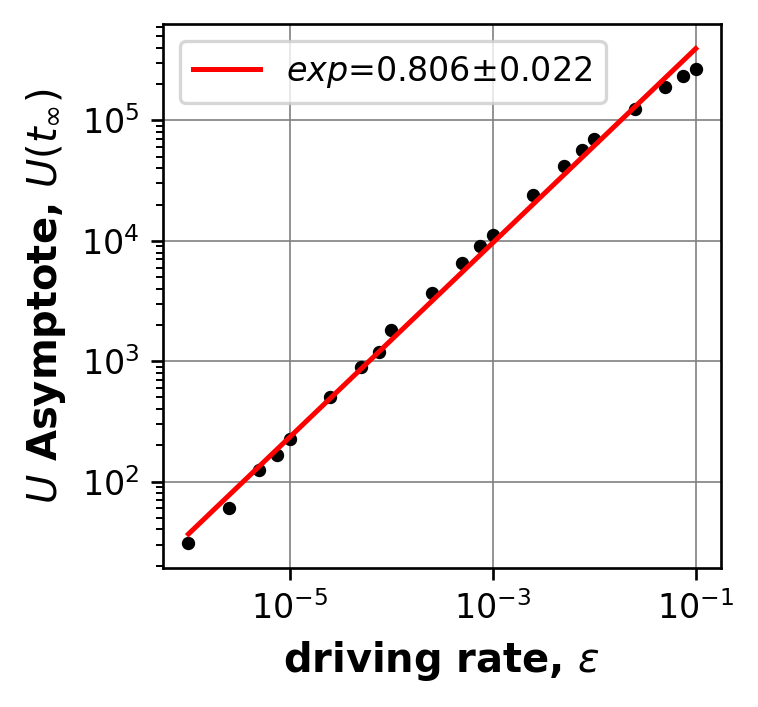

/Library/Python/3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


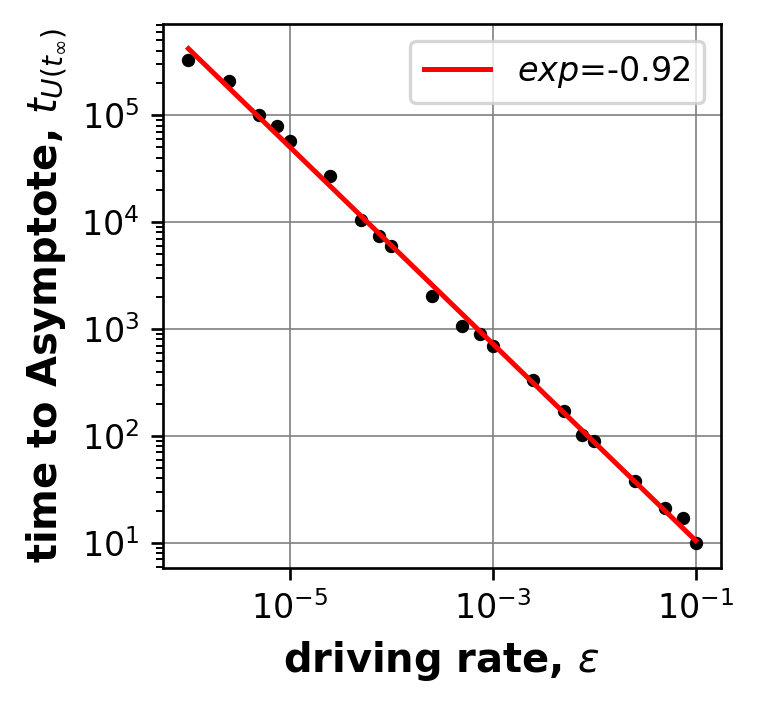

[-0.92032675  0.10074802]


In [4]:
### Asymptote scaling for increasing epsilon in alpha runs

epsilon_Asymptotes = [31,60,126,165,224,500,900,1200,1800,3700,6600,9000,11250,24000,41500,57000,70000,125000,190000,234093,270000]
timeto_Asymptote = [330000,210000,100000,80000,58000,27000,10450,7400,6000,2040,1060,900,700,330,170,103,90,38,21,17,10]
relaxtime_eps = [1.0E-06,2.5E-06,5.0E-06,7.5E-06,1.0E-05,2.5E-05,5.0E-05,7.5E-05,1.0E-04,2.5E-04,5.0E-04,7.5E-04,1.0E-03,2.5E-03,5.0E-03,7.5E-03,1.0E-02,2.5E-02,5.0E-02,7.5E-02,1.0E-01]

fig = plt.figure(figsize=(3,3), dpi=120); 
grid = gridspec.GridSpec(1,1,wspace=0.4,hspace=0.3);
ax = fig.add_subplot(grid[0,0]); 
ax.plot(relaxtime_eps,epsilon_Asymptotes,color='black',linewidth=0,marker='.')
# =================================== Fitting ================================================
def func_logpowlaw(x,m,c):
    return m*x + c
popt1,pcov1 = curve_fit(func_logpowlaw,np.log10(relaxtime_eps),np.log10(epsilon_Asymptotes))
xEps = np.linspace(-1,-6,100)
stdDev = np.sqrt(np.diag(pcov1)[0])

ax.plot(10**xEps,10**func_logpowlaw(xEps,*popt1),
            color='red',label=r'$exp$='+ str(round(popt1[0],3))+ '$\pm$' + str(round(1.96*stdDev,4)))
# ============================================================================================
ax.set_yscale('log', nonposy='clip'); ax.set_xscale('log', nonposx='clip')
ax.set_xlabel(r'driving rate, $\varepsilon$',fontweight='bold',fontsize='large'); 
ax.set_ylabel(r'$U$ Asymptote, $U(t_\infty)$',fontweight='bold',fontsize='large')

# fig.suptitle('$G =$1'+'; $\lambda=$0.5'+'; $\mu=$0.5',
#              fontweight='bold',fontsize='large')
ax.legend()
ax.grid(linestyle='-', linewidth='0.5', color='grey')
# plt.savefig('Plots/alpha_epsi_asympValue.png', format='png', dpi=360, bbox_inches = "tight")
plt.show(fig)



fig = plt.figure(figsize=(3,3), dpi=120); 
grid = gridspec.GridSpec(1,1,wspace=0.4,hspace=0.3);
ax = fig.add_subplot(grid[0,0]); 
ax.plot(relaxtime_eps,timeto_Asymptote,color='black',linewidth=0,marker='.')
# =================================== Fitting ================================================
def func_logpowlaw(x,m,c):
    return m*x + c
popt1,pcov1 = curve_fit(func_logpowlaw,np.log10(relaxtime_eps),np.log10(timeto_Asymptote))
xEps = np.linspace(-1,-6,100)
ax.plot(10**xEps,10**func_logpowlaw(xEps,*popt1),
            color='red',label=r'$exp$='+ str(round(popt1[0],3)))
# ============================================================================================
ax.set_yscale('log', nonposy='clip'); ax.set_xscale('log', nonposx='clip')
ax.set_xlabel(r'driving rate, $\varepsilon$',fontweight='bold',fontsize='large'); 
ax.set_ylabel(r'time to Asymptote, $t_{U(t_\infty)}$',fontweight='bold',fontsize='large')

# fig.suptitle('$G =$1'+'; $\lambda=$0.5'+'; $\mu=$0.5',
#              fontweight='bold',fontsize='large')
ax.legend()
ax.grid(linestyle='-', linewidth='0.5', color='grey')
# plt.savefig('Plots/alpha_epsi_asympTime.png', format='png', dpi=360, bbox_inches = "tight")
plt.show(fig)




print(popt1)

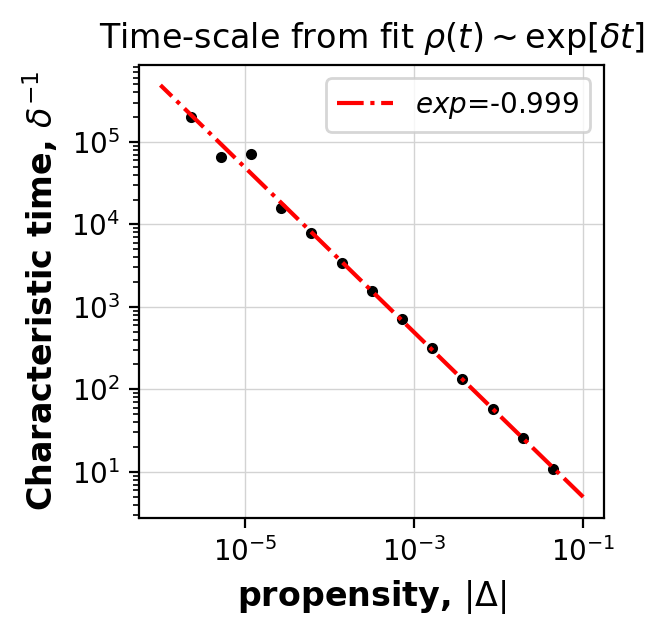

In [63]:
### Death time vs delta lambda for alpha runs

correlationInv = np.asarray(corInv)

epsilon_Asymptotes = correlationInv[:-1,1]
relaxtime_eps = -1 * correlationInv[:-1,0]

fig = plt.figure(figsize=(3,3)); 
grid = gridspec.GridSpec(1,1,wspace=0.4,hspace=0.3);
ax = fig.add_subplot(grid[0,0]); 
ax.plot(relaxtime_eps,epsilon_Asymptotes,color='black',linewidth=0,marker='.')
# =================================== Fitting ================================================
def func_logpowlaw(x,m,c):
    return m*x + c
popt1,pcov1 = curve_fit(func_logpowlaw,np.log10(relaxtime_eps[4:]),np.log10(epsilon_Asymptotes[4:]))
xEps = np.linspace(-1,-6,100)
ax.plot(10**xEps,10**func_logpowlaw(xEps,*popt1),
        color='red',linestyle='-.',
        label=r'$exp$='+ str(round(popt1[0],3)))
# ============================================================================================
ax.set_yscale('log', nonposy='clip'); ax.set_xscale('log', nonposx='clip')
ax.set_xlabel(r'propensity, $|\Delta|$',fontweight='bold',fontsize='large'); 
ax.set_ylabel(r'Characteristic time, $\delta^{-1}$',fontweight='bold',fontsize='large')

# fig.suptitle('$G =$1'+'; $\lambda=$0.5'+'; $\mu=$0.5',
#              fontweight='bold',fontsize='large')
ax.set_title(r'Time-scale from fit $\rho(t) \sim \exp[\delta t]$')

ax.legend()
ax.grid(linestyle='-', linewidth='0.5', color='lightgrey')
plt.savefig('Plots/alpha_prop_charTime.png', format='png', dpi=360, bbox_inches = "tight")
plt.show(fig)

In [154]:
print(correlationInv)

[[ 0.00000000e+00  8.98738250e+01]
 [-1.00000000e-06  3.36682305e+05]
 [-3.59000000e-06  1.33933262e+05]
 [-1.29200000e-05  4.25918347e+04]
 [-4.64200000e-05  1.11235657e+04]
 [-1.66810000e-04  3.01671491e+03]
 [-5.99480000e-04  8.39953243e+02]
 [-2.15443000e-03  2.28750342e+02]
 [-7.74264000e-03  6.42840250e+01]
 [-2.78255900e-02  1.74598831e+01]
 [-1.00000000e-01 -2.50652648e+08]]




---------




## More thorough $\beta$ fit for $\mathbf{U}$

In [ ]:
fig = plt.figure(figsize=(10,4)); grid = gridspec.GridSpec(1,2,wspace=0.4,hspace=0.3)
axActUN = fig.add_subplot(grid[0,0]); axActUM = fig.add_subplot(grid[0,1])


# =================================== Const. G ================================================
activityStats = np.asarray(actStats_G).astype(float).reshape(len(actStats_G)//4,4)
print(activityStats[:,0])
def func_powerlaw(x, m, c):
    return x**m * c

def func_logpowlaw(x,m,c):
    return m*x + c

popt2,pcov2 = curve_fit(func_powerlaw,activityStats[:,0],activityStats[:,2])
xEps = np.logspace(-3,-1,100)
axActUM.plot(xEps,func_powerlaw(xEps,*popt2),
            color='blue',label=r'$\beta$='+ str(round(popt2[0],3)))

popt2,pcov2 = curve_fit(func_logpowlaw,np.log10(activityStats[:,0]),np.log10(activityStats[:,2]))
xEps = np.linspace(-3,-1,100)
axActUM.plot(10**xEps,10**func_logpowlaw(xEps,*popt2),
            color='green',label=r'$\beta$='+ str(round(popt2[0],3)))


axActUM.plot(activityStats[:,0],activityStats[:,2],color='r',marker='.',linestyle='-.')
axActUM.set_yscale('log', nonposy='clip'); axActUM.set_xscale('log', nonposx='clip')
axActUM.set_xlabel(r'$\epsilon$',fontweight='bold',fontsize='large')
axActUM.set_ylabel(r'$\langle u \rangle$ - unique clusters (const. G)',fontweight='bold')
axActUM.legend()


# =================================== Const. N ================================================
def func_powerlaw(x, m, c):
    return x**m * c
activityStats = np.asarray(actStats_N).astype(float).reshape(len(actStats_N)//4,4)

ll=0; print(activityStats[ll:-4,0])
popt2,pcov2 = curve_fit(func_powerlaw,activityStats[ll:-4,0],activityStats[ll:-4,2])
xEps = np.logspace(-2,-4,100)
axActUN.plot(xEps,func_powerlaw(xEps,*popt2),
            color='blue',label=r'$\beta$='+ str(round(popt2[0],3)))


axActUN.plot(activityStats[:,0],activityStats[:,2],color='r',marker='.',linestyle='-.')
axActUN.set_yscale('log', nonposy='clip'); axActUN.set_xscale('log', nonposx='clip')
axActUN.set_xlabel(r'$\epsilon$',fontweight='bold',fontsize='large')
axActUN.set_ylabel(r'$\langle u \rangle$ - unique clusters (const. N)',fontweight='bold')
axActUN.legend()

fig.suptitle(r"Average number of Unique Clusters, $\mathbf{U}$")

plt.show(fig)

In [ ]:
fig = plt.figure(figsize=(10,4)); grid = gridspec.GridSpec(1,2,wspace=0.4,hspace=0.3)
axActUN = fig.add_subplot(grid[0,0]); axActUM = fig.add_subplot(grid[0,1])


# =================================== Const. G ================================================
activityStats = np.asarray(actStats_G).astype(float).reshape(len(actStats_G)//4,4)
print(activityStats[:,0])
def func_powerlaw(x, m, c):
    return x**m * c

def func_logpowlaw(x,m,c):
    return m*x + c

popt2,pcov2 = curve_fit(func_powerlaw,activityStats[:,0],activityStats[:,3])
xEps = np.logspace(-3,-1,100)
axActUM.plot(xEps,func_powerlaw(xEps,*popt2),
            color='blue',label=r'$\beta$='+ str(round(popt2[0],3)))

popt2,pcov2 = curve_fit(func_logpowlaw,np.log10(activityStats[:,0]),np.log10(activityStats[:,3]))
xEps = np.linspace(-3,-1,100)
axActUM.plot(10**xEps,10**func_logpowlaw(xEps,*popt2),
            color='green',label=r'$\beta$='+ str(round(popt2[0],3)))


axActUM.plot(activityStats[:,0],activityStats[:,3],color='r',marker='.',linestyle='-.')
axActUM.set_yscale('log', nonposy='clip'); axActUM.set_xscale('log', nonposx='clip')
axActUM.set_xlabel(r'$\epsilon$',fontweight='bold',fontsize='large')
axActUM.set_ylabel(r'$\langle u \rangle$ - unique clusters (const. G)',fontweight='bold')
axActUM.legend()


# =================================== Const. N ================================================
def func_powerlaw(x, m, c):
    return x**m * c
activityStats = np.asarray(actStats_N).astype(float).reshape(len(actStats_N)//4,4)

# ll=0; print(activityStats[ll:-4,0])
popt2,pcov2 = curve_fit(func_powerlaw,activityStats[:,0],activityStats[:,3])
xEps = np.logspace(-2,-6,100)
axActUN.plot(xEps,func_powerlaw(xEps,*popt2),
            color='blue',label=r'$\beta$='+ str(round(popt2[0],3)))

popt2,pcov2 = curve_fit(func_logpowlaw,np.log10(activityStats[:,0]),np.log10(activityStats[:,3]))
xEps = np.linspace(-6,-2,100)
axActUN.plot(10**xEps,10**func_logpowlaw(xEps,*popt2),
            color='green',label=r'$\beta$='+ str(round(popt2[0],3)))


axActUN.plot(activityStats[:,0],activityStats[:,3],color='r',marker='.',linestyle='-.')
axActUN.set_yscale('log', nonposy='clip'); axActUN.set_xscale('log', nonposx='clip')
axActUN.set_xlabel(r'$\epsilon$',fontweight='bold',fontsize='large')
axActUN.set_ylabel(r'$\langle u \rangle$ - unique clusters (const. N)',fontweight='bold')
axActUN.legend()

fig.suptitle(r"Variance of number of Unique Clusters, $\mathbf{U}$")

plt.show(fig)

## Checkig for a $\beta$ with $\Delta\lambda$ scaling

In [ ]:
def activityDensityPlots(filename, width, length, plotRange, save, savename): #(timeString, 10, 5, 10000, True, savename)
    """
    Inputs: 
        - filename: of the brainXXXX_timeData.txt
        - width, length: end plot
        - show (Boolean): save plot iff True
        - savename: path to save file to
   
    Returns:
        - Fluctuations in activity density, $\sigma(\rho)$
        - (if show==True) Plot of density of activity as a function of time:
        - $$ \rho(t) \equiv \frac{1}{N} \sum_n A_k$$
    """
    # ---------- Open and read in timeData file ----------
    text_file = open("Data/" + filename, "r")
    lines = []
    lines_thrash = []
    with open("Data/" + filename, "r") as text_file:
        lines_thrash += [next(text_file) for x in range(plotRange)]
    with open("Data/" + filename, "r") as text_file:
        lines += [next(text_file) for x in range(plotRange,450000)]
        
    for line in range(len(lines)):
        lines[line] = lines[line].strip('\n')
    eventList = lines[3:]
    neuralAvalancheStr = []; neuralAvalancheData = []
    
    # ---------- Make lists from all the data ----------
    for i in range(len(eventList)):
        tempstr = eventList[i]
        neuralAvalancheStr += [tempstr.split(' ')]
        while '' in neuralAvalancheStr[-1]:
            neuralAvalancheStr[-1].remove('')
        for j in range(len(neuralAvalancheStr[-1])):
            neuralAvalancheData.append(int(neuralAvalancheStr[-1][j]))
    activityDensity = np.asarray(neuralAvalancheData).reshape(len(neuralAvalancheData)//4,4)

    # ---------- Create a list of the parameters ----------
    unNormedParts = lines[2].split(' ')    # Get rid of spaces in strings
    while '' in unNormedParts:
        unNormedParts.remove('')
    parts = [int(unNormedParts[0])]        # Make the parameters look pretty
    for i in range(len(unNormedParts)-1):
        parts += [str(round(float(unNormedParts[i+1]),8))]
    activityDensity = activityDensity.astype(float)
#     activityDensity[:,1] /= parts[0]
    
    # ---------- Make plots (Main - Histogram; Side - Activity time series) ----------
    fig = plt.figure(figsize=(width,length)); grid = gridspec.GridSpec(2,2,wspace=0.5,hspace=0.3)
    ax2 = fig.add_subplot(grid[:,0])
    ax3 = fig.add_subplot(grid[:,1])

    ax2.plot(activityDensity[:,0],activityDensity[:,1],label=r'$\rho$',linewidth=0.5,color='red')
    ax2.set_xlabel(r'time - $t$',fontsize='large'); ax2.set_ylabel(r'$\rho$',fontsize='large')
    ax2.yaxis.tick_right(); ax2.yaxis.set_label_position("right")  
#     N=500
#     therunning_mean = running_mean(np.asarray(activityDensity[:,1]),N)
#     ax2.plot(activityDensity[N:,0],therunning_mean[:-1],label=r'$\rho$',linewidth=1,color='blue')
#     testTolerance=1
#     for i in range(len(activityDensity[N:,0])):
#         testTolerance = therunning_mean[i+1] - therunning_mean[i]
#         if testTolerance<0.0001:
#             relaxedT = i
# #             print(relaxedT,plotRange/3)
#             break
            

    ax3.plot(activityDensity[:,0],activityDensity[:,2],label=r'$\rho$',linewidth=0.5,color='red')
    ax3.set_xlabel(r'time - $t$',fontsize='large'); ax3.set_ylabel(r'$u$',fontsize='x-large')
    ax3.yaxis.tick_right(); ax3.yaxis.set_label_position("right")
#     N=500
#     therunning_mean = running_mean(np.asarray(activityDensity[:,2]),N)
#     ax3.plot(activityDensity[N:,0],therunning_mean[:-1],label=r'$\rho$',linewidth=1,color='blue')
#     testTolerance=1
#     for i in range(len(activityDensity[N:,0])):
#         testTolerance = therunning_mean[i+1] - therunning_mean[i]
#         if testTolerance<0.001*np.max(activityDensity[:,2]):
#             relaxedT = i
# #             print(relaxedT,plotRange/3)
#             break
    
#     endtime = activityDensity[-1,0]
#     ax2.set_xlim(left=activityDensity[0,0],right=endtime)
#     ax3.set_xlim(left=activityDensity[0,0],right=endtime)
    
    ax2.set_yscale('log', nonposy='clip'); ax2.set_xscale('log', nonposx='clip')
    ax3.set_yscale('log', nonposy='clip'); ax3.set_xscale('log', nonposx='clip')
    
    ax2.tick_params('both')
    fig.suptitle('$N = $'+str(parts[0])+'$; \epsilon=$'+str(parts[1])+'; $\delta\lambda=$'+str(parts[3])+'; $\mu=$'+str(parts[3]+'; $\kappa=$'+str(parts[4])),fontweight='bold',fontsize='large')
    if save == True:
        fig.savefig(savename,dpi=300,bbox_inches = "tight")
        plt.close(fig)
    else:
        plt.show(fig)
         
    # ---------- Compute Std. Dev. ----------
    mean = np.mean(np.asarray(activityDensity[:,1]))
    meanUnique = np.mean(np.asarray(activityDensity[:,2]))
    var = np.var(np.asarray(activityDensity[:,1]))
    varUnique = np.var(np.asarray(activityDensity[:,2]))
    return [parts[1],mean,meanUnique,var,varUnique]

In [ ]:
actStats = []

for i in range(84,97):
# for i in range(84,87):
#     endList = int(float(approx_Relaxtime[i-1])*3)
    timeString = 'brain_0xx/brain' + "{:0>2d}".format(i) + "_timeData.txt"
    savename = 'Plots/brain0xx/brain' + "{:0>2d}".format(i) + "_timeActRange.png"
    actStats += activityDensityPlots(timeString, 5, 10, 250, False, savename)

In [ ]:
fig1 = plt.figure(figsize=(4,3)); grid = gridspec.GridSpec(1,1,wspace=0.2,hspace=0.2); ax1 = fig1.add_subplot(grid[0,0]) # Active Sites
fig2 = plt.figure(figsize=(4,3)); grid = gridspec.GridSpec(1,1,wspace=0.2,hspace=0.2); ax2 = fig2.add_subplot(grid[0,0]) # Unique Clusters
fig3 = plt.figure(figsize=(4,3)); grid = gridspec.GridSpec(1,1,wspace=0.2,hspace=0.2); ax3 = fig3.add_subplot(grid[0,0]) # Fluc. Active Sites
fig4 = plt.figure(figsize=(4,3)); grid = gridspec.GridSpec(1,1,wspace=0.2,hspace=0.2); ax4 = fig4.add_subplot(grid[0,0]) # Fluc. Unique Clusters


activityStats1 = np.asarray(actStats).astype(float).reshape(len(actStats)//5,5)
activityStats = np.transpose(activityStats1)
relaxtime_lamb = np.array([0.1,0.01,0.001,0.0001,0.00001,0.000001,0,-0.000001,-0.00001,-0.0001,-0.001,-0.01,-0.1])



ax1.plot(relaxtime_lamb[:7],activityStats[1,:7],color='red',linewidth=0,marker='.')
ax2.plot(relaxtime_lamb[:7],activityStats[2,:7],color='red',linewidth=0,marker='.')
ax3.plot(relaxtime_lamb[:7],activityStats[3,:7],color='red',linewidth=0,marker='.')
ax4.plot(relaxtime_lamb[:7],activityStats[4,:7],color='red',linewidth=0,marker='.')

ax1.plot(-1*relaxtime_lamb[7:],activityStats[1,7:],color='blue',linewidth=0,marker='x')
ax2.plot(-1*relaxtime_lamb[7:],activityStats[2,7:],color='blue',linewidth=0,marker='x')
ax3.plot(-1*relaxtime_lamb[7:],activityStats[3,7:],color='blue',linewidth=0,marker='x')
ax4.plot(-1*relaxtime_lamb[7:],activityStats[4,7:],color='blue',linewidth=0,marker='x')


# =================================== Fitting ================================================
def func_logpowlaw(x,m,c):
    return m*x + c
popt1,pcov1 = curve_fit(func_logpowlaw,np.log10(relaxtime_lamb[:6]),np.log10(activityStats[1,:6]))
xEps = np.linspace(-1,-6,100)
ax1.plot(10**xEps,10**func_logpowlaw(xEps,*popt1),
            color='red',label=r'$\Delta \lambda > 0; \ \ \exp$='+ str(round(popt1[0],3)))

popt1,pcov1 = curve_fit(func_logpowlaw,np.log10(relaxtime_lamb[:6]),np.log10(activityStats[2,:6]))
xEps = np.linspace(-1,-6,100)
ax2.plot(10**xEps,10**func_logpowlaw(xEps,*popt1),
            color='red',label=r'$\Delta \lambda > 0; \ \exp$='+ str(round(popt1[0],3)))

popt1,pcov1 = curve_fit(func_logpowlaw,np.log10(relaxtime_lamb[:6]),np.log10(activityStats[3,:6]))
xEps = np.linspace(-1,-6,100)
ax3.plot(10**xEps,10**func_logpowlaw(xEps,*popt1),
            color='red',label=r'$\Delta \lambda > 0; \ \exp$='+ str(round(popt1[0],3)))

popt1,pcov1 = curve_fit(func_logpowlaw,np.log10(relaxtime_lamb[:6]),np.log10(activityStats[4,:6]))
xEps = np.linspace(-1,-6,100)
ax4.plot(10**xEps,10**func_logpowlaw(xEps,*popt1),
            color='red',label=r'$\Delta \lambda > 0; \ \exp$='+ str(round(popt1[0],3)))

# ==== 

popt1,pcov1 = curve_fit(func_logpowlaw,np.log10(-1*relaxtime_lamb[7:]),np.log10(activityStats[1,7:]))
xEps = np.linspace(-1,-6,100)
ax1.plot(10**xEps,10**func_logpowlaw(xEps,*popt1),
            color='blue',label=r'$\Delta \lambda < 0; \ \ \exp$='+ str(round(popt1[0],3)))

popt1,pcov1 = curve_fit(func_logpowlaw,np.log10(-1*relaxtime_lamb[7:]),np.log10(activityStats[2,7:]))
xEps = np.linspace(-1,-6,100)
ax2.plot(10**xEps,10**func_logpowlaw(xEps,*popt1),
            color='blue',label=r'$\Delta \lambda < 0; \ \exp$='+ str(round(popt1[0],3)))

popt1,pcov1 = curve_fit(func_logpowlaw,np.log10(-1*relaxtime_lamb[7:]),np.log10(activityStats[3,7:]))
xEps = np.linspace(-1,-6,100)
ax3.plot(10**xEps,10**func_logpowlaw(xEps,*popt1),
            color='blue',label=r'$\Delta \lambda < 0; \ \exp$='+ str(round(popt1[0],3)))

popt1,pcov1 = curve_fit(func_logpowlaw,np.log10(-1*relaxtime_lamb[7:]),np.log10(activityStats[4,7:]))
xEps = np.linspace(-1,-6,100)
ax4.plot(10**xEps,10**func_logpowlaw(xEps,*popt1),
            color='blue',label=r'$\Delta \lambda < 0; \ \exp$='+ str(round(popt1[0],3)))
# ============================================================================================


ax1.set_yscale('log', nonposy='clip'); ax1.set_xscale('log', nonposx='clip')
ax1.set_xlabel(r'propagation rate, $|\Delta \lambda|$ ',fontweight='bold',fontsize='large'); 
ax1.set_ylabel(r'active sites, $\langle \rho \rangle$',fontweight='bold',fontsize='large')

ax2.set_yscale('log', nonposy='clip'); ax2.set_xscale('log', nonposx='clip')
ax2.set_xlabel(r'propagation rate, $\Delta \lambda$ ',fontweight='bold',fontsize='large'); 
ax2.set_ylabel(r'unique clusters, $\langle U \rangle$',fontweight='bold',fontsize='large')

ax3.set_yscale('log', nonposy='clip'); ax3.set_xscale('log', nonposx='clip')
ax3.set_xlabel(r'propagation rate, $\Delta \lambda$ ',fontweight='bold',fontsize='large'); 
ax3.set_ylabel(r'fluc. active sites, $\delta \rho$',fontweight='bold',fontsize='large')

ax4.set_yscale('log', nonposy='clip'); ax4.set_xscale('log', nonposx='clip')
ax4.set_xlabel(r'propagation rate, $\Delta \lambda$ ',fontweight='bold',fontsize='large'); 
ax4.set_ylabel(r'fluc. unique clusters, $\delta U$',fontweight='bold',fontsize='large')

ax1.legend(fontsize='small'); ax2.legend(fontsize='small')
ax3.legend(fontsize='small'); ax4.legend(fontsize='small')

# plt.savef4ig('Plots/relaxTime_deltLambd.png', format='png', dpi=360, bbox_inches = "tight")
plt.show(fig)

In [ ]:
np.delete(activityStats,activityStats)

## Putting Figures Together for Paper

In [24]:
def activityDensityPlots(filename, width, length, bins, save, savename):
    """
    Inputs: 
        - filename: of the brainXXXX_timeData.txt
        - width, length: end plot
        - show (Boolean): save plot iff True
        - savename: path to save file to
   
    Returns:
        - Fluctuations in activity density, $\sigma(\rho)$
        - (if show==True) Plot of density of activity as a function of time:
        - $$ \rho(t) \equiv \frac{1}{N} \sum_n A_k$$
    """
    # ---------- Open and read in timeData file ----------
    text_file = open("Data/" + filename, "r")
    lines = []
    for line in open("Data/" + filename, "r"):
        lines += [line]
    lines = text_file.read().split('\n')
    eventList = lines[3:]
    
    neuralAvalancheStr = []
    neuralAvalancheData = []
    
    # ---------- Make lists from all the data ----------
    for i in range(len(eventList)):
        tempstr = eventList[i]
        neuralAvalancheStr += [tempstr.split(' ')]
        while '' in neuralAvalancheStr[-1]:
            neuralAvalancheStr[-1].remove('')
        for j in range(len(neuralAvalancheStr[-1])):
            neuralAvalancheData.append(int(neuralAvalancheStr[-1][j]))
    activityDensity = np.asarray(neuralAvalancheData).reshape(len(neuralAvalancheData)//3,3)

    # ---------- Create a list of the parameters ----------
    unNormedParts = lines[2].split(' ')    # Get rid of spaces in strings
    while '' in unNormedParts:
        unNormedParts.remove('')
    parts = [int(unNormedParts[0])]        # Make the parameters look pretty
    for i in range(len(unNormedParts)-1):
        parts += [str(round(float(unNormedParts[i+1]),8))]
    activityDensity = activityDensity.astype(float)
#     activityDensity[:,1] /= parts[0]
    
    # ---------- Make plots (Main - Histogram; Side - Activity time series) ----------
    fig = plt.figure(figsize=(width,length)); grid = gridspec.GridSpec(3,16,wspace=0.5,hspace=0.4)
    ax2 = fig.add_subplot(grid[0,:]) # Active Sites vs. Time
    ax3 = fig.add_subplot(grid[1,:]) # Unique Clusters vs. Time
    ax4 = fig.add_subplot(grid[2,:]) # avg Cluster Size vs. Time

    ax2.plot(activityDensity[:,0],activityDensity[:,1],label=r'$\rho$',linewidth=0.5,color='red')
    ax2.set_xlabel(r'time - $t$',fontsize='large'); ax2.set_ylabel(r'$\rho$',fontsize='large')
    
    ax4.plot(activityDensity[:,0],activityDensity[:,1]/activityDensity[:,2],linewidth=0.5,color='red')
    ax4.set_xlabel(r'time - $t$',fontsize='large'); ax4.set_ylabel(r'$\rho / U$',fontsize='large')
    # =================================== Fitting ================================================
    def func_logpowlaw(x,m,c):
        return m*x + c
    popt1,pcov1 = curve_fit(func_logpowlaw,np.log10(activityDensity[10:10000,0]),np.log10(activityDensity[10:10000,1]/activityDensity[10:10000,2]))
    xEps = np.linspace(1,4,100)
    ax4.plot(10**xEps,10**func_logpowlaw(xEps,*popt1),
                color='blue',label=r'$exp$='+ str(round(popt1[0],3)))
    # ============================================================================================
    

    ax3.plot(activityDensity[:,0],activityDensity[:,2],linewidth=0.5,color='red')
    ax3.set_xlabel(r'time - $t$',fontsize='large'); ax3.set_ylabel(r'$u$',fontsize='x-large')
    # =================================== Fitting ================================================
    def func_logpowlaw(x,m,c):
        return m*x + c
    popt1,pcov1 = curve_fit(func_logpowlaw,np.log10(activityDensity[10:10000,0]),np.log10(activityDensity[10:10000,2]))
    xEps = np.linspace(1,4,100)
    ax3.plot(10**xEps,10**func_logpowlaw(xEps,*popt1),
                color='blue',label=r'$exp$='+ str(round(popt1[0],3)))
    # ============================================================================================

    ax2.set_yscale('log', nonposy='clip'); ax2.set_xscale('log', nonposx='clip')
    ax3.set_yscale('log', nonposy='clip'); ax3.set_xscale('log', nonposx='clip')
    ax4.set_yscale('log', nonposy='clip'); ax4.set_xscale('log', nonposx='clip')
    ax3.legend()
    ax4.legend()
    
    ax2.tick_params('both')
    ax2.set_title('$N = $'+str(parts[0])+'$; \epsilon=$'+str(parts[1])+'; $\delta\lambda=$'+str(parts[2])+'; $\mu=$'+str(parts[3])+'; T='+str(parts[4]),fontweight='bold',fontsize='large')
    if save == True:
        fig.savefig(savename,dpi=300,bbox_inches = "tight")
        plt.close(fig)
    else:
        plt.show(fig)

In [25]:
def activityAdding(filename, width, length, bins, save, savename):
    """
    Inputs: 
        - filename: of the brainXXXX_timeData.txt
        - width, length: end plot
        - show (Boolean): save plot iff True
        - savename: path to save file to
   
    Returns:
        - Fluctuations in activity density, $\sigma(\rho)$
        - (if show==True) Plot of density of activity as a function of time:
        - $$ \rho(t) \equiv \frac{1}{N} \sum_n A_k$$
    """
    # ---------- Open and read in timeData file ----------
#     if os.path.exists("test_file.txt"):        #finding bad lines
#       os.remove("test_file.txt")               #finding bad lines
#     f= open("test_file.txt","w+")              #finding bad lines

    text_file = open("Data/" + filename, "r")
    lines = []
    for line in open("Data/" + filename, "r"):
        if '^@' in line:
            5
        else:
            lines += [line]
        
    lines = text_file.read().split('\n')
    eventList = lines[3:]
    
    neuralAvalancheStr = []
    neuralAvalancheData = []
    
    # ---------- Make lists from all the data ----------
    for i in range(len(eventList)):
        tempstr = eventList[i]
        neuralAvalancheStr += [tempstr.split(' ')]
        while '' in neuralAvalancheStr[-1]:
            neuralAvalancheStr[-1].remove('')
        for j in range(len(neuralAvalancheStr[-1])):
#             f.write(str(i)+', '+str(neuralAvalancheStr[-1][j])+'\n')                            #finding bad lines
            neuralAvalancheData.append(float(neuralAvalancheStr[-1][j]))
    activityDensity = np.asarray(neuralAvalancheData).reshape(len(neuralAvalancheData)//3,3)

    # ---------- Create a list of the parameters ----------
    unNormedParts = lines[2].split(' ')    # Get rid of spaces in strings
    while '' in unNormedParts:
        unNormedParts.remove('')
    parts = [int(unNormedParts[0])]        # Make the parameters look pretty
    for i in range(len(unNormedParts)-1):
        parts += [str(round(float(unNormedParts[i+1]),8))]
    activityDensity = activityDensity.astype(float)
    
    return activityDensity, parts


def plotActivity(activityDensity, width, length, bins, save, savename,parts):
    
    # ---------- Make plots (Main - Histogram; Side - Activity time series) ----------
    fig = plt.figure(figsize=(width,length)); grid = gridspec.GridSpec(16,3,wspace=0.25,hspace=0.2)
    ax2 = fig.add_subplot(grid[:,0]) # Active Sites vs. Time
    ax3 = fig.add_subplot(grid[:,1]) # Unique Clusters vs. Time
    ax4 = fig.add_subplot(grid[:,2]) # avg Cluster Size vs. Time

    ax2.plot(activityDensity[:,0],activityDensity[:,1],label=r'$\rho$',linewidth=0.5,color='red')
    ax2.set_xlabel(r'time - $t$',fontsize='large'); ax2.set_ylabel(r'$\rho$',fontsize='large')
    
    ax4.plot(activityDensity[:,0],activityDensity[:,1]/activityDensity[:,2],linewidth=0.5,color='red')
    ax4.set_xlabel(r'time - $t$',fontsize='large'); ax4.set_ylabel(r'$\rho / U$',fontsize='large')
    # =================================== Fitting ================================================
    def func_logpowlaw(x,m,c):
        return m*x + c
    popt1,pcov1 = curve_fit(func_logpowlaw,np.log10(activityDensity[10:10000,0]),np.log10(activityDensity[10:10000,1]/activityDensity[10:10000,2]))
    xEps = np.linspace(1,4,100)
    ax4.plot(10**xEps,10**func_logpowlaw(xEps,*popt1),
                color='blue',label=r'$exp$='+ str(round(popt1[0],3)))
    # ============================================================================================
    

    ax3.plot(activityDensity[:,0],activityDensity[:,2],linewidth=0.5,color='red')
    ax3.set_xlabel(r'time - $t$',fontsize='large'); ax3.set_ylabel(r'$u$',fontsize='x-large')
    # =================================== Fitting ================================================
    def func_logpowlaw(x,m,c):
        return m*x + c
    popt1,pcov1 = curve_fit(func_logpowlaw,np.log10(activityDensity[10:10000,0]),np.log10(activityDensity[10:10000,2]))
    xEps = np.linspace(1,4,100)
    ax3.plot(10**xEps,10**func_logpowlaw(xEps,*popt1),
                color='blue',label=r'$exp$='+ str(round(popt1[0],3)))
    # ============================================================================================

    ax2.set_yscale('log', nonposy='clip'); ax2.set_xscale('log', nonposx='clip')
    ax3.set_yscale('log', nonposy='clip'); ax3.set_xscale('log', nonposx='clip')
    ax4.set_yscale('log', nonposy='clip'); ax4.set_xscale('log', nonposx='clip')
    ax3.legend()
    ax4.legend()
    
#     ax2.tick_params('both')
    ax3.set_title('$N = $'+str(parts[0])+'$; \epsilon=$'+str(parts[1])+'; $\delta \lambda=$'+str(parts[2])+'; $\mu=$'+str(parts[3])+'; T='+str(parts[4]),fontweight='bold',fontsize='large')
    if save == True:
        fig.savefig(savename,dpi=300,bbox_inches = "tight")
        plt.close(fig)
    else:
        plt.show(fig)

starting i=10
starting i=18
starting i=86
starting i=88


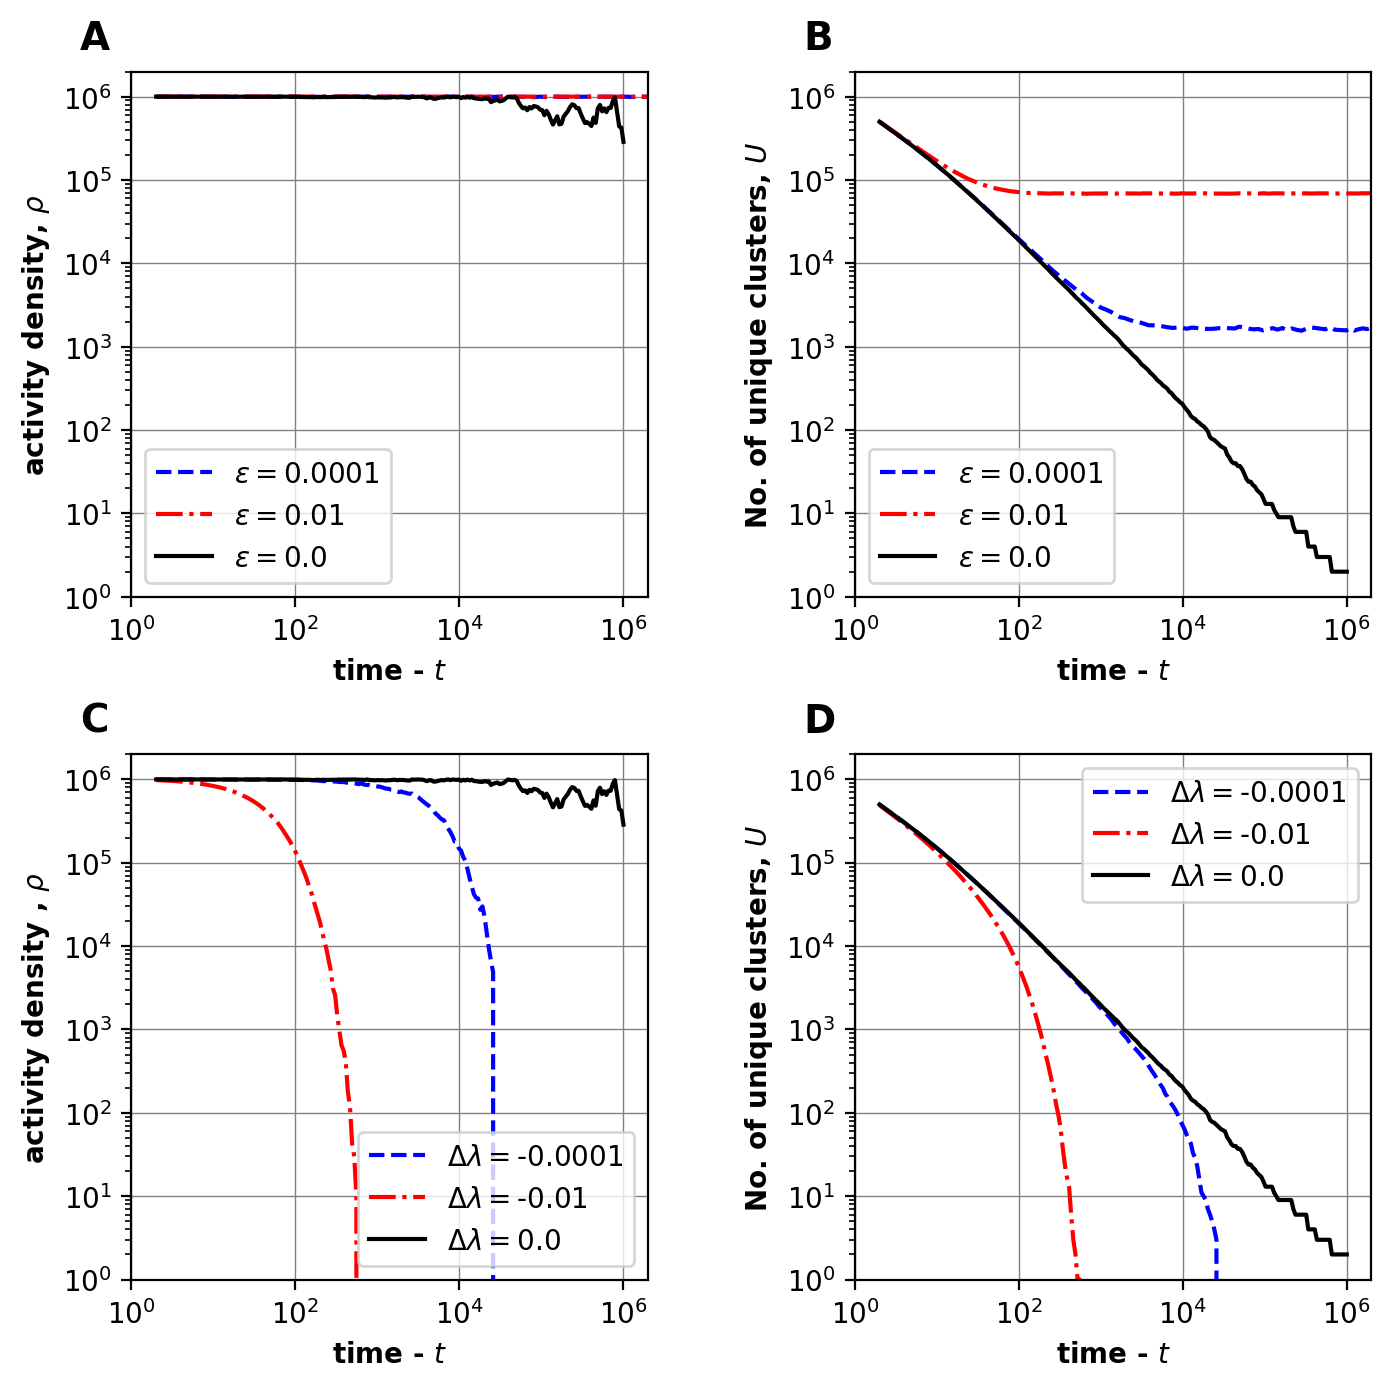

In [69]:
# ================ Paper version of the figure, smaller and fewer runs shown ====================
def gen_log_space(limit, n):
    result = [1]
    if n>1:  # just a check to avoid ZeroDivisionError
        ratio = (float(limit)/result[-1]) ** (1.0/(n-len(result)))
    while len(result)<n:
        next_value = result[-1]*ratio
        if next_value - result[-1] >= 1:
            # safe zone. next_value will be a different integer
            result.append(next_value)
        else:
            # problem! same integer. we need to find next_value by artificially incrementing previous value
            result.append(result[-1]+1)
            # recalculate the ratio so that the remaining values will scale correctly
            ratio = (float(limit)/result[-1]) ** (1.0/(n-len(result)))
    # round, re-adjust to 0 indexing (i.e. minus 1) and return np.uint64 array
    return np.array(list(map(lambda x: round(x)-1, result)), dtype=np.uint64)

def func_logpowlaw(x,m,c):
    return m*x + c

def find_zeroIndex(array):
    for i in range(len(array)):
        if array[i]==0:
            return i-1
    return len(array)-1

fig = plt.figure(figsize=(8,8)); grid = gridspec.GridSpec(2,2,wspace=0.4,hspace=0.3)

ax1 = fig.add_subplot(grid[0,0]) # Unique Clusters vs. Time (Eps)
ax2 = fig.add_subplot(grid[0,1]) # avg Cluster Size vs. Time (Eps)
ax3 = fig.add_subplot(grid[1,0]) # Unique Clusters vs. Time (Delta)
ax4 = fig.add_subplot(grid[1,1]) # avg Cluster Size vs. Time (Delta)

color_list = ['blue','red','black']
line_list = ['--','-.','-']
cp = -1

plotSeeds= [10,18]
for i in plotSeeds:
    print('starting i=' + str(i))
    cp +=1
    timeString = 'brain_1xx/brain1' + "{:0>2d}".format(i) + "_timeData.txt"
    savename = 'Plots/brain1xx/brain1' + "{:0>2d}".format(i) + "_timeAct.png"
    activityDensityFull,parts = activityAdding(timeString, 4, 9, 100, True, savename)
    actDensSparseIndexes = gen_log_space(len(activityDensityFull[:,0]-1),100)
    actList = []
    for ind in actDensSparseIndexes:
        actList += [activityDensityFull[ind,:].tolist()]
    activityDensity = np.asarray(actList)

    ax1.plot(activityDensity[:,0],activityDensity[:,1],label=r'$\epsilon=$'+str(round(float(parts[1]),6)),
             linewidth=1.5,color=color_list[cp],linestyle=line_list[cp])
    ax2.plot(activityDensity[:,0],activityDensity[:,2],label=r'$\epsilon=$'+str(round(float(parts[1]),6)),
             linewidth=1.5,color=color_list[cp],linestyle=line_list[cp])
    
cp = -1
plotSeeds= [86, 88]
for i in plotSeeds:
    print('starting i=' + str(i))
    cp +=1
    timeString = 'brain_2xx/brain2' + "{:0>2d}".format(i) + "_timeData.txt"
    savename = 'Plots/brain2xx/brain2' + "{:0>2d}".format(i) + "_timeAct.png"
    activityDensityFull,parts = activityAdding(timeString, 4, 9, 100, True, savename)
    actDensSparseIndexes = gen_log_space(len(activityDensityFull[:,0]-1),200)
    actList = []
    for ind in actDensSparseIndexes:
        actList += [activityDensityFull[ind,:].tolist()]
    activityDensity = np.asarray(actList)
    
    ax3.plot(activityDensity[:,0],activityDensity[:,1],label=r'$\Delta \lambda=$'+str(round(float(parts[2])-float(parts[3]),6)),
             linewidth=1.5,color=color_list[cp],linestyle=line_list[cp])
    ax4.plot(activityDensity[:,0],activityDensity[:,2],label=r'$\Delta \lambda=$'+str(round(float(parts[2])-float(parts[3]),6)),
             linewidth=1.5,color=color_list[cp],linestyle=line_list[cp])
    
i = 90; cp+=1
timeString = 'brain_2xx/brain2' + "{:0>2d}".format(i) + "_timeData.txt"
savename = 'Plots/brain2xx/brain2' + "{:0>2d}".format(i) + "_timeAct.png"
activityDensityFull,parts = activityAdding(timeString, 4, 9, 100, True, savename)
actDensSparseIndexes = gen_log_space(len(activityDensityFull[:,0]-1),200)
actList = []
for ind in actDensSparseIndexes:
    actList += [activityDensityFull[ind,:].tolist()]
activityDensity = np.asarray(actList)
ax1.plot(activityDensity[:,0],activityDensity[:,1],label=r'$\epsilon=$'+str(round(float(parts[1]),6)),
         linewidth=1.5,color=color_list[cp],linestyle=line_list[cp])
ax2.plot(activityDensity[:,0],activityDensity[:,2],label=r'$\epsilon=$'+str(round(float(parts[1]),6)),
         linewidth=1.5,color=color_list[cp],linestyle=line_list[cp])
ax3.plot(activityDensity[:,0],activityDensity[:,1],label=r'$\Delta \lambda=$'+str(round(float(parts[2])-float(parts[3]),6)),
         linewidth=1.5,color=color_list[cp],linestyle=line_list[cp])
ax4.plot(activityDensity[:,0],activityDensity[:,2],label=r'$\Delta \lambda=$'+str(round(float(parts[2])-float(parts[3]),6)),
         linewidth=1.5,color=color_list[cp],linestyle=line_list[cp])

ax1.set_xlim(left=1,right=2 * 10e5); ax1.set_ylim(bottom=1,top=2 * 10e5)
ax2.set_xlim(left=1,right=2 * 10e5); ax2.set_ylim(bottom=1,top=2 * 10e5)
ax3.set_xlim(left=1,right=2 * 10e5); ax3.set_ylim(bottom=1,top=2 * 10e5)
ax4.set_xlim(left=1,right=2 * 10e5); ax4.set_ylim(bottom=1,top=2 * 10e5)

ax1.text(-0.1, 1.1, 'A', fontsize=14, fontweight='bold', va='top', transform=ax1.transAxes)
ax2.text(-0.1, 1.1, 'B', fontsize=14, fontweight='bold', va='top', transform=ax2.transAxes)
ax3.text(-0.1, 1.1, 'C', fontsize=14, fontweight='bold', va='top', transform=ax3.transAxes)
ax4.text(-0.1, 1.1, 'D', fontsize=14, fontweight='bold', va='top', transform=ax4.transAxes)
    
ax1.set_xlabel(r'time - $t$',fontweight='bold')
ax1.set_ylabel(r'activity density, $\rho$',fontweight='bold')
ax2.set_xlabel(r'time - $t$',fontweight='bold')
ax2.set_ylabel(r'No. of unique clusters, $U$',fontweight='bold')
ax3.set_xlabel(r'time - $t$',fontweight='bold')
ax3.set_ylabel(r'activity density , $\rho$',fontweight='bold')
ax4.set_xlabel(r'time - $t$',fontweight='bold')
ax4.set_ylabel(r'No. of unique clusters, $U$',fontweight='bold')

ax1.set_yscale('log', nonposy='clip'); ax1.set_xscale('log', nonposx='clip')
ax2.set_yscale('log', nonposy='clip'); ax2.set_xscale('log', nonposx='clip')
ax3.set_yscale('log', nonposy='clip'); ax3.set_xscale('log', nonposx='clip')
ax4.set_yscale('log', nonposy='clip'); ax4.set_xscale('log', nonposx='clip')
ax1.legend();
ax2.legend();
ax3.legend(); 
ax4.legend();

ax1.grid(linestyle='-', linewidth='0.5', color='grey')
ax2.grid(linestyle='-', linewidth='0.5', color='grey')
ax3.grid(linestyle='-', linewidth='0.5', color='grey')
ax4.grid(linestyle='-', linewidth='0.5', color='grey')


fig.savefig('Plots/alpha_Relax.png',dpi=300,bbox_inches = "tight")
plt.show(fig)

## !!! This is the $\alpha$ figure for the Paper!!!

brain_1xx/brain106_timeData.txt
brain_1xx/brain110_timeData.txt
brain_1xx/brain114_timeData.txt
brain_2xx/brain285_timeData.txt
brain_2xx/brain286_timeData.txt
brain_2xx/brain287_timeData.txt
brain_2xx/brain290_timeData.txt
Adding plot elements
Adding labels
Changing scale
Adding legend
Adding gridlines
Removing ticks
Showing Fig


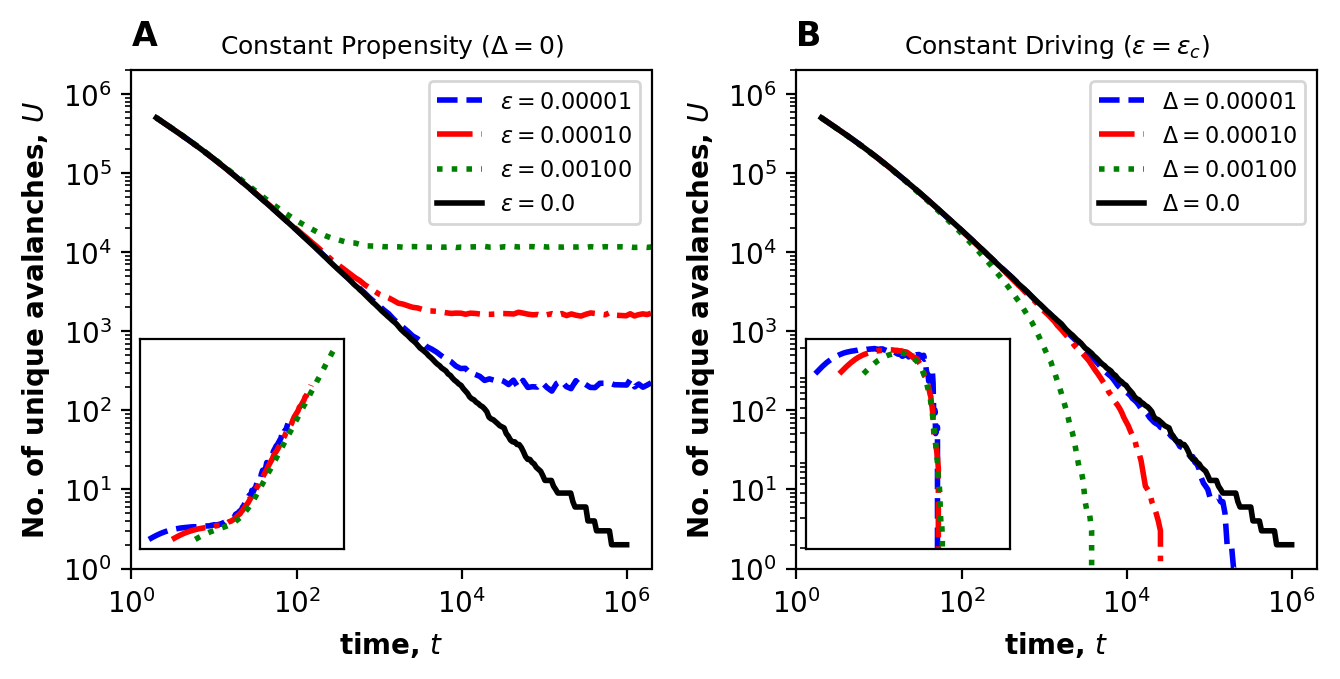

In [48]:
# ================ Paper version of the figure, smaller and fewer runs shown ====================
def gen_log_space(limit, n):
    result = [1]
    if n>1:  # just a check to avoid ZeroDivisionError
        ratio = (float(limit)/result[-1]) ** (1.0/(n-len(result)))
    while len(result)<n:
        next_value = result[-1]*ratio
        if next_value - result[-1] >= 1:
            # safe zone. next_value will be a different integer
            result.append(next_value)
        else:
            # problem! same integer. we need to find next_value by artificially incrementing previous value
            result.append(result[-1]+1)
            # recalculate the ratio so that the remaining values will scale correctly
            ratio = (float(limit)/result[-1]) ** (1.0/(n-len(result)))
    # round, re-adjust to 0 indexing (i.e. minus 1) and return np.uint64 array
    return np.array(list(map(lambda x: round(x)-1, result)), dtype=np.uint64)

def func_logpowlaw(x,m,c):
    return m*x + c

def find_zeroIndex(array):
    for i in range(len(array)):
        if array[i]==0:
            return i-1
    return len(array)-1


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6.8,3.5))

# These are in unitless percentages of the figure size. (0,0 is bottom left)
left, bottom, width, height = [0.11, 0.2, 0.15, 0.3]
ax3 = fig.add_axes([left, bottom, width, height])

left, bottom, width, height = [0.6, 0.2, 0.15, 0.3]
ax4 = fig.add_axes([left, bottom, width, height])

ax1.text( x=-0.00, y=1.05, s="A", color='black', fontsize=fs+2, fontweight = 'bold', transform=ax1.transAxes)  # Note the Font Size
ax2.text( x=-0.00, y=1.05, s="B", color='black', fontsize=fs+2, fontweight = 'bold', transform=ax2.transAxes)  # Note the Fontsize


color_list = ['blue','red','green','black']
line_list = ['--','-.',':','-']
cp = -1

plotSeeds= [6,10,14]
for i in plotSeeds:
    cp +=1
    timeString = 'brain_1xx/brain1' + "{:0>2d}".format(i) + "_timeData.txt"; print(timeString)
    savename = 'Plots/brain1xx/brain1' + "{:0>2d}".format(i) + "_timeAct.png"
    activityDensityFull,parts = activityAdding(timeString, 4, 9, 100, True, savename)
    actDensSparseIndexes = gen_log_space(len(activityDensityFull[:,0]-1),100)
    actList = []
    for ind in actDensSparseIndexes:
        actList += [activityDensityFull[ind,:].tolist()]
    activityDensity = np.asarray(actList)

    ax3.plot(activityDensity[:,0]*float(parts[1]), activityDensity[:,2]*activityDensity[:,0], 
             label=r'$\epsilon=$'+"{:.5f}".format(round(float(parts[1]),6)), 
             linewidth=2,color=color_list[cp],linestyle=line_list[cp])
    ax1.plot(activityDensity[:,0],activityDensity[:,2],
             label=r'$\epsilon=$'+"{:.5f}".format(round(float(parts[1]),6)),
             linewidth=2,color=color_list[cp],linestyle=line_list[cp])

cp = -1
plotSeeds= [85, 86, 87]
for i in plotSeeds:
    cp +=1
    timeString = 'brain_2xx/brain2' + "{:0>2d}".format(i) + "_timeData.txt"; print(timeString)
    savename = 'Plots/brain2xx/brain2' + "{:0>2d}".format(i) + "_timeAct.png"
    activityDensityFull,parts = activityAdding(timeString, 4, 9, 100, True, savename)
    actDensSparseIndexes = gen_log_space(len(activityDensityFull[:,0]-1),200)
    actList = []
    for ind in actDensSparseIndexes:
        actList += [activityDensityFull[ind,:].tolist()]
    activityDensity = np.asarray(actList)
    
    ax4.plot(activityDensity[:,0]* np.abs(float(parts[2])-float(parts[3])), activityDensity[:,2]*activityDensity[:,0],
             label=r'$\Delta =$'+"{:.5f}".format(round(float(parts[3])-float(parts[2]),6)),
             linewidth=2,color=color_list[cp],linestyle=line_list[cp])
    ax2.plot(activityDensity[:,0],activityDensity[:,2],
             label=r'$\Delta =$'+"{:.5f}".format(round(float(parts[3])-float(parts[2]),6)),
             linewidth=2,color=color_list[cp],linestyle=line_list[cp])
    
i = 90; cp+=1
timeString = 'brain_2xx/brain2' + "{:0>2d}".format(i) + "_timeData.txt"; print(timeString)
savename = 'Plots/brain2xx/brain2' + "{:0>2d}".format(i) + "_timeAct.png"
activityDensityFull,parts = activityAdding(timeString, 4, 9, 100, True, savename)
actDensSparseIndexes = gen_log_space(len(activityDensityFull[:,0]-1),200)
actList = []
for ind in actDensSparseIndexes:
    actList += [activityDensityFull[ind,:].tolist()]
activityDensity = np.asarray(actList)

ax1.plot(activityDensity[:,0],activityDensity[:,2],
         label=r'$\epsilon=$'+str(round(float(parts[1]),6)),
         linewidth=2,color=color_list[cp],linestyle=line_list[cp])
ax2.plot(activityDensity[:,0],activityDensity[:,2],
         label=r'$\Delta =$'+str(round(float(parts[2])-float(parts[3]),6)),
         linewidth=2,color=color_list[cp],linestyle=line_list[cp])

print('Adding plot elements')

ax1.set_xlim(left=1,right=2 * 1e6); ax1.set_ylim(bottom=1,top=2 * 1e6)
ax2.set_xlim(left=1,right=2 * 1e6); ax2.set_ylim(bottom=1,top=2 * 1e6)

print('Adding labels')
ax1.set_xlabel(r'time, $t$',fontweight = 'bold', fontsize = fs )
ax1.set_ylabel(r'No. of unique avalanches, $U$',fontweight = 'bold', fontsize = fs )
ax2.set_xlabel(r'time, $t$',fontweight = 'bold', fontsize = fs )
ax2.set_ylabel(r'No. of unique avalanches, $U$',fontweight = 'bold', fontsize = fs )


print('Changing scale')
ax1.set_yscale('log', nonposy='clip') 
ax1.set_xscale('log', nonposx='clip')
ax2.set_yscale('log', nonposy='clip') 
ax2.set_xscale('log', nonposx='clip')
ax3.set_yscale('log', nonposy='clip') 
ax3.set_xscale('log', nonposx='clip')
ax4.set_yscale('log', nonposy='clip') 
ax4.set_xscale('log', nonposx='clip')

print('Adding legend')
ax1.legend(fontsize=8,loc=1);
ax2.legend(fontsize=8,loc=1);

print('Adding gridlines')
# ax1.grid(True)
# ax2.grid(True)
# ax3.grid(True)
# ax4.grid(True)

print('Removing ticks')
ax3.tick_params(right= False,top= False,left= False, bottom= False)
ax3.set_yticklabels([])
ax3.set_xticklabels([])
ax4.tick_params(right= False,top= False,left= False, bottom= False)
ax4.set_yticklabels([])
ax4.set_xticklabels([])

ax1.set_title('Constant Propensity ($\Delta = 0$)',fontsize=fs-1 )# Note the Font Size
ax2.set_title('Constant Driving ($\epsilon = \epsilon_c$)',fontsize=fs-1 )# Note the Font Size

print('Showing Fig')
fig.savefig('Plots/alpha.png',dpi=300,bbox_inches = "tight")
plt.show(fig)

Text(-0.1, 1.1, 'B')

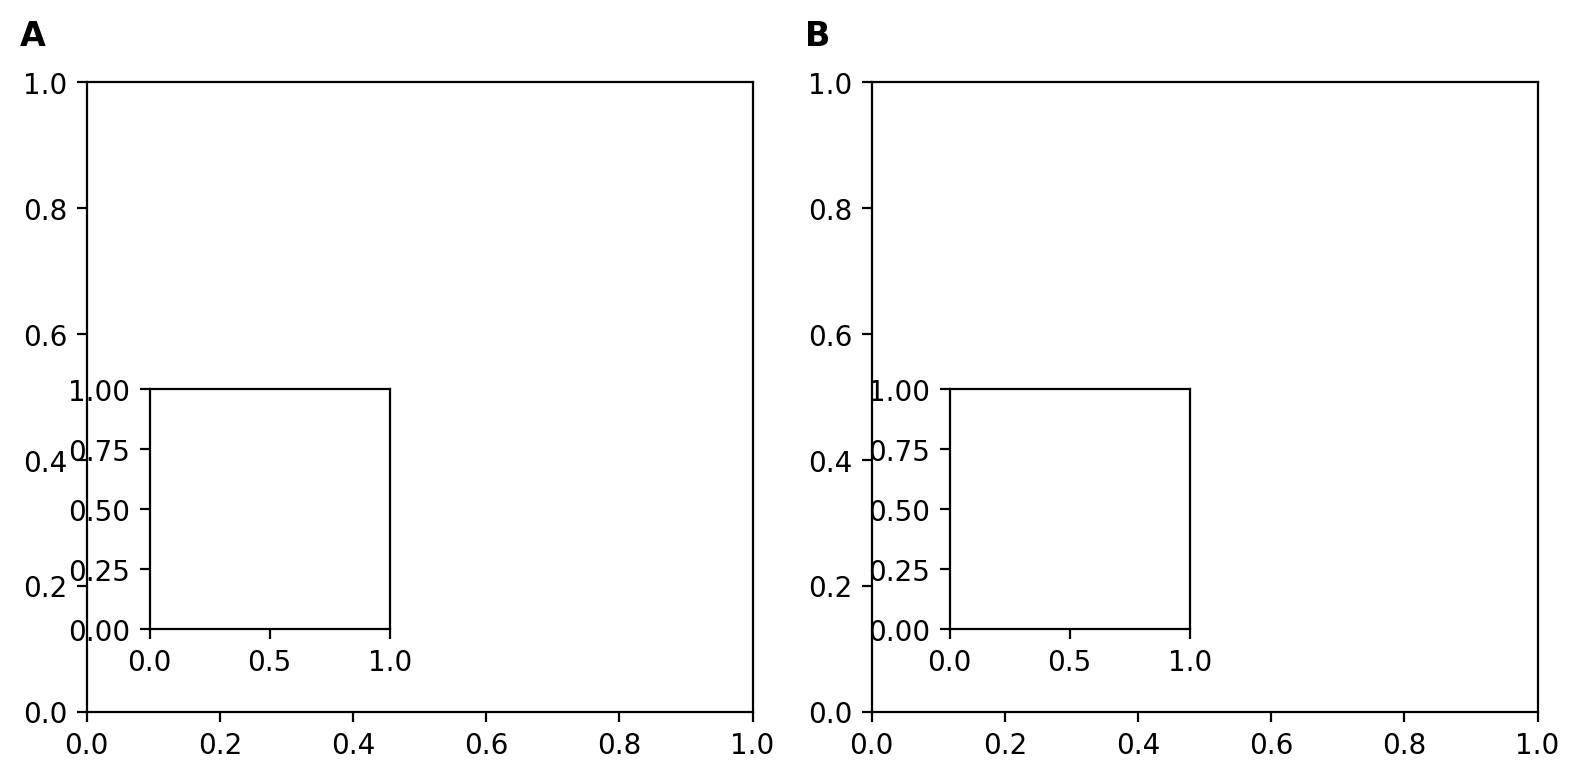

In [14]:
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(8,4))

# These are in unitless percentages of the figure size. (0,0 is bottom left)
left, bottom, width, height = [0.1, 0.2, 0.15, 0.3]
ax3 = fig.add_axes([left, bottom, width, height])

left, bottom, width, height = [0.6, 0.2, 0.15, 0.3]
ax4 = fig.add_axes([left, bottom, width, height])

ax1.text(-0.1, 1.1, 'A', fontsize=12, fontweight='bold', va='top')
ax2.text(-0.1, 1.1, 'B', fontsize=12, fontweight='bold', va='top')

starting i=2
starting i=10
starting i=18
starting i=84
starting i=86
starting i=88


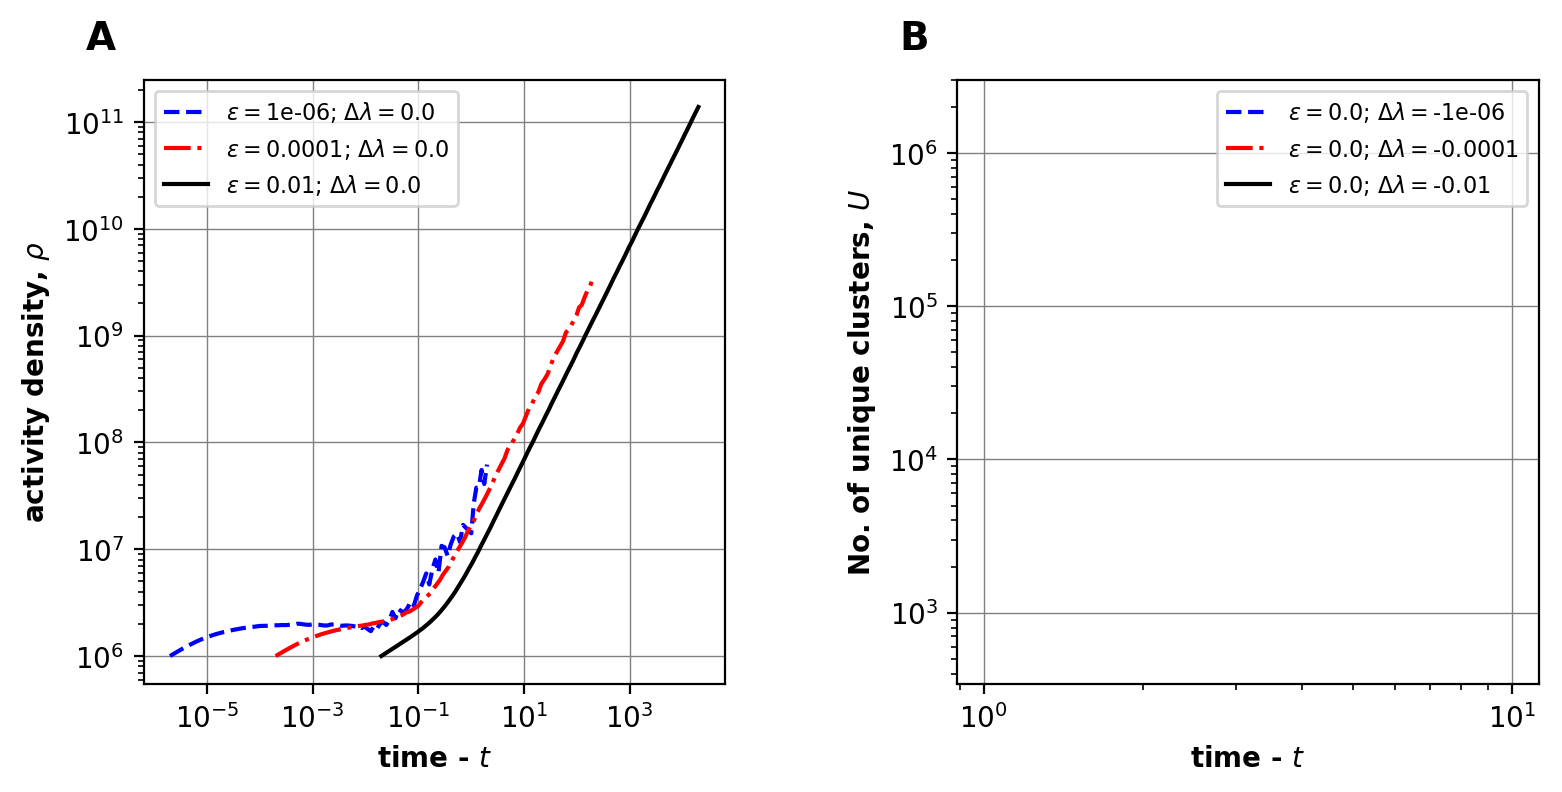

In [112]:
# ================ Paper version of the figure, smaller and fewer runs shown ====================
def gen_log_space(limit, n):
    result = [1]
    if n>1:  # just a check to avoid ZeroDivisionError
        ratio = (float(limit)/result[-1]) ** (1.0/(n-len(result)))
    while len(result)<n:
        next_value = result[-1]*ratio
        if next_value - result[-1] >= 1:
            # safe zone. next_value will be a different integer
            result.append(next_value)
        else:
            # problem! same integer. we need to find next_value by artificially incrementing previous value
            result.append(result[-1]+1)
            # recalculate the ratio so that the remaining values will scale correctly
            ratio = (float(limit)/result[-1]) ** (1.0/(n-len(result)))
    # round, re-adjust to 0 indexing (i.e. minus 1) and return np.uint64 array
    return np.array(list(map(lambda x: round(x)-1, result)), dtype=np.uint64)

def func_logpowlaw(x,m,c):
    return m*x + c

def find_zeroIndex(array):
    for i in range(len(array)):
        if array[i]==0:
            return i-1
    return len(array)-1

fig = plt.figure(figsize=(9,4)); grid = gridspec.GridSpec(1,2,wspace=0.4,hspace=0.3)

ax1 = fig.add_subplot(grid[0,0]) # Unique Clusters vs. Time (Eps)
ax2 = fig.add_subplot(grid[0,1]) # avg Cluster Size vs. Time (Eps)

color_list = ['blue','red','green','black']
line_list = ['--','-.','-']
cp = -1

plotSeeds= [2,10,18]
for i in plotSeeds:
    print('starting i=' + str(i))
    cp +=1
    timeString = 'brain_1xx/brain1' + "{:0>2d}".format(i) + "_timeData.txt"
    savename = 'Plots/brain1xx/brain1' + "{:0>2d}".format(i) + "_timeAct.png"
    activityDensityFull,parts = activityAdding(timeString, 4, 9, 100, True, savename)
    actDensSparseIndexes = gen_log_space(len(activityDensityFull[:,0]-1),100)
    actList = []
    for ind in actDensSparseIndexes:
        actList += [activityDensityFull[ind,:].tolist()]
    activityDensity = np.asarray(actList)

    ax1.plot(activityDensity[:,0]*float(parts[1]), activityDensity[:,2]*activityDensity[:,0], label=r'$\epsilon=$'+str(round(float(parts[1]),6))+'; $\Delta \lambda=$'+str(round(float(parts[2])-float(parts[3]),6)),
             linewidth=1.5,color=color_list[cp],linestyle=line_list[cp])

cp = -1
plotSeeds= [84, 86, 88]
for i in plotSeeds:
    print('starting i=' + str(i))
    cp +=1
    timeString = 'brain_2xx/brain2' + "{:0>2d}".format(i) + "_timeData.txt"
    savename = 'Plots/brain2xx/brain2' + "{:0>2d}".format(i) + "_timeAct.png"
    activityDensityFull,parts = activityAdding(timeString, 4, 9, 100, True, savename)
    actDensSparseIndexes = gen_log_space(len(activityDensityFull[:,0]-1),200)
    actList = []
    for ind in actDensSparseIndexes:
        actList += [activityDensityFull[ind,:].tolist()]
    activityDensity = np.asarray(actList)

    ax2.plot(activityDensity[:,0]* (float(parts[2])-float(parts[3])), activityDensity[:,2]*activityDensity[:,0],label=r'$\epsilon=$'+str(round(float(parts[1]),6))+'; $\Delta \lambda=$'+str(round(float(parts[2])-float(parts[3]),6)),
             linewidth=1.5,color=color_list[cp],linestyle=line_list[cp])
    
i = 90; cp+=1
timeString = 'brain_2xx/brain2' + "{:0>2d}".format(i) + "_timeData.txt"
savename = 'Plots/brain2xx/brain2' + "{:0>2d}".format(i) + "_timeAct.png"
activityDensityFull,parts = activityAdding(timeString, 4, 9, 100, True, savename)
actDensSparseIndexes = gen_log_space(len(activityDensityFull[:,0]-1),200)
actList = []
for ind in actDensSparseIndexes:
    actList += [activityDensityFull[ind,:].tolist()]
activityDensity = np.asarray(actList)

# ax1.plot(activityDensity[:,0] * 0,activityDensity[:,0] * activityDensity[:,2],label=r'$\epsilon=$'+str(round(float(parts[1]),6))+'; $\Delta \lambda=$'+str(round(float(parts[2])-float(parts[3]),6)),
#          linewidth=1.5,color='grey',linestyle=line_list[cp])
# ax2.plot(activityDensity[:,0] * 0,activityDensity[:,0] * activityDensity[:,2],label=r'$\epsilon=$'+str(round(float(parts[1]),6))+'; $\Delta \lambda=$'+str(round(float(parts[2])-float(parts[3]),6)),
#          linewidth=1.5,color='grey',linestyle=line_list[cp])

# ax1.set_xlim(left=1,right=2 * 10e5); ax1.set_ylim(bottom=1,top=2 * 10e5)
# ax2.set_xlim(left=1,right=2 * 10e5); ax2.set_ylim(bottom=1,top=2 * 10e5)

ax1.text(-0.1, 1.1, 'A', fontsize=14, fontweight='bold', va='top', transform=ax1.transAxes)
ax2.text(-0.1, 1.1, 'B', fontsize=14, fontweight='bold', va='top', transform=ax2.transAxes)
    
ax1.set_xlabel(r'time - $t$',fontweight='bold')
ax1.set_ylabel(r'activity density, $\rho$',fontweight='bold')
ax2.set_xlabel(r'time - $t$',fontweight='bold')
ax2.set_ylabel(r'No. of unique clusters, $U$',fontweight='bold')

ax1.set_yscale('log', nonposy='clip'); ax1.set_xscale('log', nonposx='clip')
ax2.set_yscale('log', nonposy='clip'); ax2.set_xscale('log', nonposx='clip')

ax1.legend(fontsize=8);
ax2.legend(fontsize=8);

ax1.grid(linestyle='-', linewidth='0.5', color='grey')
ax2.grid(linestyle='-', linewidth='0.5', color='grey')

# fig.savefig('Plots/alpha_Relax.png',dpi=300,bbox_inches = "tight")
plt.show(fig)

starting i=88


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: invalid value encountered in true_divide
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:65: RuntimeWarning: invalid value encountered in true_divide


starting i=87
starting i=86
starting i=85
starting i=84
starting i=90


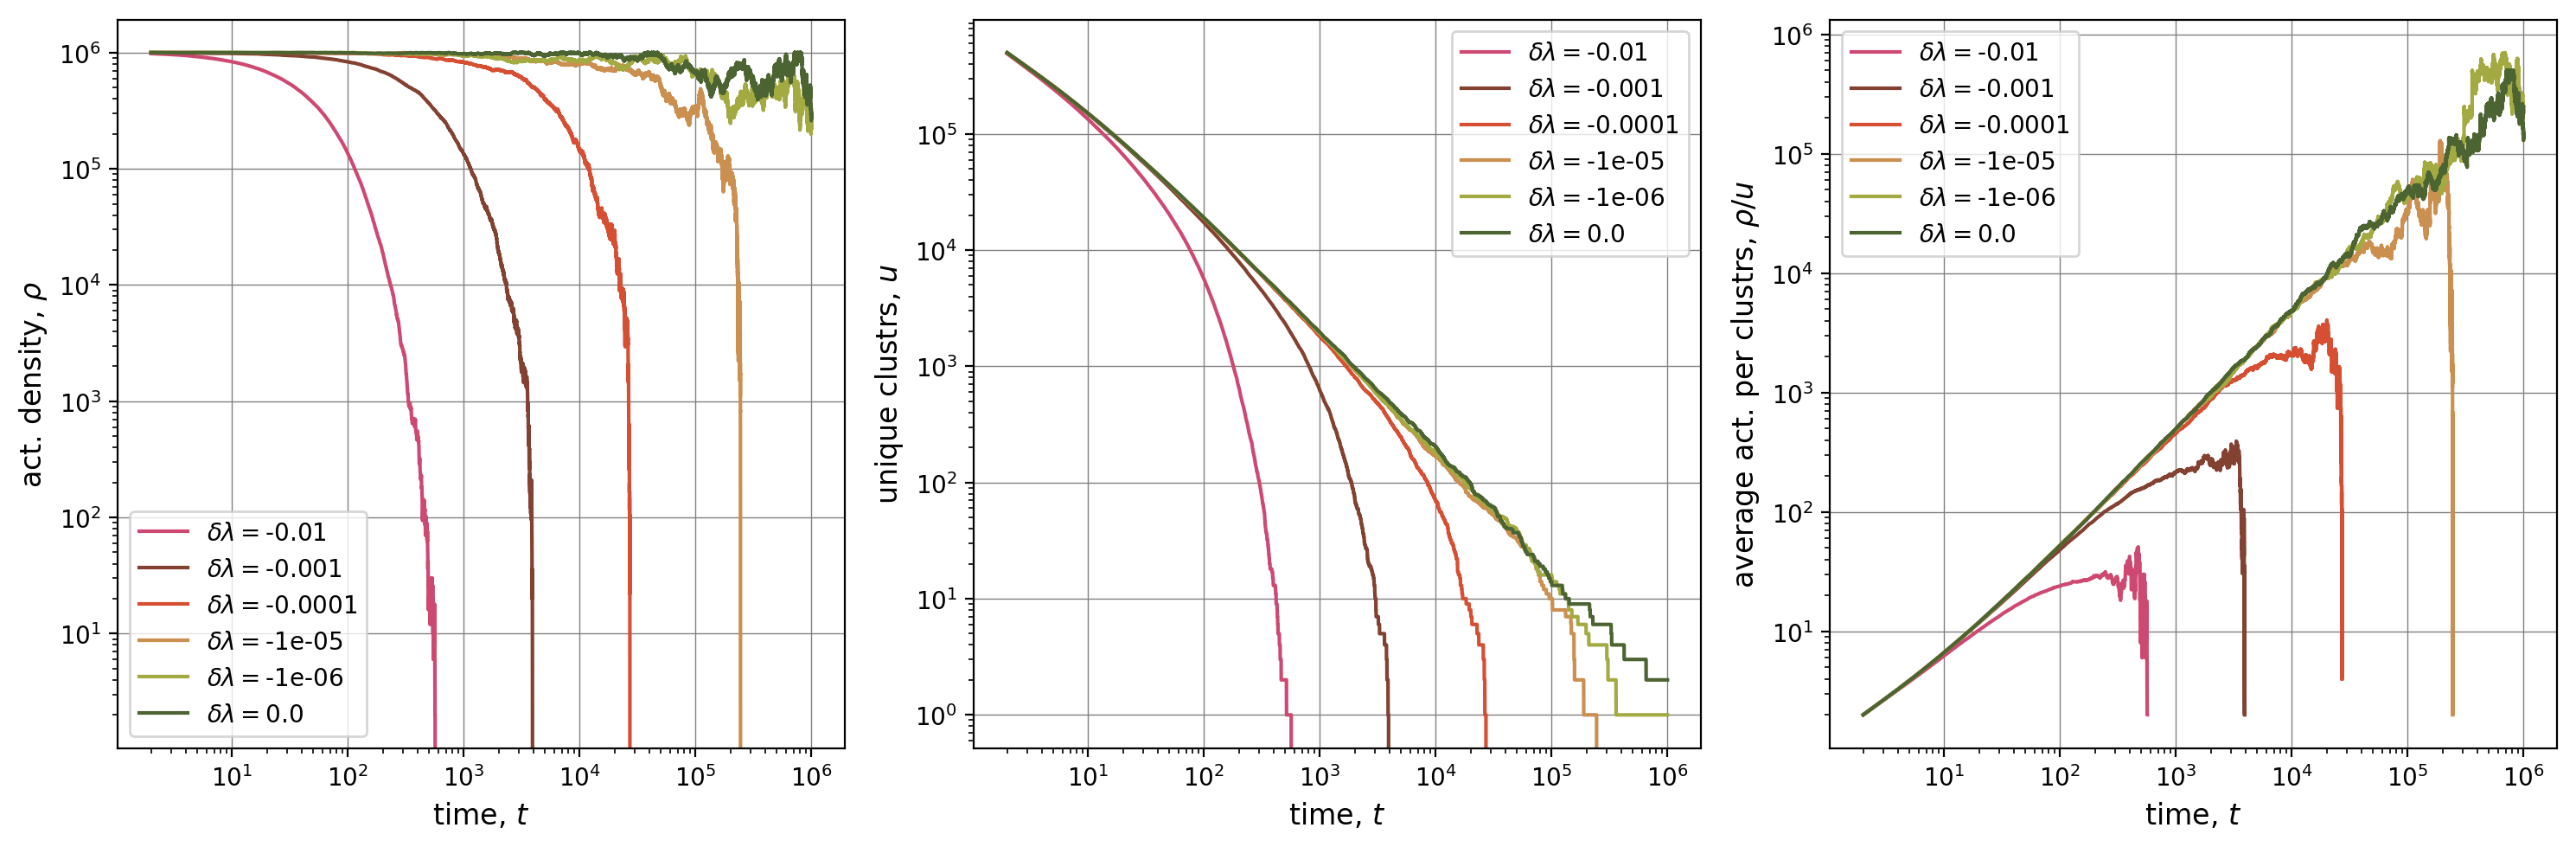

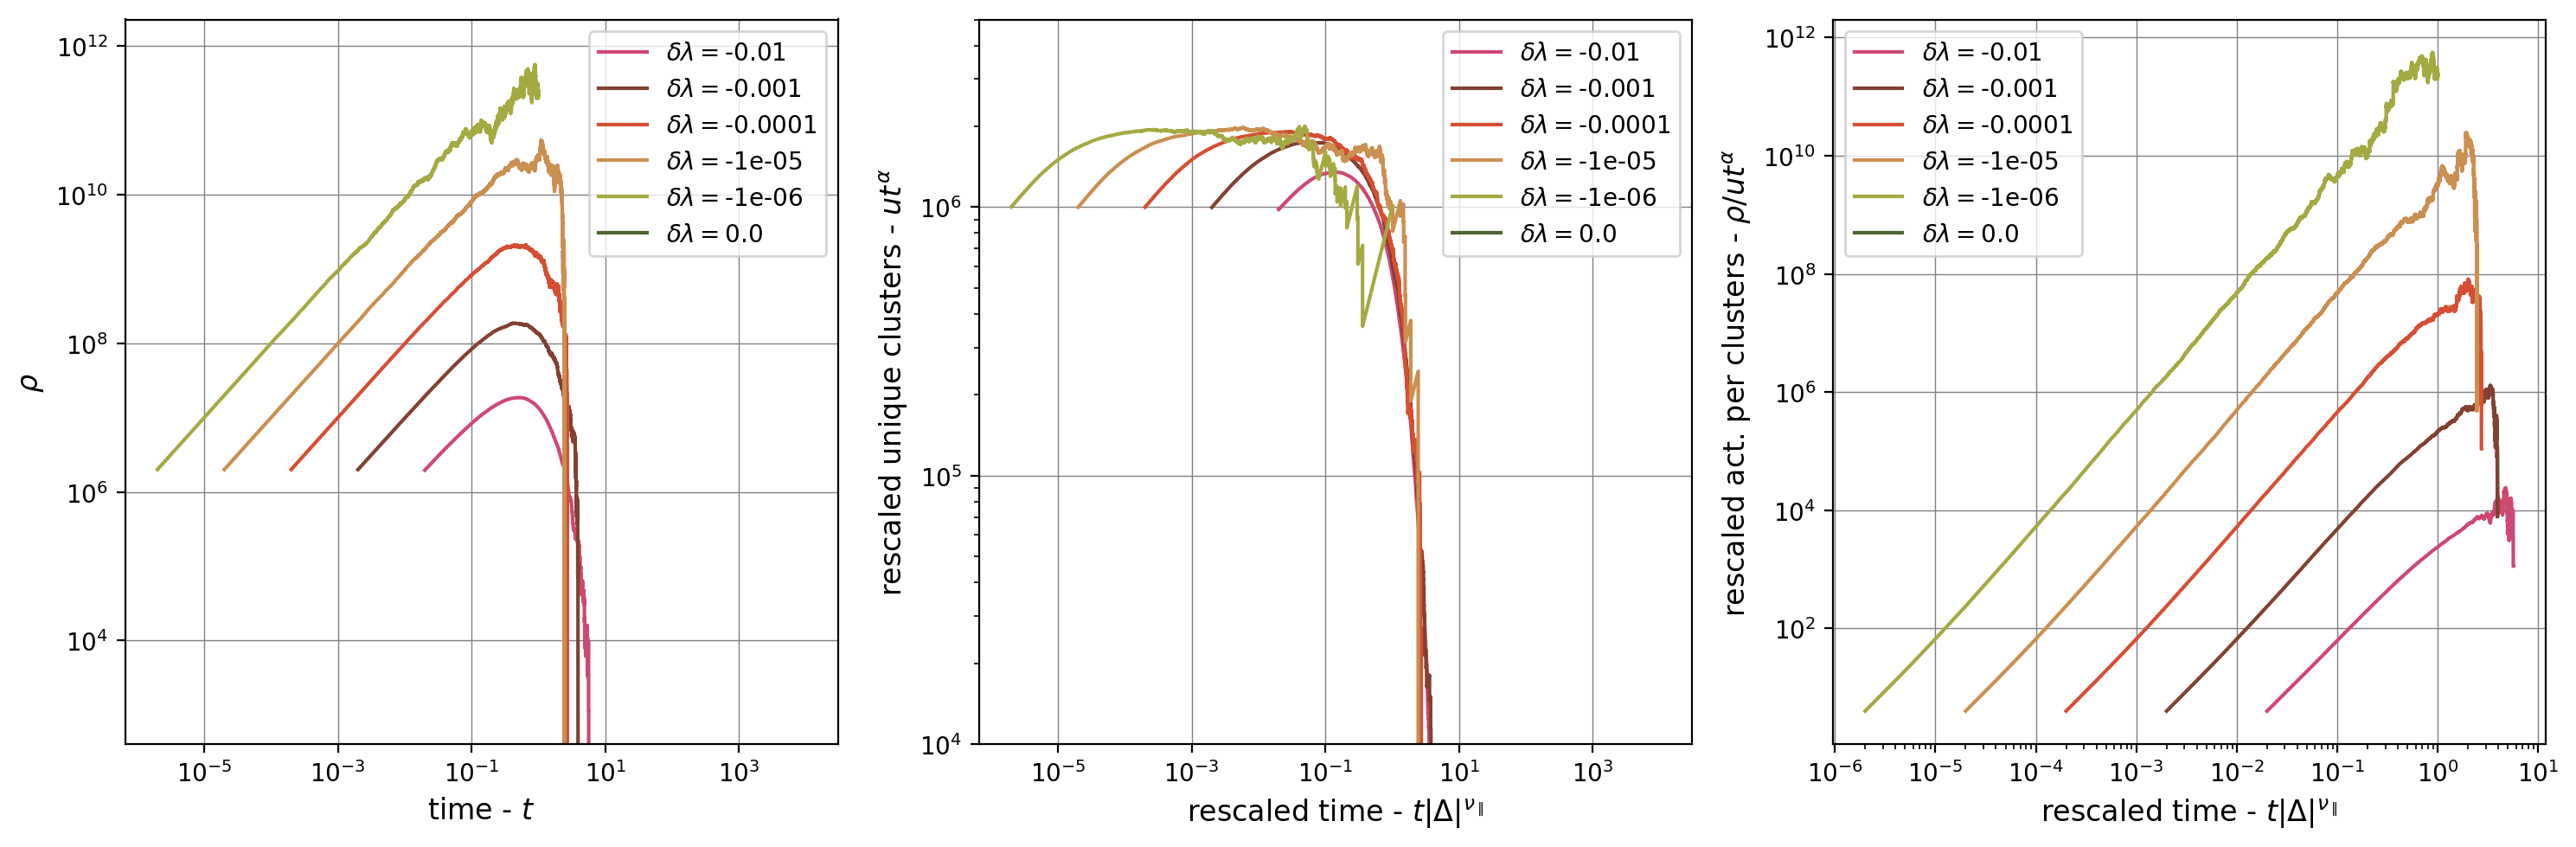

In [111]:
def func_logpowlaw(x,m,c):
    return m*x + c

def func_exp(x,zi,A):
    return A * np.exp(-x/zi)

def find_zeroIndex(array):
    for i in range(len(array)):
        if array[i]==0:
            return i-1
    return len(array)-1
    
# fig = plt.figure(figsize=(30,8)); grid = gridspec.GridSpec(16,3,wspace=0.2,hspace=0.2)

fig, (ax2, ax3, ax4) = plt.subplots(1, 3, figsize=(15,5))
fig2, (ax22, ax32, ax42) = plt.subplots(1, 3, figsize=(15,5))


# fig2 = plt.figure(figsize=(30,8)); grid = gridspec.GridSpec(16,3,wspace=0.2,hspace=0.2)

# ax2 = fig.add_subplot(grid[:,0]) # Active Sites vs. Time
# ax3 = fig.add_subplot(grid[:,1]) # Unique Clusters vs. Time
# ax4 = fig.add_subplot(grid[:,2]) # avg Cluster Size vs. Time

# ax22 = fig2.add_subplot(grid[:,0]) # Active Sites vs. Time
# ax32 = fig2.add_subplot(grid[:,1]) # Unique Clusters vs. Time
# ax42 = fig2.add_subplot(grid[:,2]) # avg Cluster Size vs. Time


color_list = np.array([[206,73,114],
[130,65,49],
[214,79,51],
[203,143,80],
[164,170,66],
[76,100,49],
[89,185,73],
[97,175,146],
[99,140,194],
[104,74,195],
[98,54,105],
[201,77,196],
[199,136,181]])/255
cp = -1

plotSeeds= [88,87,86,85,84,90]
for i in plotSeeds:
    print('starting i=' + str(i))
    cp +=1
    timeString = 'brain_2xx/brain2' + "{:0>2d}".format(i) + "_timeData.txt"
    savename = 'Plots/brain2xx/brain2' + "{:0>2d}".format(i) + "_timeAct.png"
    activityDensity,parts = activityAdding(timeString, 4, 9, 100, True, savename)
    
    ax2.plot(activityDensity[:,0],activityDensity[:,1], 
             label=r'$\delta \lambda=$'+str(round(float(parts[2])-float(parts[3]),6)), linewidth=1.5,color=color_list[cp])
    
    ax4.plot(activityDensity[:,0],activityDensity[:,1]/activityDensity[:,2], 
             label=r'$\delta \lambda=$'+str(round(float(parts[2])-float(parts[3]),6)), linewidth=1.5,color=color_list[cp])
    
    ax3.plot(activityDensity[:,0],activityDensity[:,2], 
             label=r'$\delta \lambda=$'+str(round(float(parts[2])-float(parts[3]),6)), linewidth=1.5,color=color_list[cp])
    
    ax22.plot(activityDensity[:,0]* np.abs(float(parts[2])-float(parts[3])),activityDensity[:,1] * activityDensity[:,0],
             label=r'$\delta \lambda=$'+str(round(float(parts[2])-float(parts[3]),6)), linewidth=1.5,color=color_list[cp])
    
    ax42.plot(activityDensity[:,0]* np.abs(float(parts[2])-float(parts[3])),activityDensity[:,1]/activityDensity[:,2] * activityDensity[:,0],
             label=r'$\delta \lambda=$'+str(round(float(parts[2])-float(parts[3]),6)), linewidth=1.5,color=color_list[cp])
    
    ax32.plot(activityDensity[:,0]* np.abs(float(parts[2])-float(parts[3])),activityDensity[:,2] * activityDensity[:,0],
             label=r'$\delta \lambda=$'+str(round(float(parts[2])-float(parts[3]),6)), linewidth=1.5,color=color_list[cp])

ax2.set_xlabel(r'time, $t$',fontsize='large'); 
ax2.set_ylabel(r'act. density, $\rho$',fontsize='large')
ax3.set_xlabel(r'time, $t$',fontsize='large'); 
ax3.set_ylabel(r'unique clustrs, $u$',fontsize='large')
ax4.set_xlabel(r'time, $t$',fontsize='large'); 
ax4.set_ylabel(r'average act. per clustrs, $\rho/u$',fontsize='large')

ax2.set_yscale('log', nonposy='clip'); ax2.set_xscale('log', nonposx='clip')
ax3.set_yscale('log', nonposy='clip'); ax3.set_xscale('log', nonposx='clip')
ax4.set_yscale('log', nonposy='clip'); ax4.set_xscale('log', nonposx='clip')

ax2.grid(linestyle='-', linewidth='0.5', color='grey')
ax3.grid(linestyle='-', linewidth='0.5', color='grey')
ax4.grid(linestyle='-', linewidth='0.5', color='grey')

ax2.legend();
ax3.legend(); 
ax4.legend(); 


ax32.set_ylim(bottom=1e4,top=5 * 1e6)

ax22.set_xlabel(r'time - $t$',fontsize='large'); 
ax22.set_ylabel(r'$\rho$',fontsize='large')
ax32.set_xlabel(r'rescaled time - $t|\Delta|^{\nu_\parallel}$',fontsize='large'); 
ax32.set_ylabel(r'rescaled unique clusters - $ut^\alpha$',fontsize='large')
ax42.set_xlabel(r'rescaled time - $t|\Delta|^{\nu_\parallel}$',fontsize='large'); 
ax42.set_ylabel(r'rescaled act. per clusters - $\rho / u t^\alpha$',fontsize='large')

ax22.set_yscale('log', nonposy='clip'); ax22.set_xscale('log', nonposx='clip')
ax32.set_yscale('log', nonposy='clip'); ax32.set_xscale('log', nonposx='clip')
ax42.set_yscale('log', nonposy='clip'); ax42.set_xscale('log', nonposx='clip')

ax22.grid(linestyle='-', linewidth='0.5', color='grey')
ax32.grid(linestyle='-', linewidth='0.5', color='grey')
ax42.grid(linestyle='-', linewidth='0.5', color='grey')

ax22.legend();
ax32.legend(); 
ax42.legend(); 

# savename = 'Plots/brain102xx/deltaLambd_timeStats.png'
# fig.savefig(savename,dpi=450,bbox_inches = "tight")
plt.show(fig)
plt.show(fig2)

starting i=1


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in true_divide


starting i=3
starting i=5
starting i=7
starting i=9
starting i=11
starting i=13
starting i=15
starting i=17
starting i=19
starting i=21


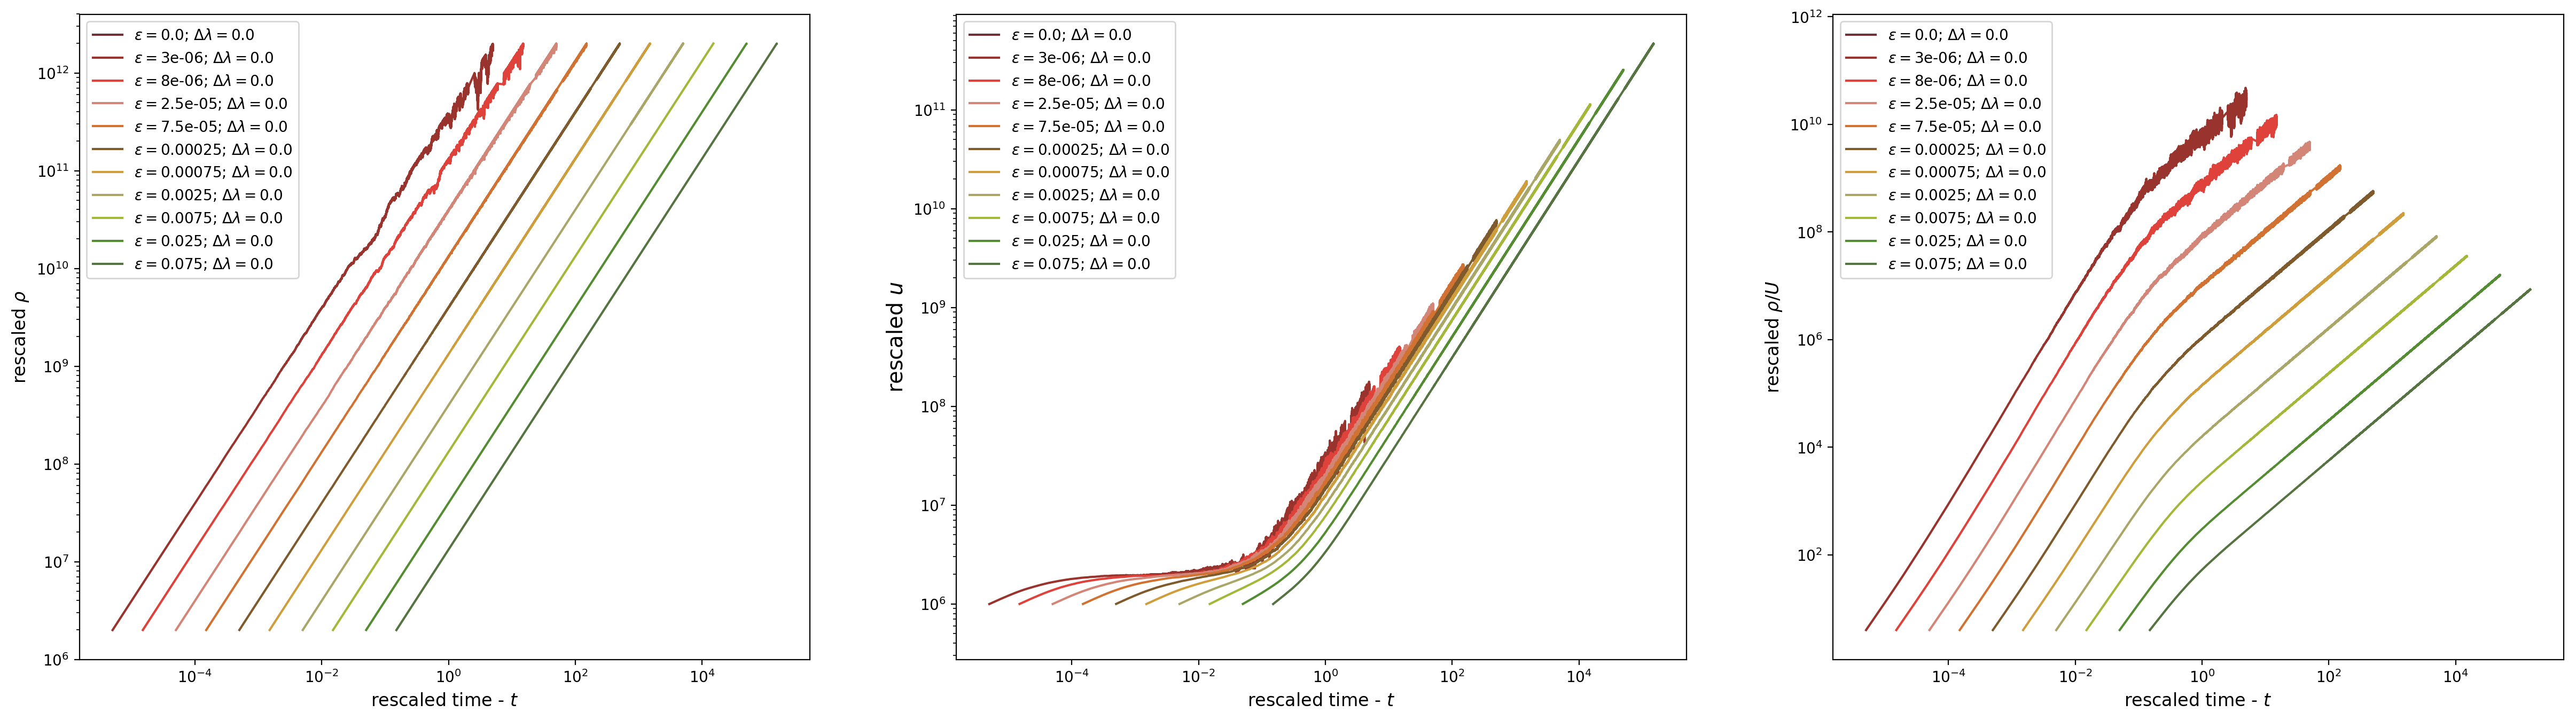

In [116]:
def func_logpowlaw(x,m,c):
    return m*x + c

def find_zeroIndex(array):
    for i in range(len(array)):
        if array[i]==0:
            return i-1
    return len(array)-1
    
fig = plt.figure(figsize=(30,8)); grid = gridspec.GridSpec(16,3,wspace=0.2,hspace=0.2)
ax2 = fig.add_subplot(grid[:,0]) # Active Sites vs. Time
ax3 = fig.add_subplot(grid[:,1]) # Unique Clusters vs. Time
ax4 = fig.add_subplot(grid[:,2]) # avg Cluster Size vs. Time

color_list = np.array([[111,49,55],
[152,52,45],
[223,66,59],
[211,134,120],
[210,114,50],
[126,90,44],
[207,157,60],
[170,166,103],
[164,183,56],
[84,140,50],
[86,116,66],
[45,72,33],
[86,196,68],
[91,186,128],
[81,169,165],
[100,143,191],
[115,111,210],
[109,57,193],
[92,57,112],
[205,77,197],
[198,137,184],
[199,67,125]])/255
cp = -1

plotSeeds= np.arange(1,23,2)
for i in plotSeeds:
    print('starting i=' + str(i))
    cp +=1
    timeString = 'brain_1xx/brain1' + "{:0>2d}".format(i) + "_timeData.txt"
    savename = 'Plots/brain1xx/brain1' + "{:0>2d}".format(i) + "_timeAct.png"
    activityDensityPlots(timeString, 4, 9, 100, True, savename)
    activityDensity,parts = activityAdding(timeString, 4, 9, 100, True, savename)
    
    ax2.plot(activityDensity[:,0]*float(parts[1]), activityDensity[:,1]*activityDensity[:,0], 
             label=r'$\epsilon=$'+str(round(float(parts[1]),6))+'; $\Delta \lambda=$'+str(round(float(parts[2])-float(parts[3]),6)),
             linewidth=1.5,color=color_list[cp],linestyle=line_list[2])
    ax3.plot(activityDensity[:,0]*float(parts[1]), activityDensity[:,2]*activityDensity[:,0], 
             label=r'$\epsilon=$'+str(round(float(parts[1]),6))+'; $\Delta \lambda=$'+str(round(float(parts[2])-float(parts[3]),6)),
             linewidth=1.5,color=color_list[cp],linestyle=line_list[2])
    ax4.plot(activityDensity[:,0]*float(parts[1]), activityDensity[:,1]*activityDensity[:,0]/activityDensity[:,2], 
             label=r'$\epsilon=$'+str(round(float(parts[1]),6))+'; $\Delta \lambda=$'+str(round(float(parts[2])-float(parts[3]),6)),
             linewidth=1.5,color=color_list[cp],linestyle=line_list[2])

# ax2.set_ylim(top=10**6.1,bottom=10**4)
ax2.set_xlabel(r'rescaled time - $t$',fontsize='large'); ax2.set_ylabel(r'rescaled $\rho$',fontsize='large')
ax4.set_xlabel(r'rescaled time - $t$',fontsize='large'); ax4.set_ylabel(r'rescaled $\rho / U$',fontsize='large')
ax3.set_xlabel(r'rescaled time - $t$',fontsize='large'); ax3.set_ylabel(r'rescaled $u$',fontsize='x-large')
ax2.set_yscale('log', nonposy='clip'); ax2.set_xscale('log', nonposx='clip')
ax3.set_yscale('log', nonposy='clip'); ax3.set_xscale('log', nonposx='clip')
ax4.set_yscale('log', nonposy='clip'); ax4.set_xscale('log', nonposx='clip')
ax2.legend();
ax3.legend(); 
ax4.legend()

ax2.tick_params('both')
# ax3.set_title('$N = $'+str(parts[0])+'$; \delta \lambda = 0 $' + '; $\mu=$'+str(parts[3]),fontweight='bold',fontsize='large')
savename = 'Plots/brain1xx/epsi_timeStats.png'
fig.savefig(savename,dpi=450,bbox_inches = "tight")
plt.show(fig)

# Final Stuff

In [ ]:
i = 30 #The first testrun of random walkers 
filename = 'Data/distr_brain1' + "{:0>2d}".format(i) + ".png"
sizeString = 'brain1' + "{:0>2d}".format(i) + "_Sizes.txt"
durationString = 'brain1' + "{:0>2d}".format(i) + "_Durations.txt"
timeString = 'brain1' + "{:0>2d}".format(i) + "_timeData.txt"
savename = 'Plots/timeAct_brain1' + "{:0>2d}".format(i) + ".png"
